In [1]:
import csv
import pickle
import json
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from mouselab.mouselab import MouselabEnv
import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy
import math
import sklearn.cluster
from math import floor, ceil

# Reading Data from Files

In [2]:
fileprefix = "full" # pilot_#, final
datafolder = '../results/anonymized_data/'

all_part_files = [filename for filename in os.listdir(datafolder) if filename.startswith(fileprefix) and 'results' not in filename]
all_part_paths = [datafolder + filename for filename in all_part_files]

# Creating Trial Dataframe

In [3]:
# Choose which experiment data to use, or to combine
# 1 = original experiment
# 2 = replication experiment
# all = both experiments combined
data_to_use_master = "all" # "1", "2", or "all"

In [4]:
# Each participant has their own file, generated from the Heroku postgres output in the 
# preprocessing notebook

part_stats_dicts = []
extract_max_trials = 40
for file in all_part_paths:
    replication = "full_r" in file
    with open(file, 'r') as f:
        participant = json.load(f)
    try:
        beginhit = datetime.datetime.strptime(participant['Beginhit'], '%Y-%m-%d %H:%M:%S.%f')
    except TypeError:
        beginhit = None
    try:
        endhit = datetime.datetime.strptime(participant['Endhit'], '%Y-%m-%d %H:%M:%S.%f')
    except TypeError:
        endhit = None
    try:    
        beginexp = datetime.datetime.strptime(participant['Beginexp'], '%Y-%m-%d %H:%M:%S.%f')
    except TypeError:
        beginexp = None
    
    try:
        hitLength = (endhit-beginhit).seconds
    except TypeError:
        hitLength = None
    
    try:
        expLength = (endhit-beginexp).seconds
    except TypeError:
        expLength = None
        
    numPracTrials = 0
    trialLengths = []
    trialScores = []
    expectedScores = []
    numClicks = []
    timeFirstAction = []
    timeFirstClick = []
    avgClickLevel = []
    trialClicksL1 = []
    trialClicksL2 = []
    trialClicksL3 = []
    trialClicksL4 = []
    trialClicksL5 = []
    reached_max_trials = False
    demographicsAvailable = False
    effort = "-1"
    age = None
    gender = None
    colorblind = None
    
    #print(participant['workerId'])
    # Extract length of experiment
    try:
        firstTrialStamp = participant['data'][0]['dateTime']
    except:
        print("No data")
        continue
    lastTrialStamp = participant['data'][-1]['dateTime']
    if hitLength is None:
        hitLength = (lastTrialStamp - firstTrialStamp) / 1000
    if expLength is None:
        expLength = (lastTrialStamp - firstTrialStamp) / 1000
        
    # Dictionary to check whether mouselab task has been completed
    mdp_timestamps = {
        "start" : 0,
        "end" : 0,
        "done": False
    }
    
    # Use state machine to parse participant trial data, update state 
    #  based on trials seen
    current_state = "stroop_1"
    last_trial = participant['data'][0]
    feedback = ""
    comments = ""
    whatStrategy = ""
    firstLevelAns = {}
    strategyImprove = ""
    difficult = ""
    clickStratsValid = True
    for idx, trial in enumerate(participant['data']):
        trial_type = trial['trialdata']['trial_type']
        try:
            trial_id = str(trial['trialdata']['trial_id'])
        except KeyError:
            trial_id = ""
    
        # Start mouselab trials
        if trial_id.startswith("mouselab_instructions_1") and not mdp_timestamps["done"]:
            mdp_timestamps["done"] = True
            mdp_timestamps["start"] = trial['dateTime']
        
        # Finish mouselab trials
        if trial_id.startswith("final_quiz"):
            mdp_timestamps["end"] = trial['dateTime']
        
        # Mouselab trial encountered
        if trial_type == 'mouselab-mdp':
            if trial_id.startswith('practice'):
                numPracTrials += 1
            else:
                if extract_max_trials and len(trialScores) == extract_max_trials:
                    if not reached_max_trials:
                        reached_max_trials = True
                        print(f"!!! More than {extract_max_trials} trials found !!!")
                    continue
                    
                # Trial length
                trialLengths.append(trial['trialdata']['trialTime'])
                
                # Score obtained on trial
                trialScores.append(trial['trialdata']['score'])
                
                # Recording the times at which actions were taken
                timeFirstAction.append(trial['trialdata']['actionTimes'][0])
                
                # Getting expected scores based on revealed rewards
                g_truth = [0.0] + trial['trialdata']['stateRewards'][1:]
                mEnv = MouselabEnv.new_symmetric_registered('large_increasing', ground_truth=g_truth)
                clicks = trial['trialdata']['queries']['click']['state']['target']
                
                # Recording time at which the first click was made
                try:
                    timeFirstClick.append(trial['trialdata']['queries']['click']['state']['time'][0])
                except:
                    timeFirstClick.append(None)
                for click in clicks:
                    try:
                        mEnv.step(int(click))
                    except:
                        print(click)
                        continue
                
                
                # Saving the number of clicks and the average depth of all clicks
                numClicks.append(len(clicks))
                
                # Matching click number to node depth
                clicksL1 = len([c for c in clicks if int(c) in [1,12,23]])
                clicksL2 = len([c for c in clicks if int(c) in [2,13,24]])
                clicksL3 = len([c for c in clicks if int(c) in [3,14,25]])
                clicksL4 = len([c for c in clicks if int(c) in [4,8,15,19,26,30]])
                clicksL5 = len([c for c in clicks if int(c) in [5,6,7,9,10,11,16,17,18,20,21,22,27,28,29,31,32,33]])
                
                # Computing average level of all clicks
                try:
                    avgLevel = (clicksL1 + 2*clicksL2 + 3*clicksL3 + 4*clicksL4 + 5*clicksL5)/len(clicks)
                except:
                    avgLevel = 0
                
                trialClicksL1.append(clicksL1)
                trialClicksL2.append(clicksL2)
                trialClicksL3.append(clicksL3)
                trialClicksL4.append(clicksL4)
                trialClicksL5.append(clicksL5)
                avgClickLevel.append(avgLevel)
                
                # plan quality is expected score of the trial minus costs
                # print(trial['trialdata']['costs'])
                planQuality = mEnv._term_reward() + trial['trialdata']['costs']
                expectedScores.append(planQuality)
        
        # Recording responses to end survey questions
        if trial_id.startswith("self_report_2"):
            firstLevelAns = trial['trialdata']['response']
            
        if trial_type == 'survey-html-form':
            
            if 'effort' in trial['trialdata']['response']:
                effort = trial['trialdata']['response']['effort']
                age = trial['trialdata']['response']['age']
                gender = trial['trialdata']['response']['gender']
                colorblind = trial['trialdata']['response']['colorblind']
                demographicsAvailable = True
        if trial_id.startswith("finish_fail"):
            feedback = trial['trialdata']['response']['Q0']
            age = trial['trialdata']['response']['Q1']
            gender = trial['trialdata']['response']['Q2']
            colorblind = trial['trialdata']['response']['Q3']
            comments = trial['trialdata']['response']['Q4']
            demographicsAvailable = True
        elif trial_type == 'survey-text':
            if trial_id.startswith("self_report"):
                whatStrategy = trial['trialdata']['response']['Q0']
                strategyImprove = trial['trialdata']['response']['Q1']
                difficult = trial['trialdata']['response']['Q2']
            elif not trial_id.startswith("answer"):
                #print(trial['trialdata'])
                feedback = trial['trialdata']['response']['Q0']
                alreadyParticipated = trial['trialdata']['response']['Q1']
                comments = trial['trialdata']['response']['Q2']
        
        last_trial = trial

    
    # Check whether participant dropped out by seeing whether any of the phases doesn't have an end timestamp
    dropoutPoint = None
    for obj, type_ in zip([mdp_timestamps], ["mdp"]):
        if obj["start"] > 0 and obj["end"] == 0:
            dropoutPoint = type_
            obj["end"] = lastTrialStamp
    
    # Reason for which participant data should be excluded (stored with participant data during pre-processing)
    if "excludeReason" in participant:
        excludedReason = participant["excludeReason"]
    else:
        excludedReason = None
    
    clickStratsValid = excludedReason != "invalidClickStrats"
    
    # Save participant statistics in dictionary   
    part_stats_dict = {
        "workerId": participant['workerId'],
        "Beginhit": beginhit,
        "Endhit": endhit,
        "Beginexp": beginexp,
        "psiturkStatus" : participant["psiturkStatus"],
        "browser" : participant["browser"],
        "platform" : participant["platform"],
        "language" : participant["language"],
        "excludedReason": excludedReason,
        "hitLength": hitLength,
        "expLength": expLength,
        "totalLengthSum": (lastTrialStamp - firstTrialStamp) / 1000,
        "numQuizAttempts": numPracTrials / 2,
        "trialLengths": trialLengths,
        "trialScores" : trialScores,
        "timeFirstAction" : timeFirstAction,
        "timeFirstClick" : timeFirstClick,
        "numTrialsCompleted": len(trialLengths),
        "effort": effort,
        "condition": participant['condition'],
        "mouselabLength" : (mdp_timestamps["end"] - mdp_timestamps["start"]) / 1000,
        "dropoutPoint" : dropoutPoint,
        "feedback": feedback,
        "comments": comments,
        "expectedScores": expectedScores,
        "numClicks": numClicks,
        "avgClickLevel" : avgClickLevel,
        "clicksL1": trialClicksL1,
        "clicksL2": trialClicksL2,
        "clicksL3": trialClicksL3,
        "clicksL4": trialClicksL4,
        "clicksL5": trialClicksL5,
        "demographicsAvailable": demographicsAvailable,
        "clickStratsValid": clickStratsValid,
        "replication": replication
    }
    
    # Get final score from data file, or if not present, sum up the scores of all the rewarded trials
    if 'questiondata' in participant and 'final_score' in participant['questiondata']:
        part_stats_dict['finalScore'] = participant['questiondata']['final_score']
    else:
        part_stats_dict['finalScore'] = sum([score for score in trialScores])
    
    part_stats_dict["expLengthSum"] = + part_stats_dict["mouselabLength"]
    part_stats_dict["expLengthDiff"] = part_stats_dict["expLengthSum"] - part_stats_dict["expLength"]
    if len(trialLengths) > 0:
        part_stats_dict["averageTrialLength"] = sum(trialLengths) / len(trialLengths)
        
    part_stats_dicts.append(part_stats_dict)

print("Finished reading data files")

No data
!!! More than 40 trials found !!!
No data
!!! More than 40 trials found !!!
No data
No data
No data
No data
No data
No data
No data
No data
No data
Finished reading data files


# Pre-Analysis 0.0: Exclusion of Participants

In [5]:
# Compiling all data into trial data

exclude_parts = ["w85534180"]

add_fields = ["trialScores", "expectedScores", "numClicks", "avgClickLevel", "trialNumbers", "condition", "workerId",
             "clicksL1", "clicksL2", "clicksL3", "clicksL4" ,"clicksL5", "clickStratsValid", "replication"]

all_trial_data = {field: [] for field in add_fields}

count = 0;

def format_field_val(field, part):
    if field == 'workerId':
        return [part['workerId']] * len(part['trialScores'])
    elif field == 'trialNumbers':
        return list(range(1,len(part['trialScores'])+1))
    elif field == 'clickStratsValid':
        return [part["clickStratsValid"]] * len(part['trialScores'])
    elif field == 'condition':
        return [int(part['condition'])] * len(part['trialScores'])
    elif field == "replication":
        return [part["replication"]] * len(part["trialScores"])
    else:
        return part[field]

    
# Checking which participants to include in the analysis
# Exclusion criteria updated for replication experiment and combined analysis
# Participants who already participated, reported not putting effort into the effort, 
# and exceeded the experiment time were included in the analysis of the original experiment

if data_to_use_master == "1":
    valid_reasons = ["invalidClickStrats","alreadyparticipated","noeffort","exceededTime"]
else:
    valid_reasons = ["invalidClickStrats"]
    
parts_excluded = {}
for part in part_stats_dicts:
    
    if part["excludedReason"] and part["excludedReason"] not in valid_reasons:
        # print(part['condition'], part['workerId'], part["excludedReason"], len(part['trialScores']))
        parts_excluded[part['workerId']] = (part['condition'],part["excludedReason"])
        continue
    if len(part['trialScores']) not in [40]:
        # print(part['condition'], part['workerId'], "MDP Data Incomplete", len(part['trialScores']))
        continue
        
    # Include in analysis only those participants whose data is complete
    if not part['demographicsAvailable']:
        # print(part['condition'], part['workerId'], "Demographics missing")
        continue
    if part["workerId"] in exclude_parts:
        print(part['condition'], part['workerId'], "Excluding participant")
        continue
    count += 1
    for field in add_fields:
        all_trial_data[field] += format_field_val(field, part)    

all_trials_df = pd.DataFrame(all_trial_data)


In [6]:
# Filter by experiment if needed
if data_to_use_master == "1":
    all_trials_df = all_trials_df.loc[~all_trials_df.replication].reset_index(drop=True)
elif data_to_use_master == "2":
    all_trials_df = all_trials_df.loc[all_trials_df.replication].reset_index(drop=True)

In [7]:
all_trials_df_backup = all_trials_df.copy()

In [8]:
all_trials_df

trialScores  expectedScores  numClicks  avgClickLevel  trialNumbers   
0            12.25           12.25          5       3.000000             1  \
1           -75.90            1.10          6       3.333333             2   
2            15.00            0.00          0       0.000000             3   
3           -72.15           -2.15          5       2.800000             4   
4            42.25            9.25          5       3.000000             5   
...            ...             ...        ...            ...           ...   
20835        52.95           43.95          7       5.000000            36   
20836        21.85           33.85          1       5.000000            37   
20837        50.65           63.65          9       5.000000            38   
20838        85.85           81.85          1       5.000000            39   
20839        92.85           72.85          1       5.000000            40   

       condition   workerId  clicksL1  clicksL2  clicksL3  clicksL4  clicksL5   
0              1  w11930620         1         1         1         1         1  \
1              1  w11930620         1         1         1         1         2   
2              1  w11930620         0         0         0         0         0   
3              1  w11930620         1         1         1         2         0   
4              1  w11930620         1         1         1         1         1   
...          ...        ...       ...       ...       ...       ...       ...   
20835          1  w96211185         0         0         0         0         7   
20836          1  w96211185         0         0         0         0         1   
20837          1  w96211185         0         0         0         0         9   
20838          1  w96211185         0         0         0         0         1   
20839          1  w96211185         0         0         0         0         1   

       clickStratsValid  replication  
0                  True        False  
1                  True        False  
2                  True        False  
3                  True        False  
4                  True        False  
...                 ...          ...  
20835              True        False  
20836              True        False  
20837              True        False  
20838              True        False  
20839              True        False  

[20840 rows x 14 columns]

In [9]:
# Counts of participants in each condition

print("Condition 0")
print(len(all_trials_df.loc[all_trials_df.condition == 0]) / all_trials_df.trialNumbers.max())
print("Condition 1")
print(len(all_trials_df.loc[all_trials_df.condition == 1]) / all_trials_df.trialNumbers.max())

Condition 0
262.0
Condition 1
259.0


In [10]:
# List of all participant IDs in sorted order for cross referencing
sorted(list(all_trials_df.workerId.unique()))

['w10087435',
 'w10092073',
 'w10432942',
 'w10573274',
 'w10597662',
 'w10978872',
 'w11177063',
 'w11186246',
 'w11243396',
 'w11309130',
 'w11462312',
 'w11532598',
 'w11594719',
 'w11930620',
 'w12038840',
 'w12167464',
 'w12271574',
 'w12322810',
 'w12790815',
 'w12816576',
 'w12888826',
 'w13100309',
 'w13245283',
 'w13475977',
 'w13532455',
 'w14115695',
 'w14176872',
 'w14274734',
 'w14401973',
 'w14522309',
 'w14584874',
 'w14788080',
 'w14820724',
 'w14925228',
 'w15073287',
 'w15442413',
 'w16433856',
 'w16476295',
 'w16485452',
 'w16572819',
 'w16937372',
 'w17360819',
 'w17783226',
 'w18251777',
 'w18580193',
 'w18642308',
 'w18826734',
 'w19237186',
 'w19354974',
 'w19374751',
 'w19439893',
 'w19480958',
 'w19528032',
 'w20049511',
 'w20188397',
 'w20262211',
 'w20419254',
 'w20539671',
 'w20584059',
 'w20838185',
 'w20854806',
 'w20898979',
 'w20913252',
 'w21067498',
 'w21420348',
 'w21428452',
 'w21695759',
 'w21696427',
 'w21793705',
 'w21827938',
 'w21947348',
 'w220

## Analyzing Inferred Strategies

In [11]:
# Reset dataframe to remove strategies

all_trials_df = all_trials_df_backup.copy()

In [12]:
# Defining paths

# list of categorical strategies that can be inferred by Computational Microscope
results_path = '../results'
inferred_path = results_path + "/cm/inferred_strategies"

# Inferred strategies for current experiment
mis_inferred_files = [inferred_path + "/misaligned_exp_anon/strategies.pkl"]
control_inferred_files = [inferred_path + "/misaligned_control_anon/strategies.pkl"]

# Output files for strategies
mis_file = results_path + "/mouselab-mdp-final-misaligned.csv"
control_file = results_path + "/mouselab-mdp-final-control.csv"

# Expected scores of all strategies
strategy_scores_mis_path = results_path + "/cm/strategy_scores/b-31123_v-1_2_3_8_44_c-1.0,1.0,1.0,1.0,1.0_strategy_scores.pkl"
strategy_scores_control_path = results_path + "/cm/strategy_scores/b-31123_v-1_2_3_8_44_c-1.0,1.0,1.0,1.0,1.0_strategy_scores.pkl"

click_depths_mis_path = results_path + "/cm/strategy_scores/b-31123_v-1_2_3_8_44_c-1.0,1.0,1.0,1.0,1.0_clickdepthlist.pkl"
click_depths_control_path = results_path + "/cm/strategy_scores/b-31123_v-1_2_3_8_44_c-1.0,1.0,1.0,1.0,1.0_clickdepthlist.pkl"


# Defining the cost structure of the conditions without cognitive + time costs
base_mis_cost_struc = [-0.25, 0.35, 0.95, 1.55, 2.15]
base_control_cost_struc = [1.4] * 5

# Defining the cost structure of the conditions adjusted for cognitive + time costs
adj_mis_cost_struc = [1.75, 2.35, 2.95, 3.55, 9.65]
adj_control_cost_struc = [6.4] * 5

use_adj_costs = False

if use_adj_costs:
    mis_cost_struc = adj_mis_cost_struc
    control_cost_struc = adj_control_cost_struc
else:
    mis_cost_struc = base_mis_cost_struc
    control_cost_struc = base_control_cost_struc

    
# Strategies to be excluded
problematic_strategies = [19, 20, 25, 35, 38, 52, 68, 77, 81, 83]

# Simulation constant cost for each node
simulation_cost = 1.0
num_simulations = 200000

mis_df_rows = []
control_df_rows = []

In [13]:
# Reading csv files

with open(mis_file, newline='') as file:
    reader = csv.reader(file)
    for idx, row in enumerate(reader):
        if idx == 0: continue
        mis_df_rows.append([row[0], int(row[1])])
        
with open(control_file, newline='') as file:
    reader = csv.reader(file)
    for idx, row in enumerate(reader):
        if idx == 0: continue
        control_df_rows.append([row[0], int(row[1])])

In [14]:
# Reading inferred strategies

mis_strategies = {}
control_strategies = {}

for mis_inferred in mis_inferred_files:
    with open(mis_inferred, 'rb') as f:
        strat_dict = pickle.load(f)
        mis_strategies.update(strat_dict)

for control_inferred in control_inferred_files:
    with open(control_inferred, 'rb') as f:
        strat_dict = pickle.load(f)
        control_strategies.update(strat_dict)

In [15]:
strategy_df = all_trials_df[['workerId', 'trialNumbers', 'condition']].copy()
strategy_df['strategy'] = [None] * len(strategy_df) 

In [16]:
for workerId, stratList in mis_strategies.items():
    try:
        strategy_df.loc[strategy_df.workerId == workerId, 'strategy'] = stratList
    except:
        continue
    
for workerId, stratList in control_strategies.items():
    try:
        strategy_df.loc[strategy_df.workerId == workerId, 'strategy'] = stratList
    except:
        continue

In [17]:
# Reading strategy scores without costs and click depths of strategies

with open(strategy_scores_mis_path, 'rb') as file:
    strategy_scores_mis_raw = pickle.load(file)
    
with open(strategy_scores_control_path, 'rb') as file:
    strategy_scores_control_raw = pickle.load(file)
    
with open(click_depths_mis_path, 'rb') as file:
    click_depths_mis = pickle.load(file)
    
with open(click_depths_control_path, 'rb') as file:
    click_depths_control = pickle.load(file)


In [18]:
# Correct the scores of all strategies based on the clicks made at each depth
def correct_strategy_scores(score_dict, strat_d_clicks, d_costs, num_sims, sim_cost):
    scores_copy = score_dict.copy()
    for s in scores_copy.keys():
        d_clicks = strat_d_clicks[s]
        s_score = score_dict[s]
        new_s_score = adjust_strat_score(s_score, num_sims, sim_cost, d_clicks, d_costs)
        scores_copy[s] = new_s_score

    return scores_copy

# Adjust the strategy score based on the cost structure at each depth
def adjust_strat_score(score, num_sims, simulation_cost, depth_click_list, depth_cost_list):
    total_points = score * num_sims
    costs_already_deducted = sum(
        [num_sims * simulation_cost * d_clicks for d_clicks in depth_click_list])
    costs_to_be_deducted = sum(
        [d_cost * num_sims * d_clicks for (d_cost, d_clicks) in zip(depth_cost_list, depth_click_list)])
    #print(costs_already_deducted, costs_to_be_deducted)
    updated_score = (total_points + costs_already_deducted - costs_to_be_deducted) / num_simulations
    return updated_score

In [19]:

# Adjust strategy scores based on the cost of the environment and sort
strategy_scores_mis = correct_strategy_scores(strategy_scores_mis_raw, click_depths_mis, mis_cost_struc, num_simulations, simulation_cost)
strategy_scores_mis = dict(sorted(strategy_scores_mis.items(), key=lambda item: item[1], reverse=True))
strategy_scores_mis = {k + 1: v for (k, v) in strategy_scores_mis.items() if k + 1 not in problematic_strategies}


strategy_scores_control = correct_strategy_scores(strategy_scores_control_raw, click_depths_control, control_cost_struc, num_simulations, simulation_cost)
strategy_scores_control = dict(sorted(strategy_scores_control.items(), key=lambda item: item[1], reverse=True))
strategy_scores_control = {k + 1: v for (k, v) in strategy_scores_control.items() if k + 1 not in problematic_strategies}


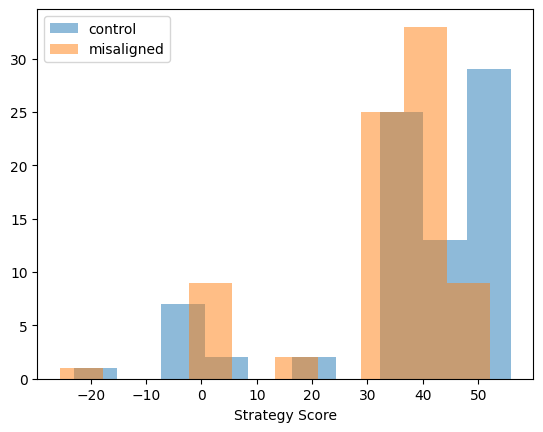

In [20]:
# Histogram of strategy scores
plt.figure()
control_counts, control_bins, _ = plt.hist(strategy_scores_control.values(), alpha=0.5, label='control')
mis_counts, mis_bins, _ = plt.hist(strategy_scores_mis.values(), alpha=0.5, label='misaligned')
plt.legend()
plt.xlabel("Strategy Score")
plt.show()

In [21]:
# Creating the strategy score dataframes

strategy_scores_mis_list = [[k,v] for k,v in strategy_scores_mis.items()]
strategy_scores_control_list = [[k,v] for k,v in strategy_scores_control.items()]

mis_cluster_df = pd.DataFrame(strategy_scores_mis_list, columns=["strategy", "score"])
control_cluster_df = pd.DataFrame(strategy_scores_control_list, columns=["strategy", "score"])

# Scale to 0-1:
mis_cluster_df['scoreScaled'] = (mis_cluster_df['score'] - mis_cluster_df['score'].min()) / (mis_cluster_df['score'].max() - mis_cluster_df['score'].min())
control_cluster_df['scoreScaled'] = (control_cluster_df['score'] - control_cluster_df['score'].min()) / (control_cluster_df['score'].max() - control_cluster_df['score'].min())


In [22]:
# Cluster the strategy scores

init_guesses = [0.6,0.5,0.4]
init_guesses = 3

mis_clusters = scipy.cluster.vq.kmeans(mis_cluster_df['scoreScaled'], k_or_guess=init_guesses)
mis_cluster_centers = sorted(mis_clusters[0], reverse=True)

control_clusters = scipy.cluster.vq.kmeans(control_cluster_df['scoreScaled'], k_or_guess=init_guesses)
control_cluster_centers = sorted(control_clusters[0], reverse=True)

In [23]:
# Compute the cluster labels: 0 - adaptive, 1 - moderately adaptive, 2 - maladaptive

mis_clusters_repeated = np.repeat(np.expand_dims(mis_cluster_centers, axis=0), len(mis_cluster_df), axis=0)
mis_cluster_distances = (mis_clusters_repeated - np.repeat(np.expand_dims(np.array(mis_cluster_df['scoreScaled']), axis=1),repeats=len(mis_cluster_centers), axis=1))**2
mis_cluster_labels = np.argmin(mis_cluster_distances, axis=1)

control_clusters_repeated = np.repeat(np.expand_dims(control_cluster_centers, axis=0), len(control_cluster_df), axis=0)
control_cluster_distances = (control_clusters_repeated - np.repeat(np.expand_dims(np.array(control_cluster_df['scoreScaled']), axis=1),repeats=len(control_cluster_centers), axis=1))**2
control_cluster_labels = np.argmin(control_cluster_distances, axis=1)

In [24]:
# Create dictionary of cluster labels:

mis_cluster_dict = { strat: cluster for (strat, cluster) in zip(mis_cluster_df.strategy, mis_cluster_labels)}

control_cluster_dict = { strat: cluster for (strat, cluster) in zip(control_cluster_df.strategy, control_cluster_labels)}


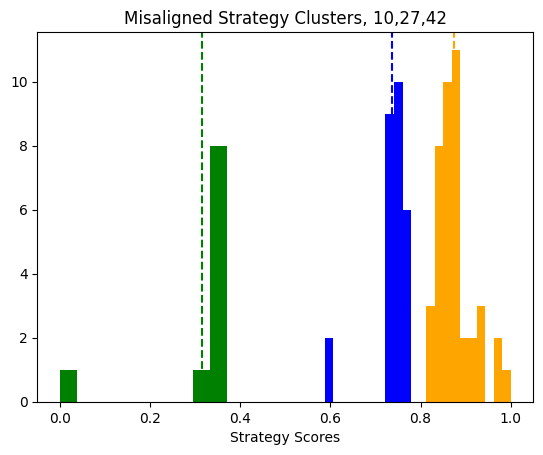

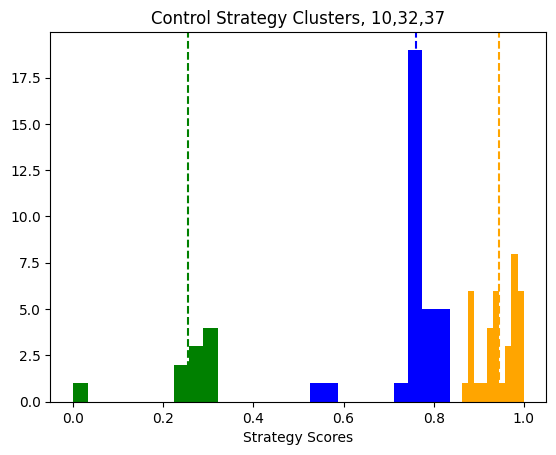

In [25]:
# Plotting the strategy clusters

plt.figure()
cluster_colors = ['orange', 'blue', 'green']
labels = ['adaptive', 'moderate', 'maladaptive']
cluster_sizes = []
for c in [0,1,2]:
    cluster_strats = [k for (k,v) in mis_cluster_dict.items() if v == c]
    cluster_scores = [list(mis_cluster_df.loc[mis_cluster_df.strategy==s]["scoreScaled"])[0] for s in cluster_strats]
    plt.hist(cluster_scores, color=cluster_colors[c], label=labels[c])
    plt.axvline(mis_cluster_centers[c], linestyle="--", color=cluster_colors[c])
    cluster_sizes.append(sum(value == c for value in mis_cluster_dict.values()))
cluster_sizes = [str(s) for s in cluster_sizes]
plt.title("Misaligned Strategy Clusters, {}".format(",".join(cluster_sizes[::-1])))
plt.xlabel("Strategy Scores")

cluster_sizes = []
plt.figure()
for c in [0,1,2]:
    cluster_strats = [k for (k,v) in control_cluster_dict.items() if v == c]
    cluster_scores = [list(control_cluster_df.loc[control_cluster_df.strategy==s]["scoreScaled"])[0] for s in cluster_strats]
    plt.hist(cluster_scores, color=cluster_colors[c], label=labels[c])
    cluster_sizes.append(sum(value == c for value in control_cluster_dict.values()))
    plt.axvline(control_cluster_centers[c], linestyle="--", color=cluster_colors[c])
cluster_sizes = [str(s) for s in cluster_sizes]
plt.title("Control Strategy Clusters, {}".format(",".join(cluster_sizes[::-1])))
plt.xlabel("Strategy Scores")
    
plt.show()

In [26]:
# Add clusters and strategy scores to strategy_df 

strategy_df['cluster'] = [None] * len(strategy_df)
strategy_df['strategyScores'] = [None] * len(strategy_df)

for idx, row in strategy_df.iterrows():
    if row['condition'] == 0:
        strategy_df.at[idx, 'cluster'] = control_cluster_dict[row['strategy']]
        strategy_df.at[idx, 'strategyScores'] = strategy_scores_control[row['strategy']]
    else:
        strategy_df.at[idx, 'cluster'] = mis_cluster_dict[row['strategy']]
        strategy_df.at[idx, 'strategyScores'] = strategy_scores_mis[row['strategy']]
    
    
strategy_df['strategyScores'] = strategy_df['strategyScores'].astype("float")

In [27]:
# Merging trial data with strategy data

strategy_cols = ["workerId", "trialNumbers", "strategy", "cluster", "strategyScores"]

all_trials_df = pd.merge(all_trials_df, strategy_df[strategy_cols], on=['workerId', "trialNumbers"])


In [28]:
# Scaling scores by optimal scores of the respective conditions
optimal_env_score = {
    0: 55.89,
    1: 52.14
}

In [29]:
all_trials_df["strategyScores_scaled"] = all_trials_df["strategyScores"]
all_trials_df.loc[all_trials_df["condition"] == 0, "strategyScores_scaled"] = all_trials_df.loc[all_trials_df["condition"] == 0, "strategyScores_scaled"]/optimal_env_score[0]
all_trials_df.loc[all_trials_df["condition"] == 1, "strategyScores_scaled"] = all_trials_df.loc[all_trials_df["condition"] == 1, "strategyScores_scaled"]/optimal_env_score[1]

In [30]:
all_trials_df["expectedScores_scaled"] = all_trials_df["expectedScores"]
all_trials_df.loc[all_trials_df["condition"] == 0, "expectedScores_scaled"] = all_trials_df.loc[all_trials_df["condition"] == 0, "expectedScores_scaled"]/optimal_env_score[0]
all_trials_df.loc[all_trials_df["condition"] == 1, "expectedScores_scaled"] = all_trials_df.loc[all_trials_df["condition"] == 1, "expectedScores_scaled"]/optimal_env_score[1]

In [31]:
# Data to use for the remainder of the analysis
filtered_data = all_trials_df

In [32]:
filtered_data

trialScores  expectedScores  numClicks  avgClickLevel  trialNumbers   
0            12.25           12.25          5       3.000000             1  \
1           -75.90            1.10          6       3.333333             2   
2            15.00            0.00          0       0.000000             3   
3           -72.15           -2.15          5       2.800000             4   
4            42.25            9.25          5       3.000000             5   
...            ...             ...        ...            ...           ...   
20835        52.95           43.95          7       5.000000            36   
20836        21.85           33.85          1       5.000000            37   
20837        50.65           63.65          9       5.000000            38   
20838        85.85           81.85          1       5.000000            39   
20839        92.85           72.85          1       5.000000            40   

       condition   workerId  clicksL1  clicksL2  clicksL3  clicksL4  clicksL5   
0              1  w11930620         1         1         1         1         1  \
1              1  w11930620         1         1         1         1         2   
2              1  w11930620         0         0         0         0         0   
3              1  w11930620         1         1         1         2         0   
4              1  w11930620         1         1         1         1         1   
...          ...        ...       ...       ...       ...       ...       ...   
20835          1  w96211185         0         0         0         0         7   
20836          1  w96211185         0         0         0         0         1   
20837          1  w96211185         0         0         0         0         9   
20838          1  w96211185         0         0         0         0         1   
20839          1  w96211185         0         0         0         0         1   

       clickStratsValid  replication strategy cluster  strategyScores   
0                  True        False       61       1       20.593685  \
1                  True        False       61       1       20.593685   
2                  True        False       61       1       20.593685   
3                  True        False       61       1       20.593685   
4                  True        False       61       1       20.593685   
...                 ...          ...      ...     ...             ...   
20835              True        False       63       0       43.092734   
20836              True        False       21       0       42.452037   
20837              True        False       21       0       42.452037   
20838              True        False       21       0       42.452037   
20839              True        False       21       0       42.452037   

       strategyScores_scaled  expectedScores_scaled  
0                   0.394969               0.234944  
1                   0.394969               0.021097  
2                   0.394969               0.000000  
3                   0.394969              -0.041235  
4                   0.394969               0.177407  
...                      ...                    ...  
20835               0.826481               0.842923  
20836               0.814193               0.649214  
20837               0.814193               1.220752  
20838               0.814193               1.569812  
20839               0.814193               1.397200  

[20840 rows x 19 columns]

# Visualizing Data

Only the first graph from this section is reported in the write-up

## Expected Scores

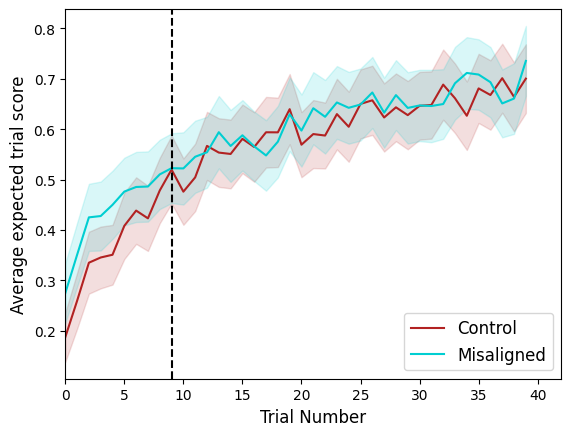

In [33]:
# Plotting mean expected score vs. trial number for each condition

data_to_copy = filtered_data.copy() # all_trials_df, outliers_excluded, or outliers_excluded_part

# If master switch is not turned on, select which data to use for this analysis
data_to_use = "all" # "1", "2", or "all"
data_to_use = data_to_use_master

conditions = {
    0: "control",
    1: "misaligned"
}

# Which metric to use for performance
performance_metric = "expectedScores"
optimal_env_score = {
    "control": 55.89,
    "misaligned": 52.14
}

scale_by_optimal = True

scaling_factor = optimal_env_score if scale_by_optimal else {k: 1 for k in optimal_env_score.keys()}

num_parts = {}
performance_data = {}

# For all conditions
# Find the number of participants, mean value of performance metric for each trial, 
#   and the standard error of the mean for each trial
for idx, cond in conditions.items():
    nump = len(data_to_copy.loc[data_to_copy.condition == idx].groupby('workerId'))
    num_parts[cond] = nump
    performance_data[cond] = {
        "mean": np.array(data_to_copy.loc[data_to_copy.condition == idx].groupby('trialNumbers').mean(numeric_only=True)[performance_metric]) / scaling_factor[cond],
        "se": np.array(data_to_copy.loc[data_to_copy.condition == idx].groupby('trialNumbers').std(numeric_only=True)[performance_metric]) / (np.sqrt(nump) * scaling_factor[cond])
    }

plot_se = True

plot_conds = ["control", "misaligned"]

color_list = ["orange", "darkturquoise", "firebrick"]

cond_colors = {"misaligned": "darkturquoise", "control": "firebrick"}
cond_partition = 9

plt.figure()
#plt.title("Learning Curves over All Trials")

for idx,cond in enumerate(plot_conds):
    plt.plot(list(range(len(performance_data[cond]["mean"]))), performance_data[cond]["mean"], label=cond[0].upper() + cond[1:], color=cond_colors[cond])
    if plot_se:
        plt.fill_between(list(range(len(performance_data[cond]["mean"]))), performance_data[cond]["mean"] + 1.96*performance_data[cond]["se"], performance_data[cond]["mean"] - 1.96*performance_data[cond]["se"], alpha=0.15, color=cond_colors[cond])
    #plt.axhline(optimal_env_score[cond]/scaling_factor[cond], color="black", linestyle="-.")
plt.axvline(cond_partition, linestyle='--', color="black")
#plt.axvline(9, linestyle='--', color='firebrick')


plt.legend(loc="lower right",prop={'size':12})
#plt.ylim([10,60])
plt.xlim([0, 42])
plt.xlabel("Trial Number",fontsize=12)
plt.ylabel("Average expected trial score",fontsize=12)
plt.show()



## Actual Scores

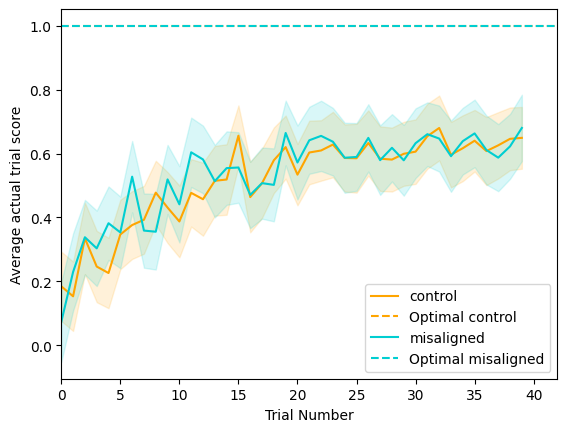

In [34]:
# Plotting mean expected score vs. trial number for each condition

data_to_copy = filtered_data.copy() # all_trials_df, outliers_excluded, or outliers_excluded_part

# If master switch is not turned on, select which data to use for this analysis
data_to_use = data_to_use_master

conditions = {
    0: "control",
    1: "misaligned"
}

# Which metric to use for performance
performance_metric = "trialScores"

optimal_env_score = {
    "control": 55.89,
    "misaligned": 52.14
}

scale_by_optimal = True

scaling_factor = optimal_env_score if scale_by_optimal else {k: 1 for k in optimal_env_score.keys()}

num_parts = {}
performance_data = {}

# For all conditions
# Find the number of participants, mean value of performance metric for each trial, 
#   and the standard error of the mean for each trial
for idx, cond in conditions.items():
    nump = len(data_to_copy.loc[data_to_copy.condition == idx].groupby('workerId'))
    num_parts[cond] = nump
    performance_data[cond] = {
        "mean": np.array(data_to_copy.loc[data_to_copy.condition == idx].groupby('trialNumbers').mean(numeric_only=True)[performance_metric]) / scaling_factor[cond],
        "se": np.array(data_to_copy.loc[data_to_copy.condition == idx].groupby('trialNumbers').std(numeric_only=True)[performance_metric]) / (np.sqrt(nump) * scaling_factor[cond])
    }

plot_se = True

plot_conds = ["control", "misaligned"]

color_list = ["orange", "darkturquoise", "firebrick"]

plt.figure()
#plt.title("Learning Curves over All Trials")

for idx,cond in enumerate(plot_conds):
    plt.plot(list(range(len(performance_data[cond]["mean"]))), performance_data[cond]["mean"], label=cond, color=color_list[idx])
    if plot_se:
        plt.fill_between(list(range(len(performance_data[cond]["mean"]))), performance_data[cond]["mean"] + 1.96*performance_data[cond]["se"], performance_data[cond]["mean"] - 1.96*performance_data[cond]["se"], alpha=0.15, color=color_list[idx])
    plt.axhline(optimal_env_score[cond]/scaling_factor[cond], color=color_list[idx], label=f"Optimal {cond}", linestyle="--")

#plt.axvline(13, linestyle='--', color='darkturquoise')
#plt.axvline(9, linestyle='--', color='firebrick')
#plt.axhline(optimal_env_score, color='k', label='Optimal', linestyle="--")
plt.legend(loc="lower right")
#plt.ylim([10,60])
plt.xlim([0, 42])
plt.xlabel("Trial Number")
plt.ylabel("Average actual trial score")
plt.show()



## Clicks

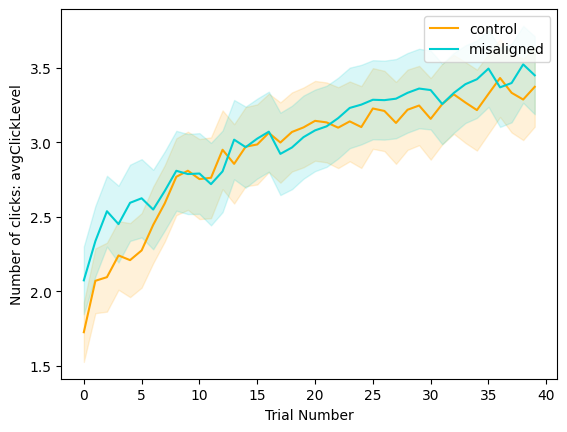

In [35]:
# Plotting mean expected score vs. trial number for each condition

data_to_copy = filtered_data.copy() # all_trials_df, outliers_excluded, or outliers_excluded_part

# If master switch is not turned on, select which data to use for this analysis
data_to_use = "all" # "1", "2", or "all"
data_to_use = data_to_use_master

# Filter out participants whose click strategies are not valid
data_to_copy = data_to_copy.loc[data_to_copy.clickStratsValid]

conditions = {
    0: "control",
    1: "misaligned"
}

# Which metric to use for performance
performance_metric = "avgClickLevel"
optimal_env_score = 5

num_parts = {}
performance_data = {}
full_data = {}

# For all conditions
# Find the number of participants, mean value of performance metric for each trial, 
#   and the standard error of the mean for each trial
for idx, cond in conditions.items():
    nump = len(data_to_copy.loc[data_to_copy.condition == idx].groupby('workerId'))
    num_parts[cond] = nump
    performance_data[cond] = {
        "mean": np.array(data_to_copy.loc[data_to_copy.condition == idx].groupby('trialNumbers').mean(numeric_only=True)[performance_metric]),
        "se": np.array(data_to_copy.loc[data_to_copy.condition == idx].groupby('trialNumbers').std(numeric_only=True)[performance_metric]) / np.sqrt(nump)
    }
    full_data[cond] = data_to_copy.loc[data_to_copy.condition == idx]

plot_se = True

plot_conds = ["control", "misaligned"]

color_list = ["orange", "darkturquoise", "firebrick"]

plt.figure()
#plt.title("Learning Curves over All Trials")

for idx,cond in enumerate(plot_conds):
    
    #plt.hist(full_data[cond][performance_metric],label=cond, color=color_list[idx], alpha=0.5)
    #plt.scatter(full_data[cond]["trialNumbers"], full_data[cond][performance_metric], label=cond, color=color_list[idx])
    plt.plot(list(range(len(performance_data[cond]["mean"]))), performance_data[cond]["mean"], label=cond, color=color_list[idx])
    if plot_se:
        plt.fill_between(list(range(len(performance_data[cond]["mean"]))), performance_data[cond]["mean"] + 1.96*performance_data[cond]["se"], performance_data[cond]["mean"] - 1.96*performance_data[cond]["se"], alpha=0.15, color=color_list[idx])

#plt.axvline(13, linestyle='--', color='darkturquoise')
#plt.axvline(9, linestyle='--', color='firebrick')
#plt.axhline(optimal_env_score, color='k', label='Optimal', linestyle="--")
plt.legend()
#plt.ylim([10,60])
#plt.xlim([0, 42])
plt.xlabel("Trial Number")
plt.ylabel("Number of clicks: " + performance_metric)
plt.show()



## Strategy Scores

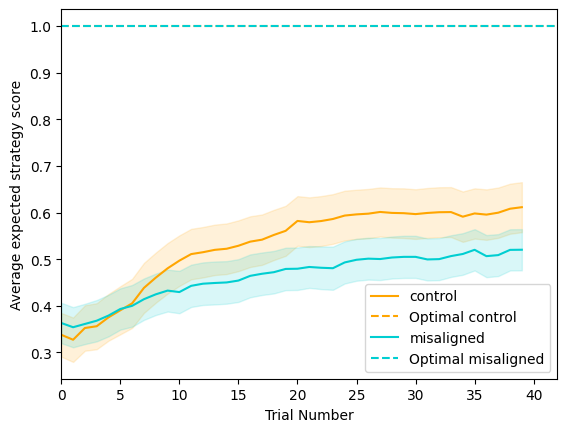

In [36]:
# Plotting mean expected score vs. trial number for each condition

data_to_copy = filtered_data.copy() # all_trials_df, outliers_excluded, or outliers_excluded_part

# If master switch is not turned on, select which data to use for this analysis
data_to_use = "all" # "1", "2", or "all"
data_to_use = data_to_use_master
    
conditions = {
    0: "control",
    1: "misaligned"
}

# Which metric to use for performance
performance_metric = "strategyScores"
optimal_env_score = {
    "control": 55.89,
    "misaligned": 52.14
}
# optimal_env_score = {
#     "control": 31.78,
#     "misaligned": 25.29
# }

scale_by_optimal = True

scaling_factor = optimal_env_score if scale_by_optimal else {k: 1 for k in optimal_env_score.keys()}

num_parts = {}
performance_data = {}

# For all conditions
# Find the number of participants, mean value of performance metric for each trial, 
#   and the standard error of the mean for each trial
for idx, cond in conditions.items():
    nump = len(data_to_copy.loc[data_to_copy.condition == idx].groupby('workerId'))
    num_parts[cond] = nump
    performance_data[cond] = {
        "mean": np.array(data_to_copy.loc[data_to_copy.condition == idx].groupby('trialNumbers').mean(numeric_only=True)[performance_metric]) / scaling_factor[cond],
        "se": np.array(data_to_copy.loc[data_to_copy.condition == idx].groupby('trialNumbers').std(numeric_only=True)[performance_metric]) / (np.sqrt(nump) * scaling_factor[cond])
    }

plot_se = True

plot_conds = ["control", "misaligned"]

color_list = ["orange", "darkturquoise", "firebrick"]

plt.figure()
#plt.title("Learning Curves over All Trials")

for idx,cond in enumerate(plot_conds):
    plt.plot(list(range(len(performance_data[cond]["mean"]))), performance_data[cond]["mean"], label=cond, color=color_list[idx])
    if plot_se:
        plt.fill_between(list(range(len(performance_data[cond]["mean"]))), performance_data[cond]["mean"] + 1.96*performance_data[cond]["se"], performance_data[cond]["mean"] - 1.96*performance_data[cond]["se"], alpha=0.15, color=color_list[idx])
    plt.axhline(optimal_env_score[cond]/scaling_factor[cond], color=color_list[idx], label=f"Optimal {cond}", linestyle="--")
#plt.axvline(13, linestyle='--', color='darkturquoise')
#plt.axvline(9, linestyle='--', color='firebrick')


plt.legend(loc="lower right")
#plt.ylim([10,60])
plt.xlim([0, 42])
plt.xlabel("Trial Number")
plt.ylabel("Average expected strategy score")
plt.show()



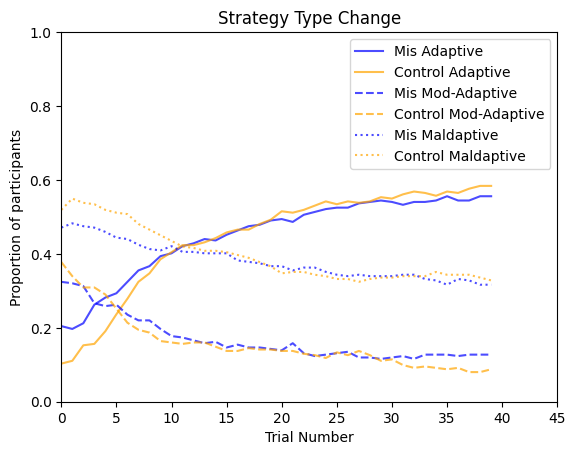

In [37]:
# Plotting Strategy cluster change

data_to_copy = filtered_data.copy() # all_trials_df, outliers_excluded, or outliers_excluded_part

# If master switch is not turned on, select which data to use for this analysis
data_to_use = "all" # "1", "2", or "all"
data_to_use = data_to_use_master

scarce_trial_group = data_to_copy.loc[data_to_copy.condition == 1].groupby('trialNumbers')
control_trial_group = data_to_copy.loc[data_to_copy.condition == 0].groupby('trialNumbers')

# Taking the mean strategy score over all trials 
scarce_data_all = np.array(scarce_trial_group.mean(numeric_only=True)["strategyScores"])
scarce_data_all_sd = np.array(scarce_trial_group.std(numeric_only=True)["strategyScores"])
control_data = np.array(control_trial_group.mean(numeric_only=True)["strategyScores"])
control_data_sd = np.array(control_trial_group.std(numeric_only=True)["strategyScores"])

# Getting the proportions of clusters
scarce_data_adaptive = np.array(scarce_trial_group["cluster"].apply(lambda x: (x==0).sum()) / scarce_trial_group["cluster"].count())
control_data_adaptive = np.array(control_trial_group["cluster"].apply(lambda x: (x==0).sum()) / control_trial_group["cluster"].count())
scarce_data_modadaptive = np.array(scarce_trial_group["cluster"].apply(lambda x: (x==1).sum()) / scarce_trial_group["cluster"].count())
control_data_modadaptive = np.array(control_trial_group["cluster"].apply(lambda x: (x==1).sum()) / control_trial_group["cluster"].count())
scarce_data_maladaptive = np.array(scarce_trial_group["cluster"].apply(lambda x: (x==2).sum()) / scarce_trial_group["cluster"].count())
control_data_maladaptive = np.array(control_trial_group["cluster"].apply(lambda x: (x==2).sum()) / control_trial_group["cluster"].count())

plt.figure()
plt.title("Strategy Type Change")
alpha = 0.7
plt.plot(list(range(len(scarce_data_all))), scarce_data_adaptive, label="Mis Adaptive", color='b',alpha=alpha)
plt.plot(list(range(len(control_data))), control_data_adaptive, label="Control Adaptive",color='orange',alpha=alpha)
plt.plot(list(range(len(scarce_data_all))), scarce_data_modadaptive, label="Mis Mod-Adaptive", color='b',alpha=alpha, linestyle="--")
plt.plot(list(range(len(control_data))), control_data_modadaptive, label="Control Mod-Adaptive",color='orange',alpha=alpha, linestyle="--")
plt.plot(list(range(len(scarce_data_all))), scarce_data_maladaptive, label="Mis Maldaptive", color='b',alpha=alpha, linestyle=":")
plt.plot(list(range(len(control_data))), control_data_maladaptive, label="Control Maldaptive",color='orange',alpha=alpha, linestyle=":")
plt.legend()
plt.ylim([0,1])
plt.xlim([0, 45])
plt.xlabel("Trial Number")
plt.ylabel("Proportion of participants")
plt.show()


# Pre-Analysis 0.1 - Transforming Response Data

Performing transformations of the data to reduce skew of residual distributions. The transformation that yields the most normal residuals for each response variable is selected

In [34]:
def scale_to_range(arr, lb, ub):
    return ((arr - arr.min()) / (arr.max() - arr.min())) * (ub - lb) + lb

In [35]:
# Selecting the response variable

response_vars = ["expectedScores", 'expectedScores_scaled', 'avgClickLevel', "clicksL1", "clicksL5", "strategyScores", 'strategyScores_scaled']

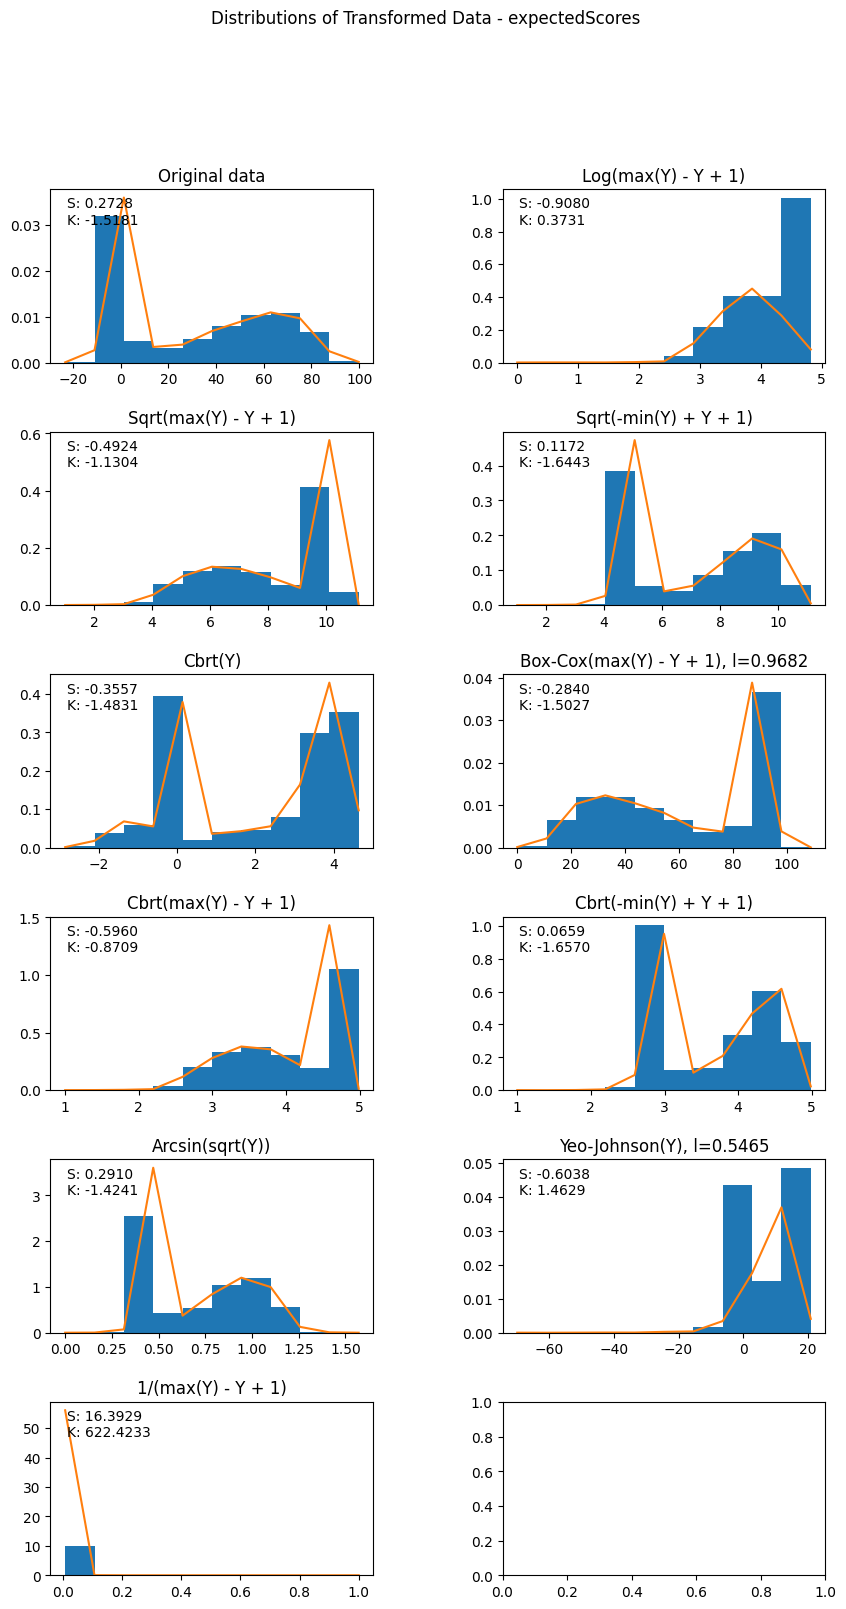

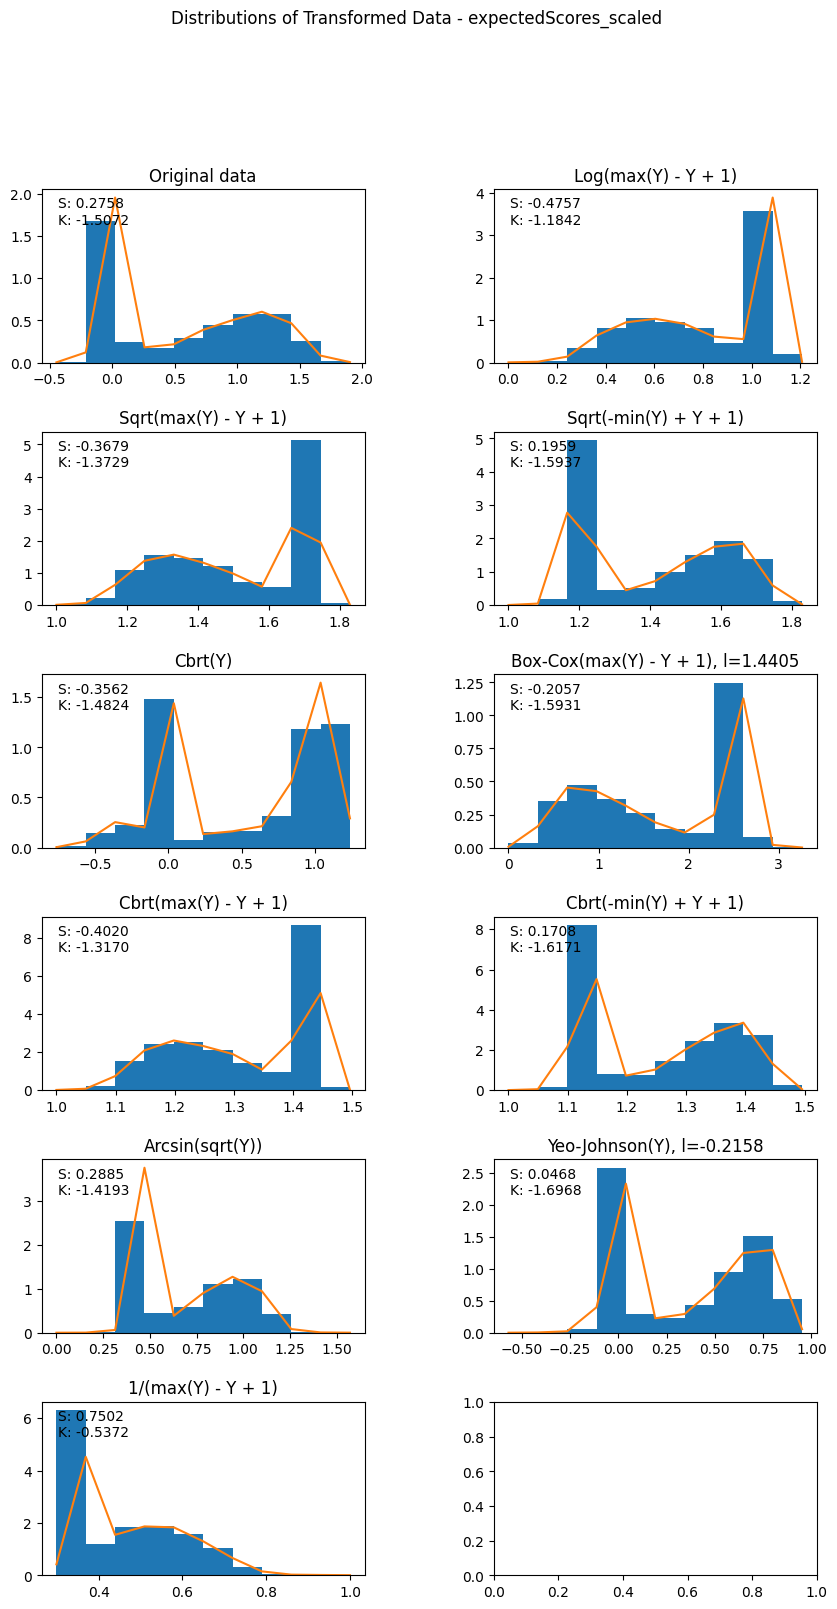

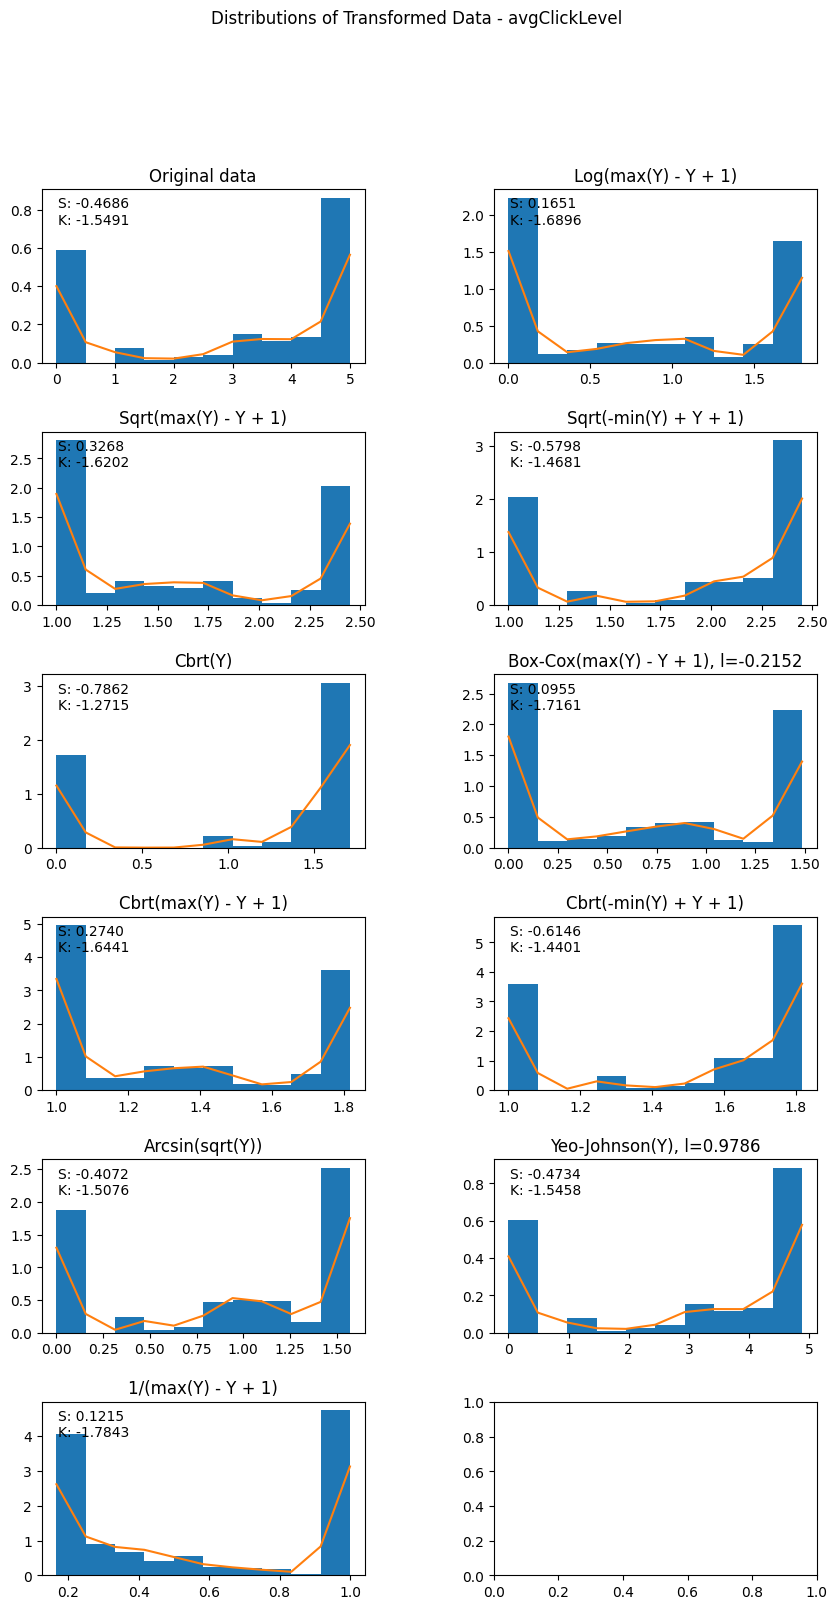

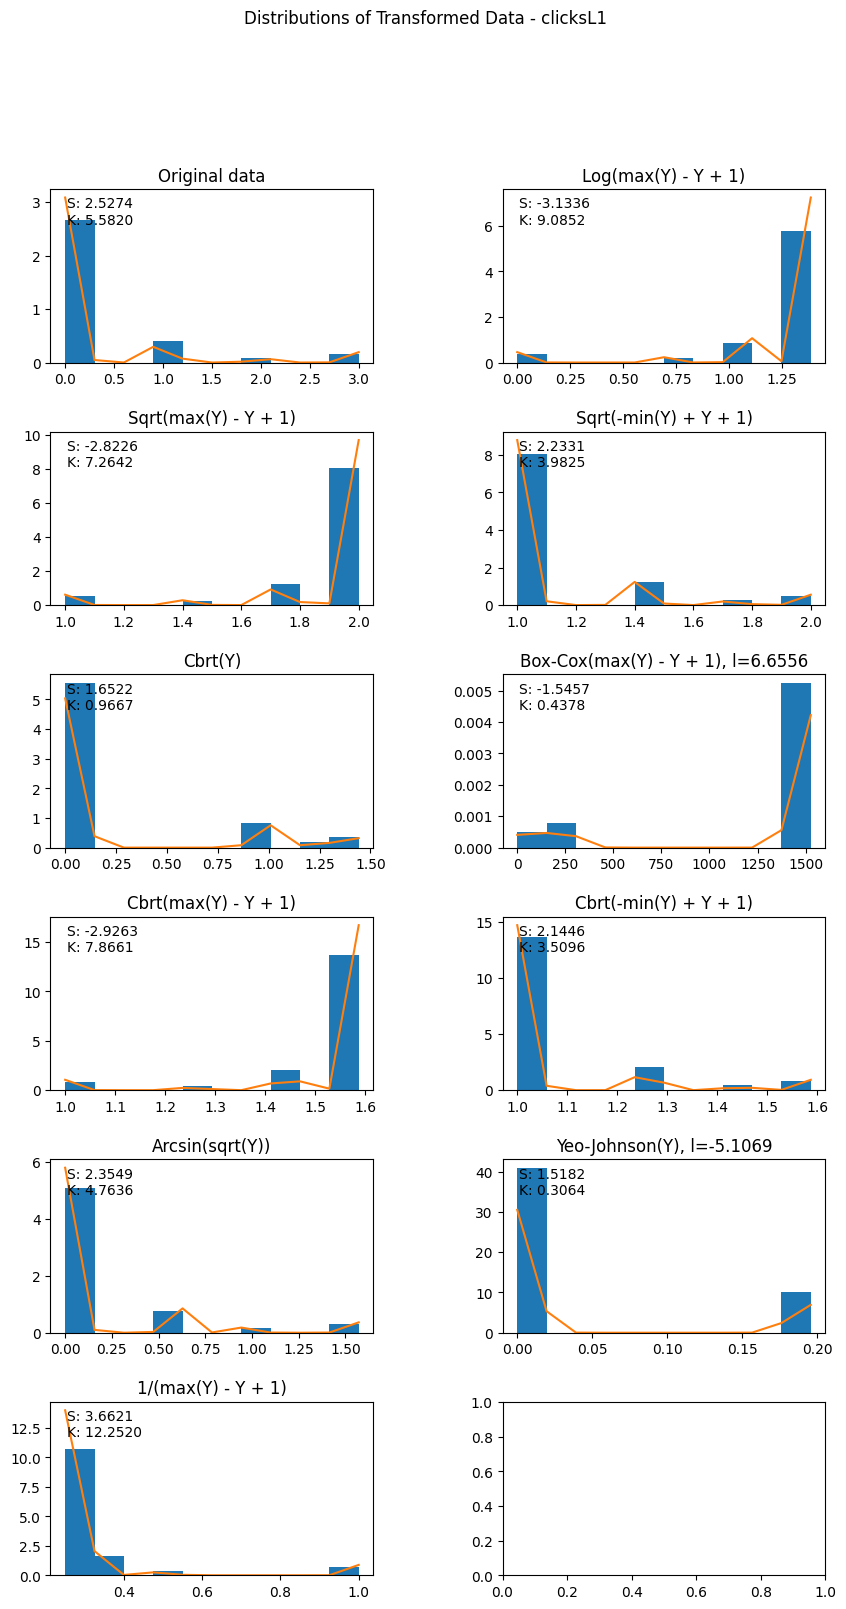

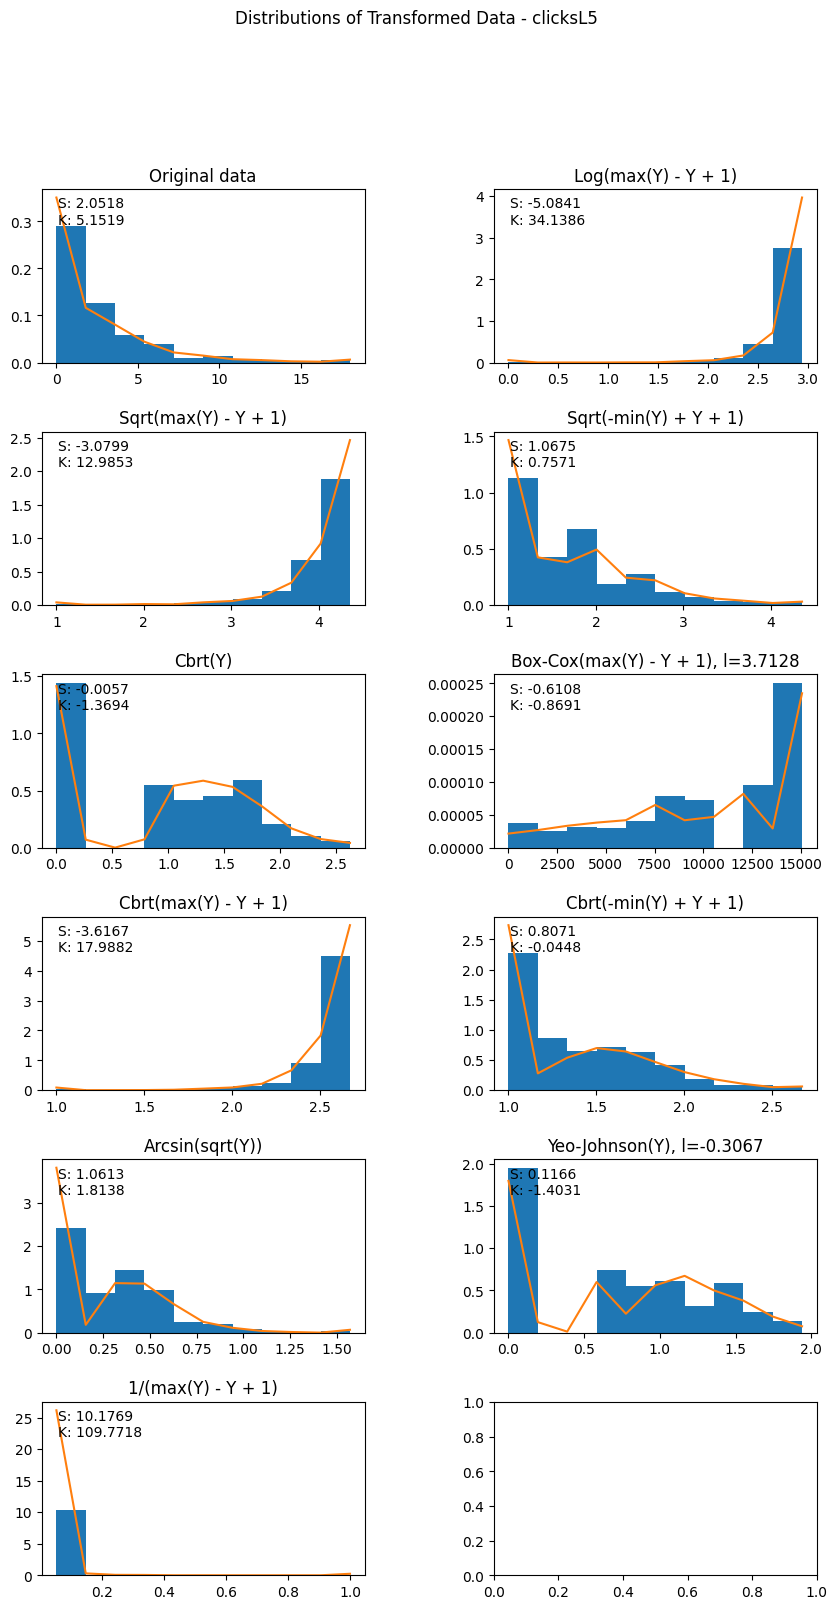

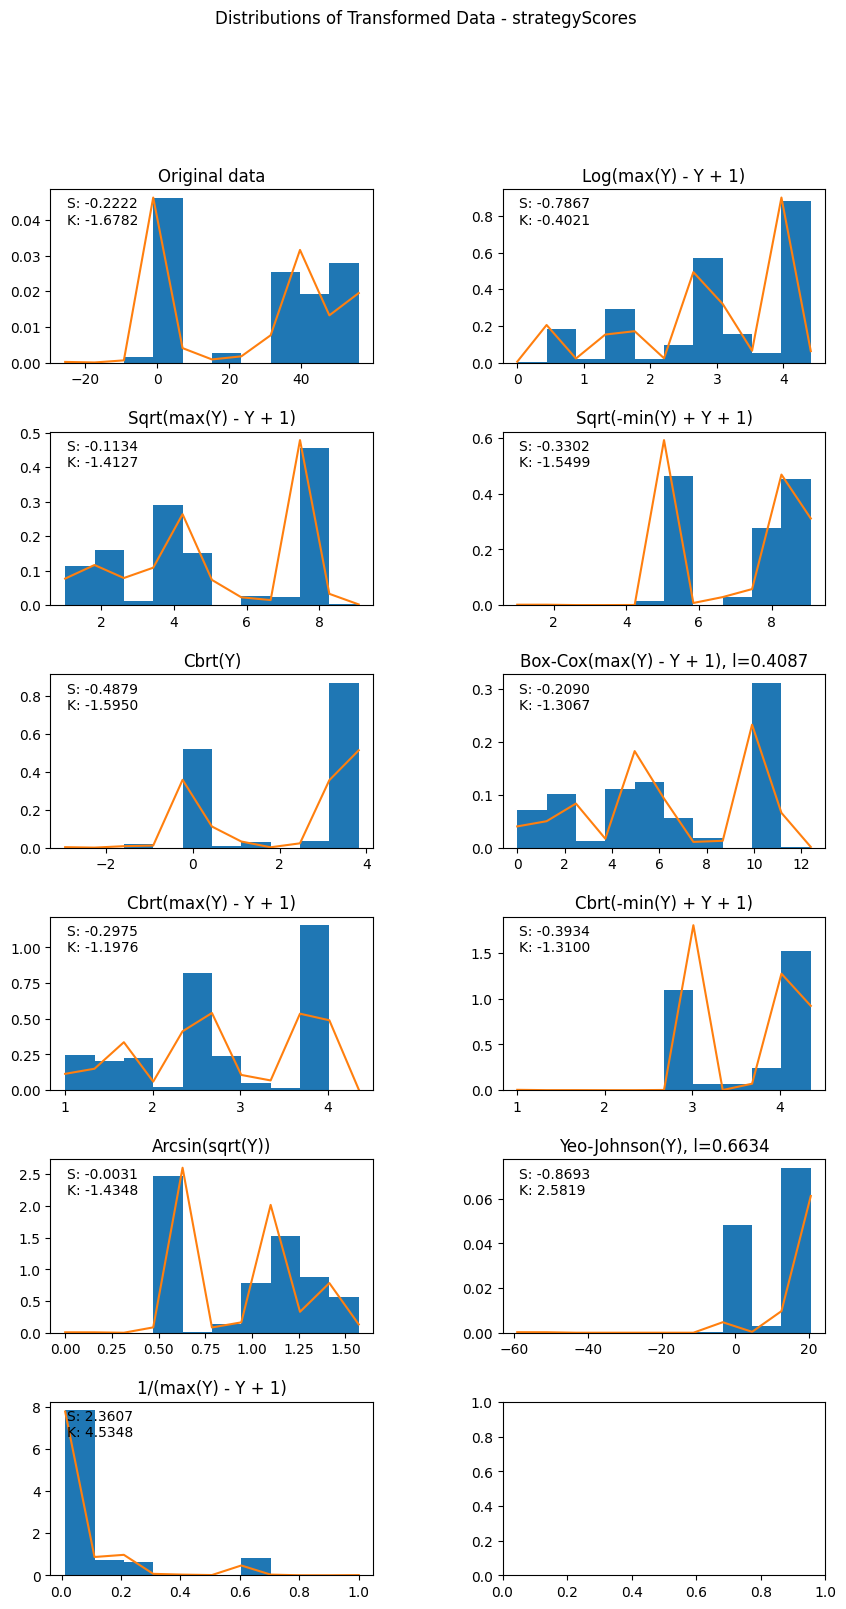

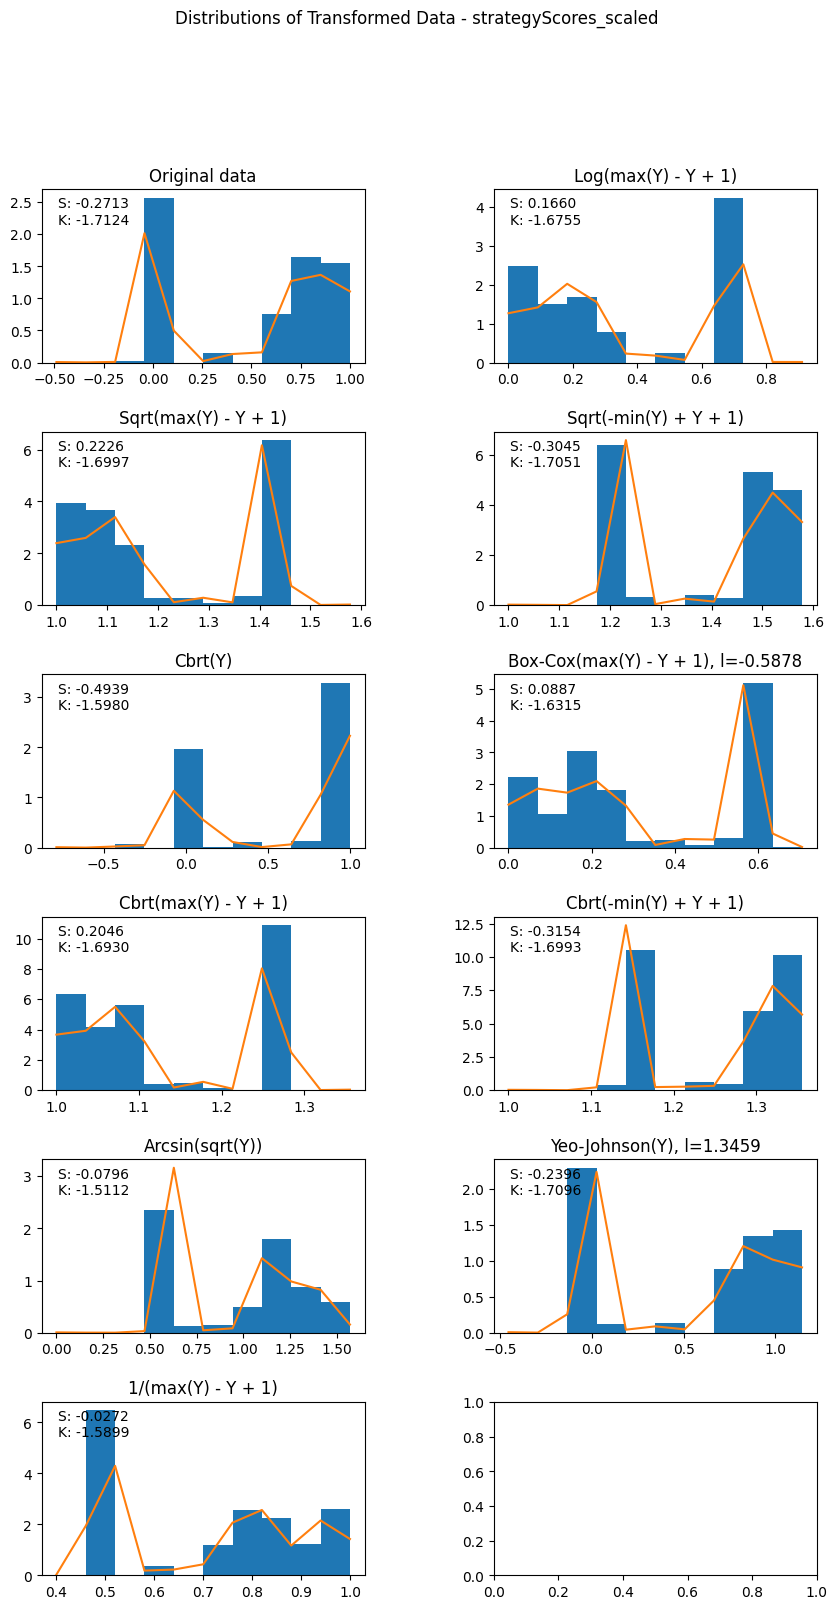

In [36]:
# Transforming the data

data_to_copy = filtered_data.copy() # or outliers_excluded

# If master switch is not turned on, select which data to use for this analysis
data_to_use = "all" # "1", "2", or "all"
data_to_use = data_to_use_master
    
transformed_trials_df = data_to_copy.copy()
trans_list = {res: [] for res in response_vars}

for response_var in response_vars:
    

    log_transformed_trials_df = data_to_copy.copy()
    sq_transformed_trials_df = data_to_copy.copy()
    sq2_transformed_trials_df = data_to_copy.copy()
    cb_transformed_trials_df = data_to_copy.copy()
    cb2_transformed_trials_df = data_to_copy.copy()
    cb3_transformed_trials_df = data_to_copy.copy()
    arcsin_transformed_trials_df = data_to_copy.copy()
    bc_transformed_trials_df = data_to_copy.copy()
    yj_transformed_trials_df = data_to_copy.copy()
    inverse_transformed_trials_df = data_to_copy.copy()

    # Compute separate dataframes for each transformation
    log_transformed_trials_df[response_var] = np.log(transformed_trials_df[response_var].max() + 1 - transformed_trials_df[response_var])
    sq_transformed_trials_df[response_var] = np.sqrt(transformed_trials_df[response_var].max() + 1 - transformed_trials_df[response_var])
    sq2_transformed_trials_df[response_var] = np.sqrt(-transformed_trials_df[response_var].min() + 1 + transformed_trials_df[response_var])
    cb_transformed_trials_df[response_var] = np.cbrt(transformed_trials_df[response_var])
    cb2_transformed_trials_df[response_var] = np.cbrt(transformed_trials_df[response_var].max() + 1 - transformed_trials_df[response_var])
    cb3_transformed_trials_df[response_var] = np.cbrt(-transformed_trials_df[response_var].min() + 1 + transformed_trials_df[response_var])
    arcsin_transformed_trials_df[response_var] = np.arcsin(np.sqrt(scale_to_range(transformed_trials_df[response_var], 0, 1)))
    bc_transformed_trials_df[response_var],lam = scipy.stats.boxcox(transformed_trials_df[response_var].max() + 1 - transformed_trials_df[response_var])
    #logit_transformed_trials_df[response_var] = scipy.special.logit(scale_to_range(transformed_trials_df[response_var], 0, 1))
    yj_transformed_trials_df[response_var],lam_y = scipy.stats.yeojohnson(transformed_trials_df[response_var])
    inverse_transformed_trials_df[response_var] = 1/(transformed_trials_df[response_var].max() + 1 - transformed_trials_df[response_var])

    # All the transformed data and the corresponding transformation
    trans_list[response_var] = [
        (transformed_trials_df, "Original data"),
        (log_transformed_trials_df, "Log(max(Y) - Y + 1)"),
        (sq_transformed_trials_df, "Sqrt(max(Y) - Y + 1)"),
        (sq2_transformed_trials_df, "Sqrt(-min(Y) + Y + 1)"),
        (cb_transformed_trials_df, "Cbrt(Y)"),
        (bc_transformed_trials_df, "Box-Cox(max(Y) - Y + 1), l={0:0.4f}".format(lam)),
        (cb2_transformed_trials_df, "Cbrt(max(Y) - Y + 1)"),
        (cb3_transformed_trials_df, "Cbrt(-min(Y) + Y + 1)"),
        (arcsin_transformed_trials_df, "Arcsin(sqrt(Y))"),
        (yj_transformed_trials_df, "Yeo-Johnson(Y), l={0:0.4f}".format(lam_y)),
        (inverse_transformed_trials_df, "1/(max(Y) - Y + 1)")
    ]
    
    # Plot all the transformed data
    fig, ax = plt.subplots(nrows=math.ceil(len(trans_list[response_var])/2),ncols=2,figsize=(10, 3 * math.ceil(len(trans_list[response_var])/2)),squeeze=False)
    plt.suptitle("Distributions of Transformed Data - {}".format(response_var))
    ax = ax.flatten()

    for idx, trans in enumerate(trans_list[response_var]):
        data = trans[0][response_var]
        label = trans[1]
        skew = scipy.stats.skew(data)
        density = scipy.stats.gaussian_kde(data)
        kurtosis = scipy.stats.kurtosis(data)
        n, x, _ = ax[idx].hist(data, density=True)
        ax[idx].set_title(label)
        ax[idx].plot(x, density(x))
        ax[idx].text(0.05,0.8, "S: {0:0.4f}\nK: {1:0.4f}".format(skew, kurtosis), transform=ax[idx].transAxes)

    plt.subplots_adjust(
                    wspace=0.4, 
                    hspace=0.4)
plt.show()

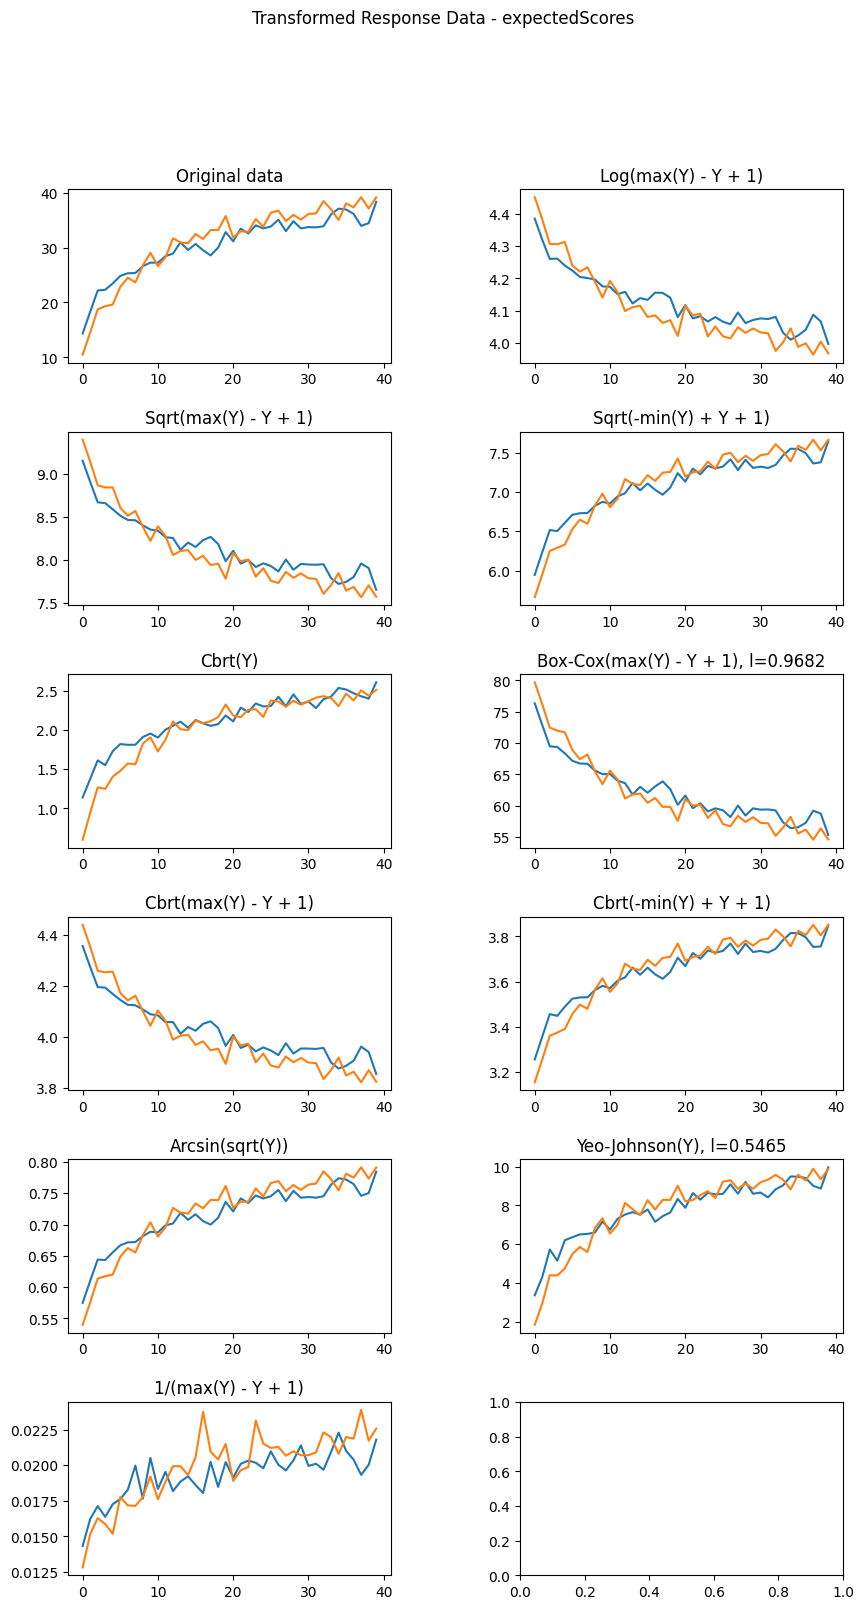

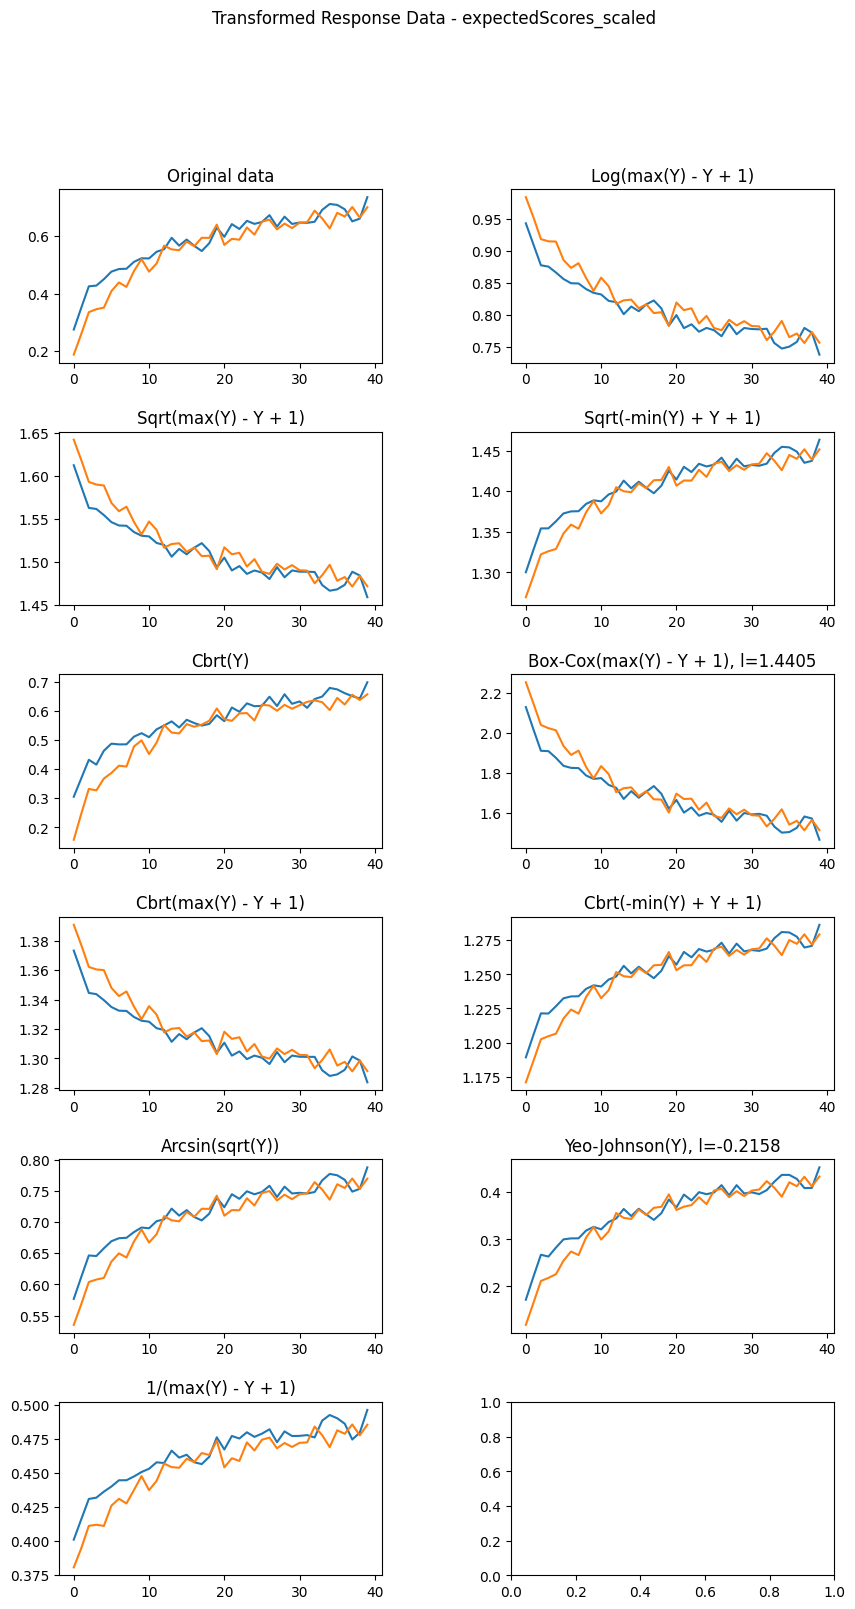

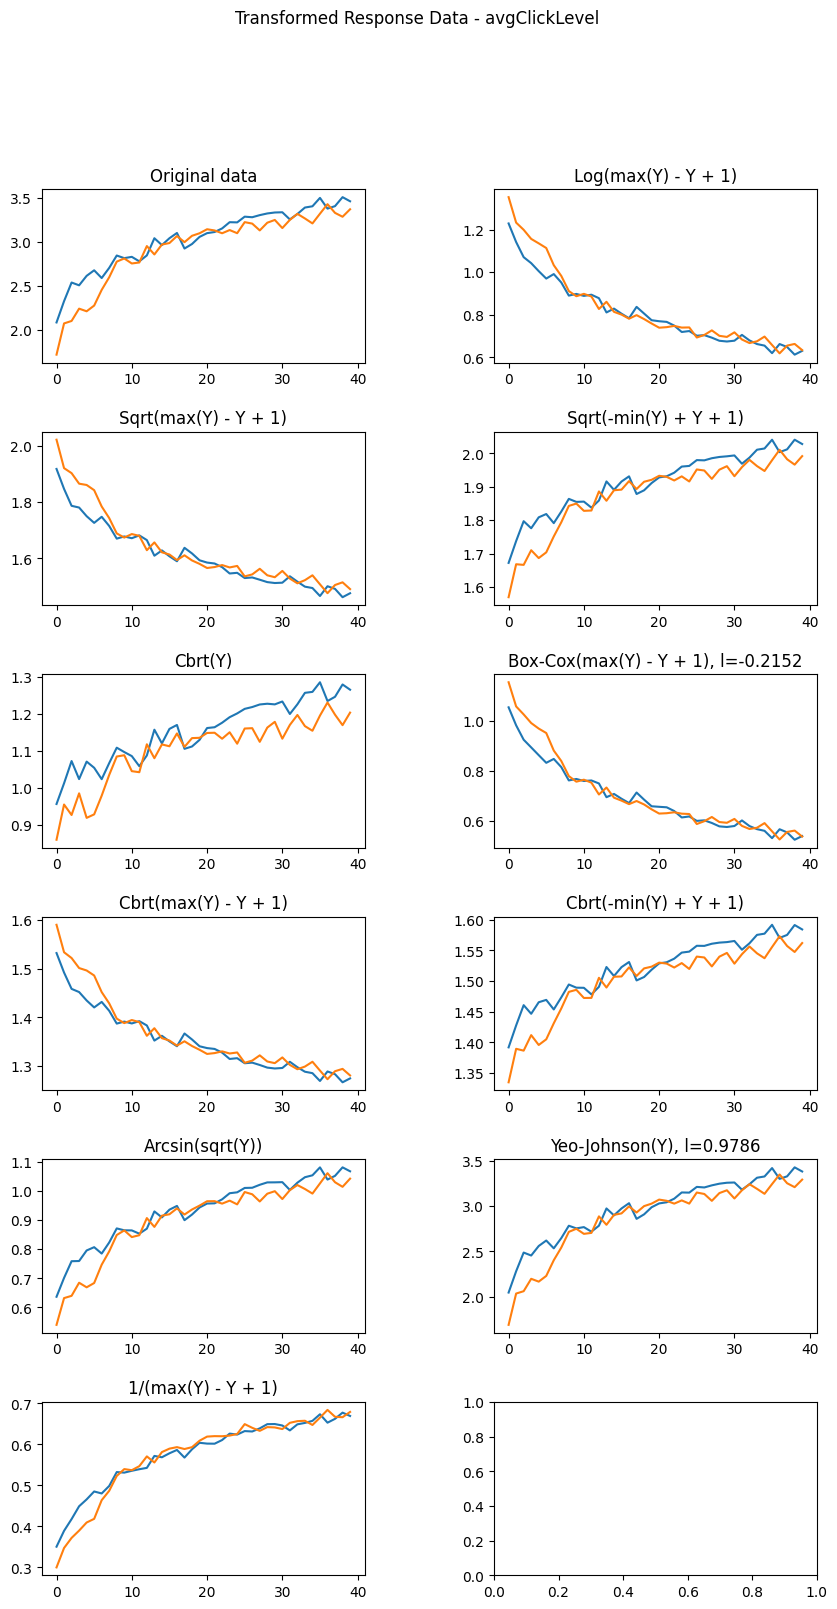

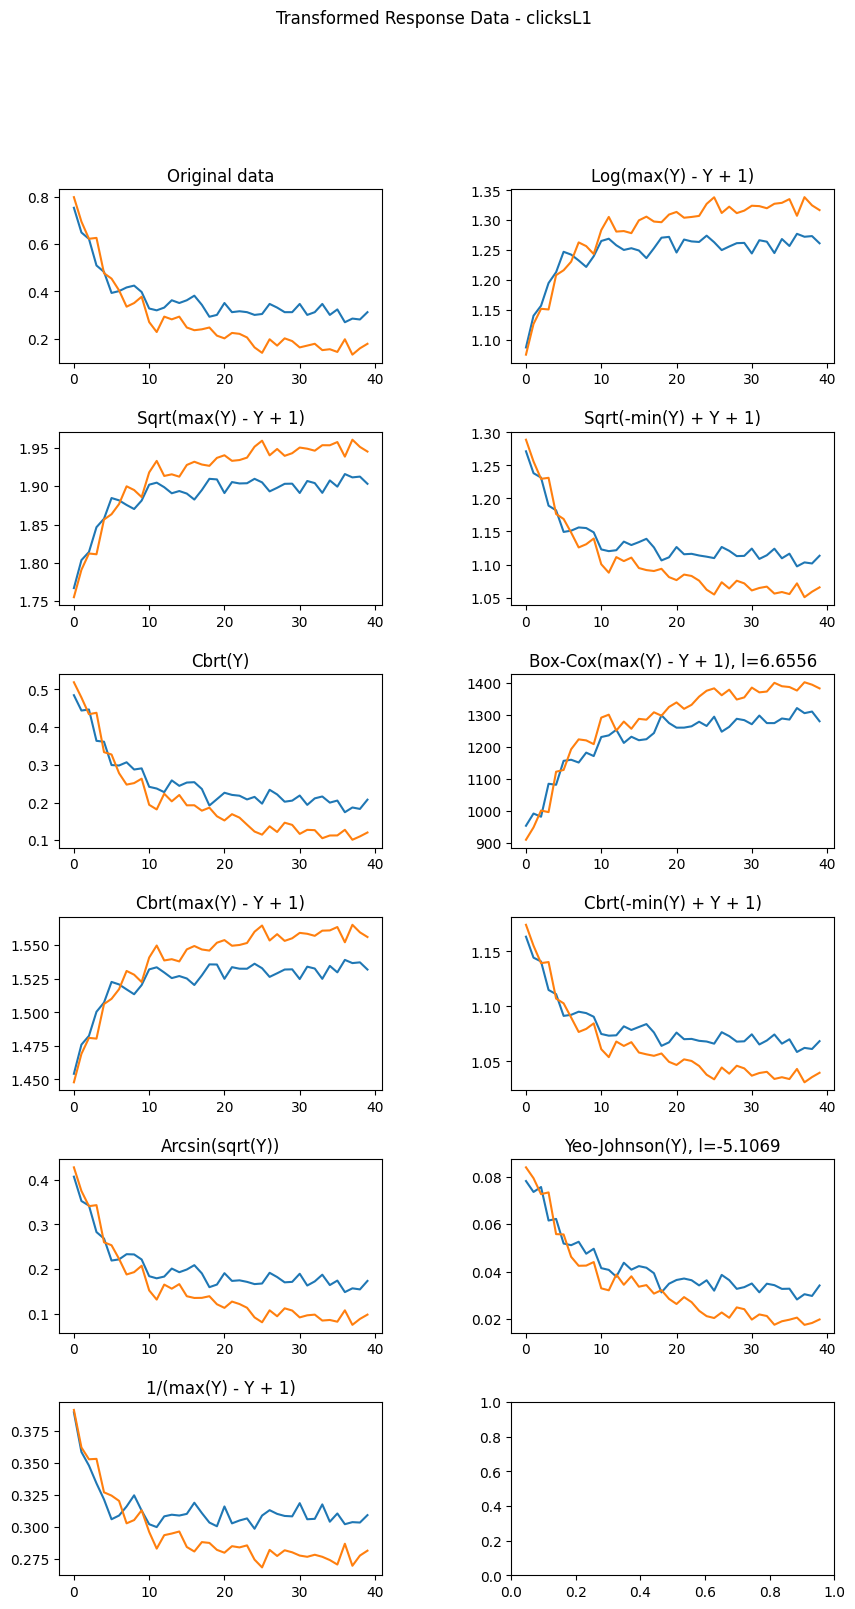

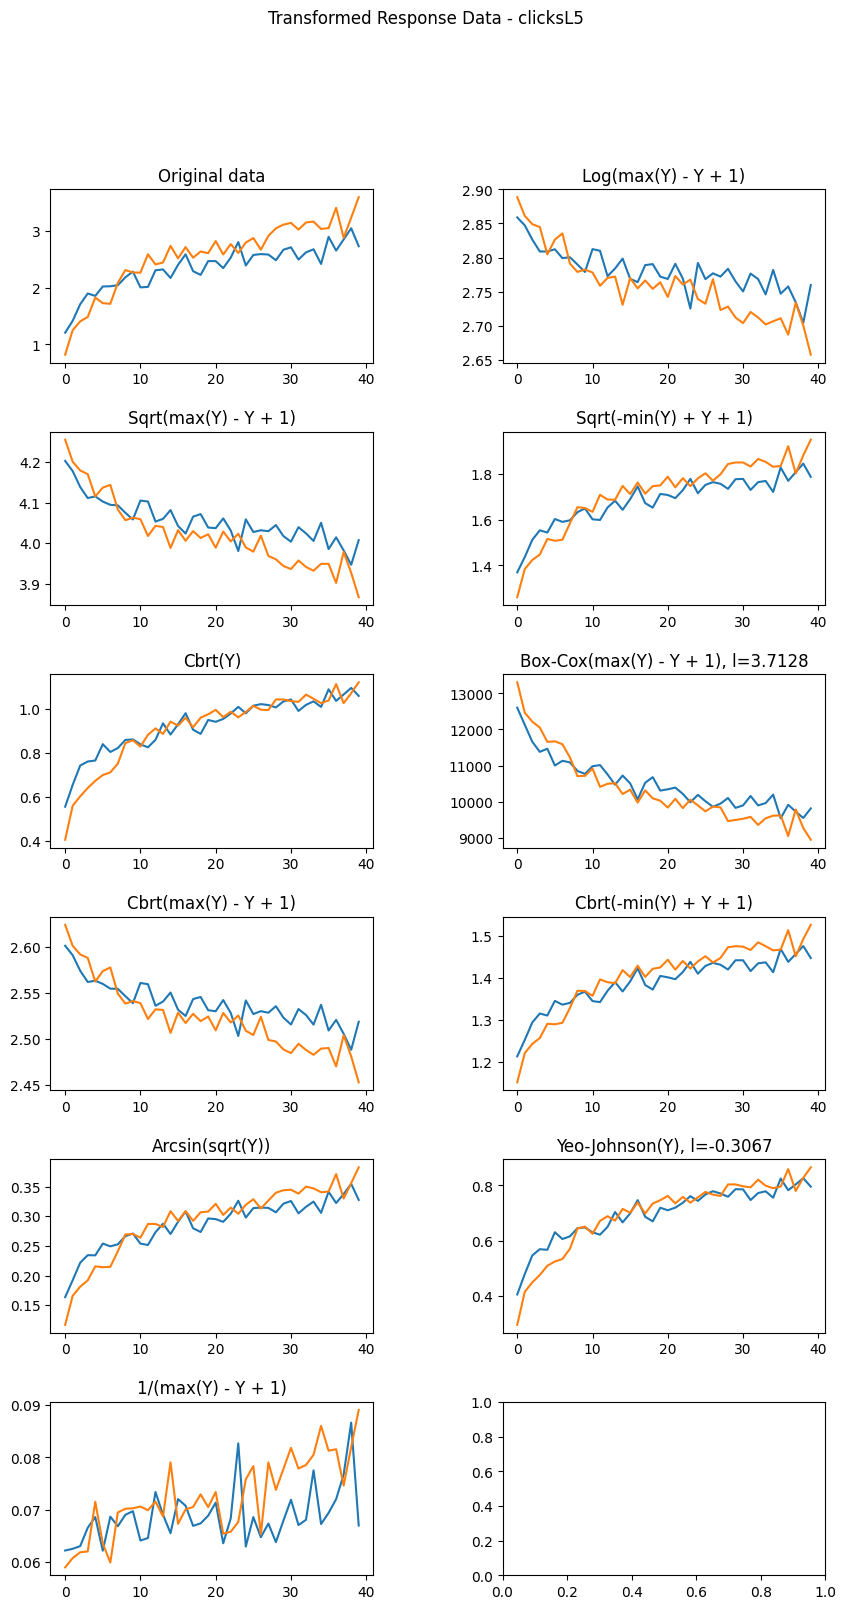

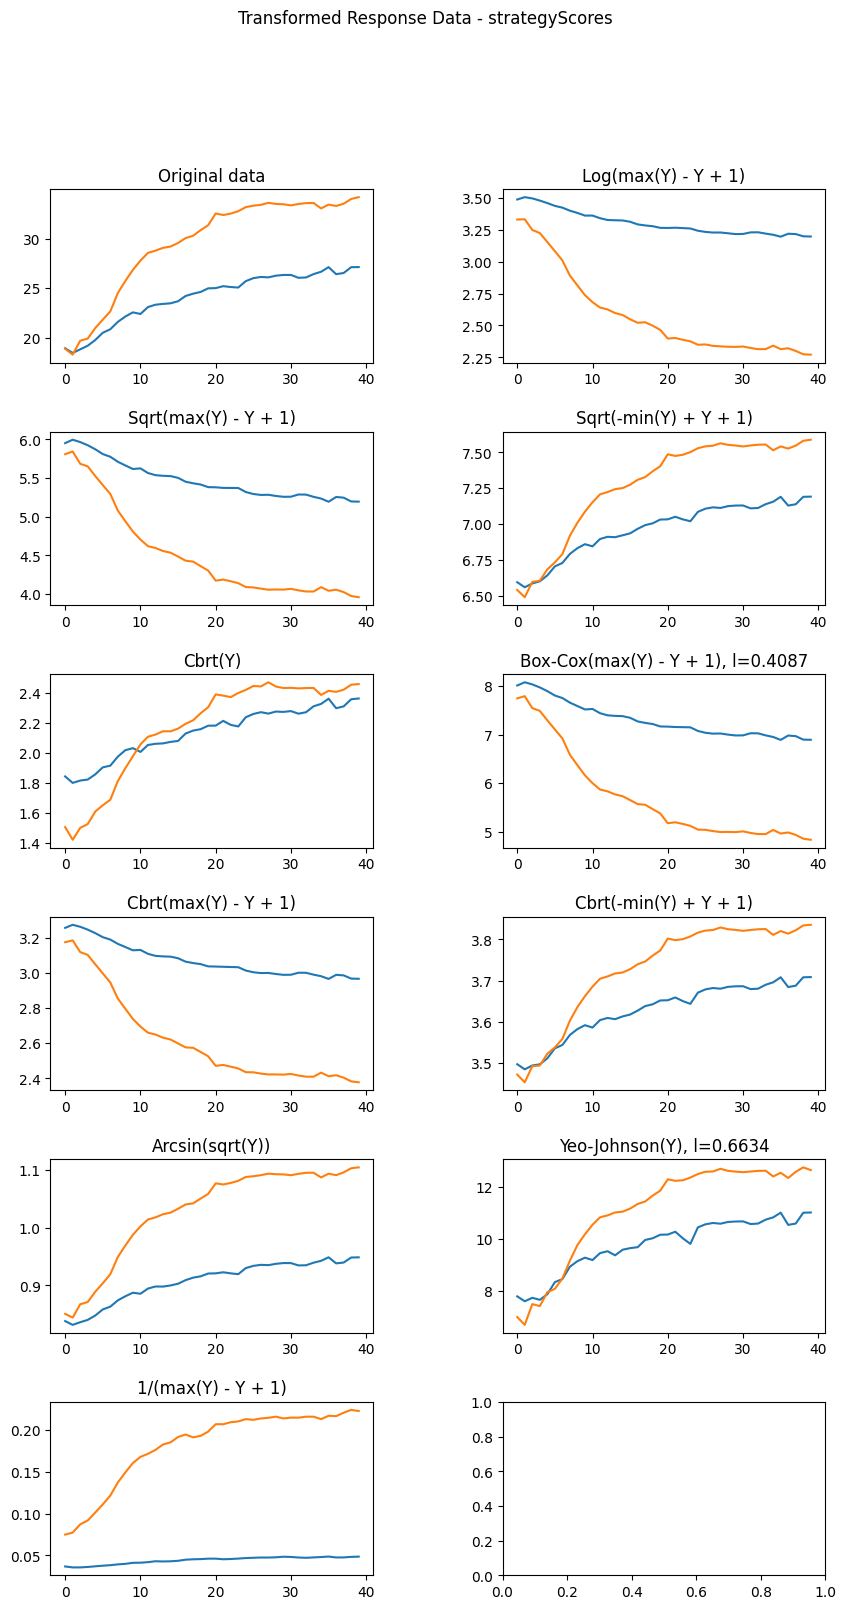

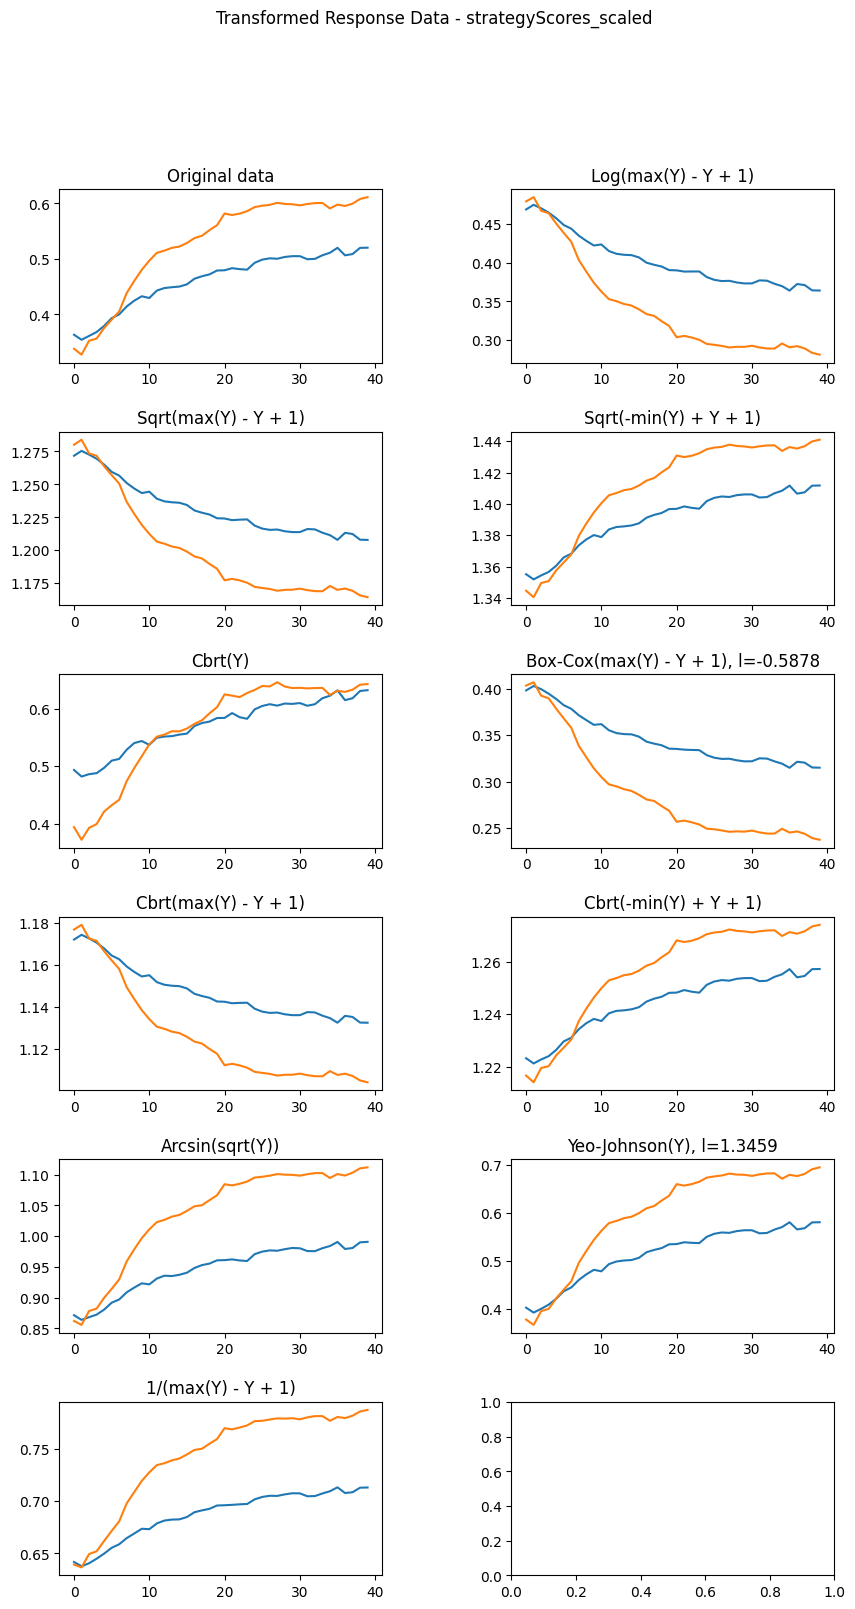

In [37]:
# Plotting the response data

for response_var in response_vars:
    fig, ax = plt.subplots(nrows=math.ceil(len(trans_list[response_var])/2),ncols=2,figsize=(10, 3 * math.ceil(len(trans_list[response_var])/2)),squeeze=False)
    plt.suptitle("Transformed Response Data - {}".format(response_var))
    ax = ax.flatten()

    for idx, trans in enumerate(trans_list[response_var]):
        data = trans[0]
        scarce = data.loc[data.condition == 1]
        control = data.loc[data.condition == 0]
        label = trans[1]

        scarce_mean = np.array(scarce.groupby('trialNumbers').mean(numeric_only=True)[response_var])
        control_mean = np.array(control.groupby('trialNumbers').mean(numeric_only=True)[response_var])
        ax[idx].plot(list(range(len(scarce_mean))), scarce_mean, label="Exp")
        ax[idx].plot(list(range(len(control_mean))), control_mean, label="Control")
        ax[idx].set_title(label)

    plt.subplots_adjust(
                    wspace=0.4, 
                    hspace=0.4)
plt.show()

## Linear Regression: Expected Score vs. Trial Number x Condition

In [38]:
# formula = "expectedScores ~ trialNumbers + C(scarce) + trialNumbers:C(scarce)"

In [39]:
# GLM Model 1 - Expected score vs. Trial number & Condition - all possible transformations

# Creating the list of data to subplot all residuals

all_residuals = {res: [] for res in response_vars}
mixed = True

for response_var in response_vars:
    formula = '{} ~ C(trialNumbers) + C(condition)'.format(response_var);

    # Perform regression on each transformed dataset
    for idx, trans in enumerate(trans_list[response_var]):
        if mixed:
            glm = smf.mixedlm(formula=formula, data=trans[0], groups=trans[0]['workerId'])
        else:
            glm = smf.glm(formula=formula, data=trans[0])

        results = glm.fit()

        print("\n{} - {}:".format(response_var, trans[1]))
        print(results.summary())

        resids = results.resid_response if not mixed else results.resid
        normaltest = scipy.stats.normaltest(resids)
        
        # Save the results of the regression for plotting
        all_residuals[response_var].append((
            resids,
            trans[0][response_var],
            trans[1],
            normaltest
        ))



expectedScores - Original data:
              Mixed Linear Model Regression Results
Model:               MixedLM  Dependent Variable:  expectedScores
No. Observations:    20840    Method:              REML          
No. Groups:          521      Scale:               448.4816      
Min. group size:     40       Log-Likelihood:      -94114.7183   
Max. group size:     40       Converged:           Yes           
Mean group size:     40.0                                        
-----------------------------------------------------------------
                       Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------
Intercept              12.737    1.634  7.793 0.000  9.534 15.940
C(trialNumbers)[T.2]    3.994    1.312  3.044 0.002  1.422  6.565
C(trialNumbers)[T.3]    8.046    1.312  6.132 0.000  5.474 10.617
C(trialNumbers)[T.4]    8.404    1.312  6.405 0.000  5.832 10.976
C(trialNumbers)[T.5]    9.132    1.312  6.960 0.000  6.56


expectedScores - Sqrt(-min(Y) + Y + 1):
             Mixed Linear Model Regression Results
Model:              MixedLM  Dependent Variable:  expectedScores
No. Observations:   20840    Method:              REML          
No. Groups:         521      Scale:               2.0214        
Min. group size:    40       Log-Likelihood:      -37961.0202   
Max. group size:    40       Converged:           Yes           
Mean group size:    40.0                                        
----------------------------------------------------------------
                      Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------
Intercept              5.817    0.114 51.238 0.000  5.595  6.040
C(trialNumbers)[T.2]   0.288    0.088  3.274 0.001  0.116  0.461
C(trialNumbers)[T.3]   0.579    0.088  6.574 0.000  0.406  0.752
C(trialNumbers)[T.4]   0.593    0.088  6.731 0.000  0.420  0.766
C(trialNumbers)[T.5]   0.665    0.088  7.555 0.000  0.493  0.83


expectedScores - Cbrt(max(Y) - Y + 1):
              Mixed Linear Model Regression Results
Model:               MixedLM  Dependent Variable:  expectedScores
No. Observations:    20840    Method:              REML          
No. Groups:          521      Scale:               0.2503        
Min. group size:     40       Log-Likelihood:      -16153.0285   
Max. group size:     40       Converged:           Yes           
Mean group size:     40.0                                        
-----------------------------------------------------------------
                      Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-----------------------------------------------------------------
Intercept              4.387    0.036 122.368 0.000  4.317  4.458
C(trialNumbers)[T.2]  -0.084    0.031  -2.711 0.007 -0.145 -0.023
C(trialNumbers)[T.3]  -0.171    0.031  -5.515 0.000 -0.232 -0.110
C(trialNumbers)[T.4]  -0.175    0.031  -5.652 0.000 -0.236 -0.114
C(trialNumbers)[T.5]  -0.186    0.031  -6.009 0.00


expectedScores - Yeo-Johnson(Y), l=0.5465:
             Mixed Linear Model Regression Results
Model:              MixedLM  Dependent Variable:  expectedScores
No. Observations:   20840    Method:              REML          
No. Groups:         521      Scale:               35.1229       
Min. group size:    40       Log-Likelihood:      -67586.7234   
Max. group size:    40       Converged:           Yes           
Mean group size:    40.0                                        
----------------------------------------------------------------
                      Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------
Intercept              2.583    0.434  5.948 0.000  1.732  3.434
C(trialNumbers)[T.2]   1.026    0.367  2.794 0.005  0.306  1.746
C(trialNumbers)[T.3]   2.466    0.367  6.716 0.000  1.746  3.186
C(trialNumbers)[T.4]   2.172    0.367  5.915 0.000  1.452  2.892
C(trialNumbers)[T.5]   2.882    0.367  7.848 0.000  2.162  3

/Volumes/DataDrive/mcl-misalignment-mouselab/analysis/aenv/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)



expectedScores - 1/(max(Y) - Y + 1):
             Mixed Linear Model Regression Results
Model:              MixedLM  Dependent Variable:  expectedScores
No. Observations:   20840    Method:              REML          
No. Groups:         521      Scale:               0.0003        
Min. group size:    40       Log-Likelihood:      55009.1051    
Max. group size:    40       Converged:           Yes           
Mean group size:    40.0                                        
----------------------------------------------------------------
                      Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------
Intercept              0.014    0.001 16.188 0.000  0.012  0.016
C(trialNumbers)[T.2]   0.002    0.001  2.047 0.041  0.000  0.004
C(trialNumbers)[T.3]   0.003    0.001  3.035 0.002  0.001  0.005
C(trialNumbers)[T.4]   0.003    0.001  2.469 0.014  0.001  0.005
C(trialNumbers)[T.5]   0.003    0.001  2.565 0.010  0.001  0.005
C


expectedScores_scaled - Sqrt(max(Y) - Y + 1):
               Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: expectedScores_scaled
No. Observations: 20840   Method:             REML                 
No. Groups:       521     Scale:              0.0183               
Min. group size:  40      Log-Likelihood:     11026.8574           
Max. group size:  40      Converged:          Yes                  
Mean group size:  40.0                                             
-------------------------------------------------------------------
                        Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-------------------------------------------------------------------
Intercept                1.632    0.010 160.656 0.000  1.612  1.652
C(trialNumbers)[T.2]    -0.024    0.008  -2.900 0.004 -0.041 -0.008
C(trialNumbers)[T.3]    -0.049    0.008  -5.886 0.000 -0.066 -0.033
C(trialNumbers)[T.4]    -0.051    0.008  -6.146 0.000 -0.068 -0.035
C(trialNumbers)[


expectedScores_scaled - Box-Cox(max(Y) - Y + 1), l=1.4405:
               Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: expectedScores_scaled
No. Observations: 20840   Method:             REML                 
No. Groups:       521     Scale:              0.3056               
Min. group size:  40      Log-Likelihood:     -18299.9109          
Max. group size:  40      Converged:          Yes                  
Mean group size:  40.0                                             
-------------------------------------------------------------------
                        Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-------------------------------------------------------------------
Intercept                2.209    0.043  51.007 0.000  2.124  2.293
C(trialNumbers)[T.2]    -0.108    0.034  -3.150 0.002 -0.175 -0.041
C(trialNumbers)[T.3]    -0.216    0.034  -6.301 0.000 -0.283 -0.149
C(trialNumbers)[T.4]    -0.225    0.034  -6.561 0.000 -0.292 -0.158
C(t

/Volumes/DataDrive/mcl-misalignment-mouselab/analysis/aenv/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)



expectedScores_scaled - Cbrt(max(Y) - Y + 1):
               Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: expectedScores_scaled
No. Observations: 20840   Method:             REML                 
No. Groups:       521     Scale:              0.0064               
Min. group size:  40      Log-Likelihood:     22003.2497           
Max. group size:  40      Converged:          Yes                  
Mean group size:  40.0                                             
-------------------------------------------------------------------
                        Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-------------------------------------------------------------------
Intercept                1.385    0.006 232.947 0.000  1.373  1.397
C(trialNumbers)[T.2]    -0.014    0.005  -2.854 0.004 -0.024 -0.004
C(trialNumbers)[T.3]    -0.029    0.005  -5.806 0.000 -0.038 -0.019
C(trialNumbers)[T.4]    -0.030    0.005  -6.061 0.000 -0.040 -0.020
C(trialNumbers)[

/Volumes/DataDrive/mcl-misalignment-mouselab/analysis/aenv/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)



expectedScores_scaled - Cbrt(-min(Y) + Y + 1):
               Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: expectedScores_scaled
No. Observations: 20840   Method:             REML                 
No. Groups:       521     Scale:              0.0064               
Min. group size:  40      Log-Likelihood:     21842.0216           
Max. group size:  40      Converged:          Yes                  
Mean group size:  40.0                                             
-------------------------------------------------------------------
                         Coef. Std.Err.    z    P>|z| [0.025 0.975]
-------------------------------------------------------------------
Intercept                1.177    0.006 185.881 0.000  1.165  1.190
C(trialNumbers)[T.2]     0.016    0.005   3.211 0.001  0.006  0.026
C(trialNumbers)[T.3]     0.032    0.005   6.414 0.000  0.022  0.042
C(trialNumbers)[T.4]     0.033    0.005   6.633 0.000  0.023  0.043
C(trialNumbers)

/Volumes/DataDrive/mcl-misalignment-mouselab/analysis/aenv/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)



expectedScores_scaled - 1/(max(Y) - Y + 1):
               Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: expectedScores_scaled
No. Observations: 20840   Method:             REML                 
No. Groups:       521     Scale:              0.0091               
Min. group size:  40      Log-Likelihood:     18348.7261           
Max. group size:  40      Converged:          Yes                  
Mean group size:  40.0                                             
-------------------------------------------------------------------
                          Coef. Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------
Intercept                 0.386    0.007 58.691 0.000  0.373  0.399
C(trialNumbers)[T.2]      0.015    0.006  2.472 0.013  0.003  0.026
C(trialNumbers)[T.3]      0.030    0.006  5.124 0.000  0.019  0.042
C(trialNumbers)[T.4]      0.031    0.006  5.273 0.000  0.020  0.043
C(trialNumbers)[T.


avgClickLevel - Sqrt(max(Y) - Y + 1):
              Mixed Linear Model Regression Results
Model:              MixedLM   Dependent Variable:   avgClickLevel
No. Observations:   20840     Method:               REML         
No. Groups:         521       Scale:                0.1179       
Min. group size:    40        Log-Likelihood:       -8567.8716   
Max. group size:    40        Converged:            Yes          
Mean group size:    40.0                                         
-----------------------------------------------------------------
                      Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-----------------------------------------------------------------
Intercept              1.982    0.035  57.128 0.000  1.914  2.050
C(trialNumbers)[T.2]  -0.086    0.021  -4.047 0.000 -0.128 -0.044
C(trialNumbers)[T.3]  -0.125    0.021  -5.872 0.000 -0.167 -0.083
C(trialNumbers)[T.4]  -0.147    0.021  -6.900 0.000 -0.188 -0.105
C(trialNumbers)[T.5]  -0.164    0.021  -7.727 0.000


avgClickLevel - Box-Cox(max(Y) - Y + 1), l=-0.2152:
              Mixed Linear Model Regression Results
Model:              MixedLM   Dependent Variable:   avgClickLevel
No. Observations:   20840     Method:               REML         
No. Groups:         521       Scale:                0.1290       
Min. group size:    40        Log-Likelihood:       -9487.6313   
Max. group size:    40        Converged:            Yes          
Mean group size:    40.0                                         
-----------------------------------------------------------------
                      Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-----------------------------------------------------------------
Intercept              1.111    0.036  31.266 0.000  1.041  1.181
C(trialNumbers)[T.2]  -0.084    0.022  -3.792 0.000 -0.128 -0.041
C(trialNumbers)[T.3]  -0.129    0.022  -5.798 0.000 -0.173 -0.085
C(trialNumbers)[T.4]  -0.162    0.022  -7.265 0.000 -0.205 -0.118
C(trialNumbers)[T.5]  -0.188    0.022


avgClickLevel - Arcsin(sqrt(Y)):
             Mixed Linear Model Regression Results
Model:              MixedLM  Dependent Variable:  avgClickLevel
No. Observations:   20840    Method:              REML         
No. Groups:         521      Scale:               0.1339       
Min. group size:    40       Log-Likelihood:      -9888.1667   
Max. group size:    40       Converged:           Yes          
Mean group size:    40.0                                       
---------------------------------------------------------------
                      Coef. Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------
Intercept             0.573    0.037 15.495 0.000  0.500  0.645
C(trialNumbers)[T.2]  0.078    0.023  3.450 0.001  0.034  0.123
C(trialNumbers)[T.3]  0.111    0.023  4.878 0.000  0.066  0.155
C(trialNumbers)[T.4]  0.133    0.023  5.887 0.000  0.089  0.178
C(trialNumbers)[T.5]  0.144    0.023  6.332 0.000  0.099  0.188
C(trialNumbers)[T.6


clicksL1 - Original data:
              Mixed Linear Model Regression Results
Model:                MixedLM   Dependent Variable:   clicksL1   
No. Observations:     20840     Method:               REML       
No. Groups:           521       Scale:                0.2862     
Min. group size:      40        Log-Likelihood:       -17580.4907
Max. group size:      40        Converged:            Yes        
Mean group size:      40.0                                       
-----------------------------------------------------------------
                      Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-----------------------------------------------------------------
Intercept              0.732    0.040  18.338 0.000  0.654  0.811
C(trialNumbers)[T.2]  -0.104    0.033  -3.127 0.002 -0.169 -0.039
C(trialNumbers)[T.3]  -0.154    0.033  -4.633 0.000 -0.219 -0.089
C(trialNumbers)[T.4]  -0.207    0.033  -6.254 0.000 -0.272 -0.142
C(trialNumbers)[T.5]  -0.296    0.033  -8.918 0.000 -0.361 -0.2


clicksL1 - Sqrt(-min(Y) + Y + 1):
              Mixed Linear Model Regression Results
Model:                MixedLM    Dependent Variable:    clicksL1 
No. Observations:     20840      Method:                REML     
No. Groups:           521        Scale:                 0.0349   
Min. group size:      40         Log-Likelihood:        4306.2717
Max. group size:      40         Converged:             Yes      
Mean group size:      40.0                                       
-----------------------------------------------------------------
                      Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-----------------------------------------------------------------
Intercept              1.265    0.014  90.122 0.000  1.238  1.293
C(trialNumbers)[T.2]  -0.033    0.012  -2.849 0.004 -0.056 -0.010
C(trialNumbers)[T.3]  -0.050    0.012  -4.283 0.000 -0.072 -0.027
C(trialNumbers)[T.4]  -0.070    0.012  -6.039 0.000 -0.093 -0.047
C(trialNumbers)[T.5]  -0.101    0.012  -8.725 0.000 -0.

/Volumes/DataDrive/mcl-misalignment-mouselab/analysis/aenv/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)



clicksL1 - Cbrt(max(Y) - Y + 1):
              Mixed Linear Model Regression Results
Model:               MixedLM    Dependent Variable:    clicksL1  
No. Observations:    20840      Method:                REML      
No. Groups:          521        Scale:                 0.0100    
Min. group size:     40         Log-Likelihood:        17302.9431
Max. group size:     40         Converged:             Yes       
Mean group size:     40.0                                        
-----------------------------------------------------------------
                      Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-----------------------------------------------------------------
Intercept              1.459    0.007 197.548 0.000  1.444  1.473
C(trialNumbers)[T.2]   0.021    0.006   3.464 0.001  0.009  0.034
C(trialNumbers)[T.3]   0.031    0.006   4.959 0.000  0.019  0.043
C(trialNumbers)[T.4]   0.039    0.006   6.357 0.000  0.027  0.052
C(trialNumbers)[T.5]   0.056    0.006   9.002 0.000  0.0

/Volumes/DataDrive/mcl-misalignment-mouselab/analysis/aenv/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)



clicksL1 - Yeo-Johnson(Y), l=-5.1069:
              Mixed Linear Model Regression Results
Model:               MixedLM    Dependent Variable:    clicksL1  
No. Observations:    20840      Method:                REML      
No. Groups:          521        Scale:                 0.0029    
Min. group size:     40         Log-Likelihood:        30033.6308
Max. group size:     40         Converged:             Yes       
Mean group size:     40.0                                        
-----------------------------------------------------------------
                      Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-----------------------------------------------------------------
Intercept              0.077    0.004  19.256 0.000  0.069  0.085
C(trialNumbers)[T.2]  -0.005    0.003  -1.364 0.172 -0.011  0.002
C(trialNumbers)[T.3]  -0.007    0.003  -2.063 0.039 -0.014 -0.000
C(trialNumbers)[T.4]  -0.014    0.003  -4.043 0.000 -0.020 -0.007
C(trialNumbers)[T.5]  -0.022    0.003  -6.574 0.000


clicksL5 - Log(max(Y) - Y + 1):
              Mixed Linear Model Regression Results
Model:               MixedLM    Dependent Variable:    clicksL5  
No. Observations:    20840      Method:                REML      
No. Groups:          521        Scale:                 0.0752    
Min. group size:     40         Log-Likelihood:        -3515.9414
Max. group size:     40         Converged:             Yes       
Mean group size:     40.0                                        
-----------------------------------------------------------------
                      Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-----------------------------------------------------------------
Intercept              2.863    0.017 169.427 0.000  2.830  2.896
C(trialNumbers)[T.2]  -0.020    0.017  -1.151 0.250 -0.053  0.014
C(trialNumbers)[T.3]  -0.036    0.017  -2.122 0.034 -0.069 -0.003
C(trialNumbers)[T.4]  -0.047    0.017  -2.760 0.006 -0.080 -0.014
C(trialNumbers)[T.5]  -0.067    0.017  -3.949 0.000 -0.10


clicksL5 - Cbrt(Y):
             Mixed Linear Model Regression Results
Model:              MixedLM   Dependent Variable:   clicksL5   
No. Observations:   20840     Method:               REML       
No. Groups:         521       Scale:                0.2107     
Min. group size:    40        Log-Likelihood:       -14562.1976
Max. group size:    40        Converged:            Yes        
Mean group size:    40.0                                       
---------------------------------------------------------------
                      Coef. Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------
Intercept             0.473    0.043 10.947 0.000  0.388  0.558
C(trialNumbers)[T.2]  0.127    0.028  4.461 0.000  0.071  0.183
C(trialNumbers)[T.3]  0.192    0.028  6.762 0.000  0.137  0.248
C(trialNumbers)[T.4]  0.220    0.028  7.752 0.000  0.165  0.276
C(trialNumbers)[T.5]  0.239    0.028  8.402 0.000  0.183  0.295
C(trialNumbers)[T.6]  0.289    0


clicksL5 - Cbrt(-min(Y) + Y + 1):
             Mixed Linear Model Regression Results
Model:                MixedLM   Dependent Variable:   clicksL5  
No. Observations:     20840     Method:               REML      
No. Groups:           521       Scale:                0.0706    
Min. group size:      40        Log-Likelihood:       -3100.5834
Max. group size:      40        Converged:            Yes       
Mean group size:      40.0                                      
----------------------------------------------------------------
                      Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------
Intercept              1.190    0.022 54.720 0.000  1.147  1.232
C(trialNumbers)[T.2]   0.054    0.016  3.296 0.001  0.022  0.087
C(trialNumbers)[T.3]   0.086    0.016  5.214 0.000  0.054  0.118
C(trialNumbers)[T.4]   0.103    0.016  6.282 0.000  0.071  0.136
C(trialNumbers)[T.5]   0.118    0.016  7.173 0.000  0.086  0.150
C(tr

/Volumes/DataDrive/mcl-misalignment-mouselab/analysis/aenv/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)



clicksL5 - 1/(max(Y) - Y + 1):
             Mixed Linear Model Regression Results
Model:                MixedLM   Dependent Variable:   clicksL5  
No. Observations:     20840     Method:               REML      
No. Groups:           521       Scale:                0.0054    
Min. group size:      40        Log-Likelihood:       23979.7645
Max. group size:      40        Converged:            Yes       
Mean group size:      40.0                                      
----------------------------------------------------------------
                      Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------
Intercept              0.062    0.004 15.830 0.000  0.055  0.070
C(trialNumbers)[T.2]   0.001    0.005  0.232 0.817 -0.008  0.010
C(trialNumbers)[T.3]   0.002    0.005  0.410 0.682 -0.007  0.011
C(trialNumbers)[T.4]   0.004    0.005  0.810 0.418 -0.005  0.013
C(trialNumbers)[T.5]   0.009    0.005  2.078 0.038  0.001  0.018
C(trial


strategyScores - Sqrt(max(Y) - Y + 1):
              Mixed Linear Model Regression Results
Model:               MixedLM  Dependent Variable:  strategyScores
No. Observations:    20840    Method:              REML          
No. Groups:          521      Scale:               0.9452        
Min. group size:     40       Log-Likelihood:      -30380.0292   
Max. group size:     40       Converged:           Yes           
Mean group size:     40.0                                        
-----------------------------------------------------------------
                      Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-----------------------------------------------------------------
Intercept              5.402    0.129  41.934 0.000  5.150  5.655
C(trialNumbers)[T.2]   0.040    0.060   0.661 0.508 -0.078  0.158
C(trialNumbers)[T.3]  -0.055    0.060  -0.917 0.359 -0.173  0.063
C(trialNumbers)[T.4]  -0.093    0.060  -1.539 0.124 -0.211  0.025
C(trialNumbers)[T.5]  -0.181    0.060  -3.009 0.00


strategyScores - Box-Cox(max(Y) - Y + 1), l=0.4087:
              Mixed Linear Model Regression Results
Model:               MixedLM  Dependent Variable:  strategyScores
No. Observations:    20840    Method:              REML          
No. Groups:          521      Scale:               2.1896        
Min. group size:     40       Log-Likelihood:      -39113.5412   
Max. group size:     40       Converged:           Yes           
Mean group size:     40.0                                        
-----------------------------------------------------------------
                      Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-----------------------------------------------------------------
Intercept              7.081    0.195  36.271 0.000  6.699  7.464
C(trialNumbers)[T.2]   0.056    0.092   0.609 0.542 -0.124  0.236
C(trialNumbers)[T.3]  -0.090    0.092  -0.980 0.327 -0.270  0.090
C(trialNumbers)[T.4]  -0.149    0.092  -1.622 0.105 -0.328  0.031
C(trialNumbers)[T.5]  -0.285    0.092


strategyScores - Arcsin(sqrt(Y)):
             Mixed Linear Model Regression Results
Model:              MixedLM  Dependent Variable:  strategyScores
No. Observations:   20840    Method:              REML          
No. Groups:         521      Scale:               0.0199        
Min. group size:    40       Log-Likelihood:      9785.6701     
Max. group size:    40       Converged:           Yes           
Mean group size:    40.0                                        
----------------------------------------------------------------
                      Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------
Intercept              0.905    0.019 48.499 0.000  0.868  0.941
C(trialNumbers)[T.2]  -0.007    0.009 -0.744 0.457 -0.024  0.011
C(trialNumbers)[T.3]   0.007    0.009  0.846 0.397 -0.010  0.025
C(trialNumbers)[T.4]   0.011    0.009  1.299 0.194 -0.006  0.028
C(trialNumbers)[T.5]   0.024    0.009  2.763 0.006  0.007  0.041
C(tr


strategyScores_scaled - Original data:
               Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: strategyScores_scaled
No. Observations: 20840   Method:             REML                 
No. Groups:       521     Scale:              0.0317               
Min. group size:  40      Log-Likelihood:     4927.8728            
Max. group size:  40      Converged:          Yes                  
Mean group size:  40.0                                             
-------------------------------------------------------------------
                         Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------
Intercept                 0.383    0.024 16.087 0.000  0.337  0.430
C(trialNumbers)[T.2]     -0.010    0.011 -0.894 0.372 -0.031  0.012
C(trialNumbers)[T.3]      0.006    0.011  0.569 0.569 -0.015  0.028
C(trialNumbers)[T.4]      0.012    0.011  1.058 0.290 -0.010  0.033
C(trialNumbers)[T.5]   


strategyScores_scaled - Sqrt(-min(Y) + Y + 1):
               Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: strategyScores_scaled
No. Observations: 20840   Method:             REML                 
No. Groups:       521     Scale:              0.0042               
Min. group size:  40      Log-Likelihood:     25960.9244           
Max. group size:  40      Converged:          Yes                  
Mean group size:  40.0                                             
-------------------------------------------------------------------
                        Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-------------------------------------------------------------------
Intercept                1.360    0.009 157.202 0.000  1.343  1.377
C(trialNumbers)[T.2]    -0.004    0.004  -0.932 0.352 -0.012  0.004
C(trialNumbers)[T.3]     0.002    0.004   0.519 0.604 -0.006  0.010
C(trialNumbers)[T.4]     0.004    0.004   0.946 0.344 -0.004  0.012
C(trialNumbers)

/Volumes/DataDrive/mcl-misalignment-mouselab/analysis/aenv/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)



strategyScores_scaled - Cbrt(max(Y) - Y + 1):
               Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: strategyScores_scaled
No. Observations: 20840   Method:             REML                 
No. Groups:       521     Scale:              0.0020               
Min. group size:  40      Log-Likelihood:     33624.6450           
Max. group size:  40      Converged:          Yes                  
Mean group size:  40.0                                             
-------------------------------------------------------------------
                        Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-------------------------------------------------------------------
Intercept                1.164    0.006 194.241 0.000  1.152  1.176
C(trialNumbers)[T.2]     0.002    0.003   0.823 0.410 -0.003  0.008
C(trialNumbers)[T.3]    -0.002    0.003  -0.675 0.500 -0.007  0.004
C(trialNumbers)[T.4]    -0.003    0.003  -1.241 0.214 -0.009  0.002
C(trialNumbers)[

/Volumes/DataDrive/mcl-misalignment-mouselab/analysis/aenv/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)



strategyScores_scaled - Cbrt(-min(Y) + Y + 1):
               Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: strategyScores_scaled
No. Observations: 20840   Method:             REML                 
No. Groups:       521     Scale:              0.0015               
Min. group size:  40      Log-Likelihood:     36568.4998           
Max. group size:  40      Converged:          Yes                  
Mean group size:  40.0                                             
-------------------------------------------------------------------
                        Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-------------------------------------------------------------------
Intercept                1.226    0.005 236.186 0.000  1.216  1.236
C(trialNumbers)[T.2]    -0.002    0.002  -0.944 0.345 -0.007  0.002
C(trialNumbers)[T.3]     0.001    0.002   0.503 0.615 -0.004  0.006
C(trialNumbers)[T.4]     0.002    0.002   0.908 0.364 -0.003  0.007
C(trialNumbers)


strategyScores_scaled - 1/(max(Y) - Y + 1):
               Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: strategyScores_scaled
No. Observations: 20840   Method:             REML                 
No. Groups:       521     Scale:              0.0066               
Min. group size:  40      Log-Likelihood:     21306.5874           
Max. group size:  40      Converged:          Yes                  
Mean group size:  40.0                                             
-------------------------------------------------------------------
                         Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------
Intercept                 0.668    0.011 62.346 0.000  0.647  0.689
C(trialNumbers)[T.2]     -0.003    0.005 -0.672 0.502 -0.013  0.006
C(trialNumbers)[T.3]      0.004    0.005  0.892 0.373 -0.005  0.014
C(trialNumbers)[T.4]      0.008    0.005  1.587 0.113 -0.002  0.018
C(trialNumbers)[T.

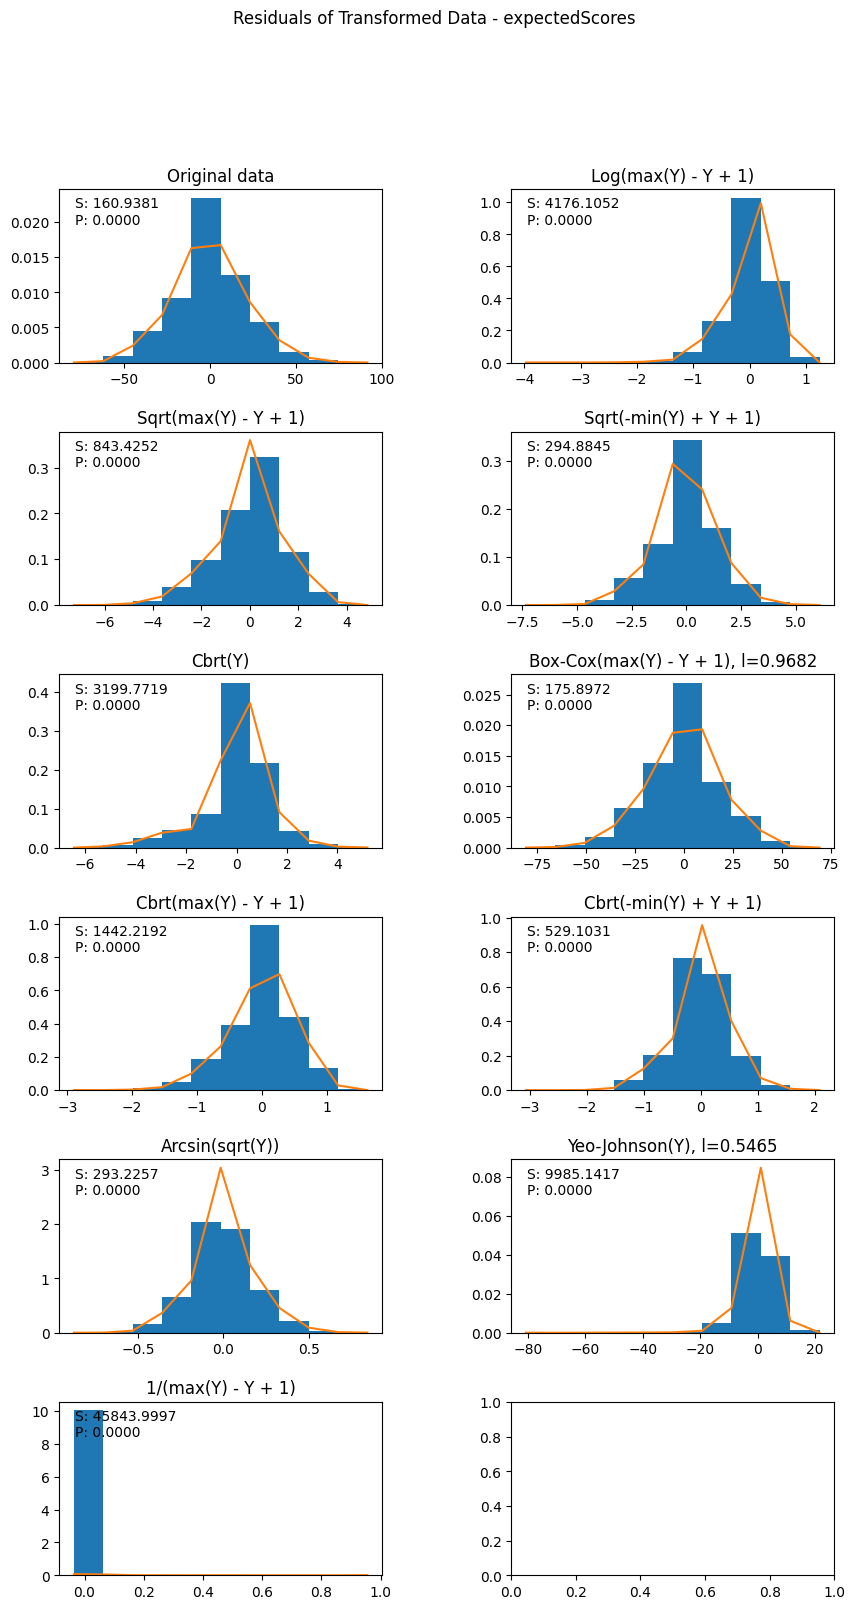

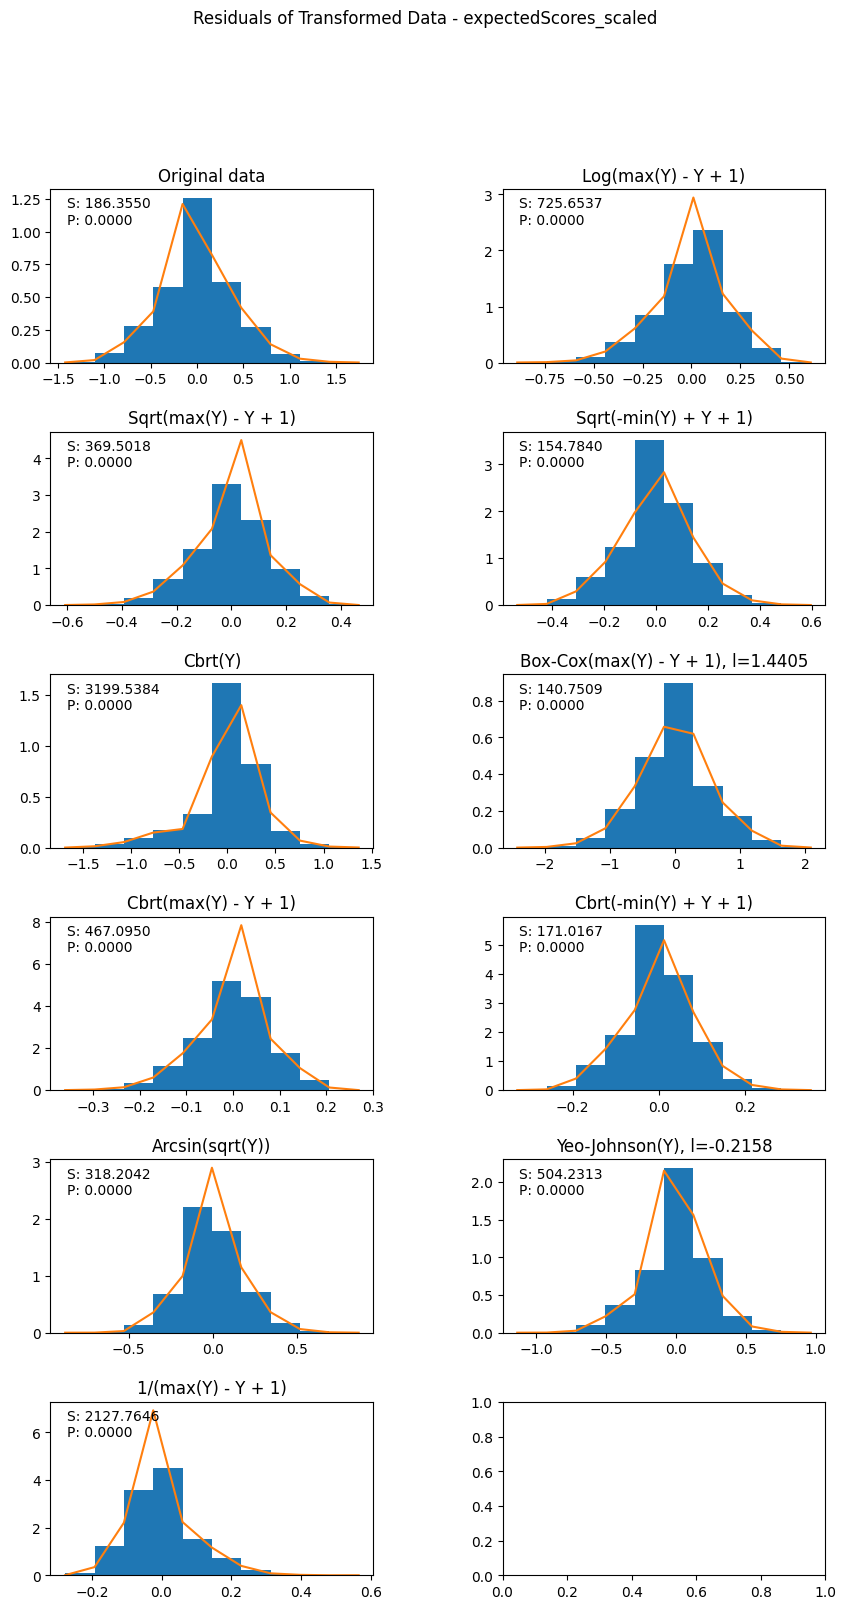

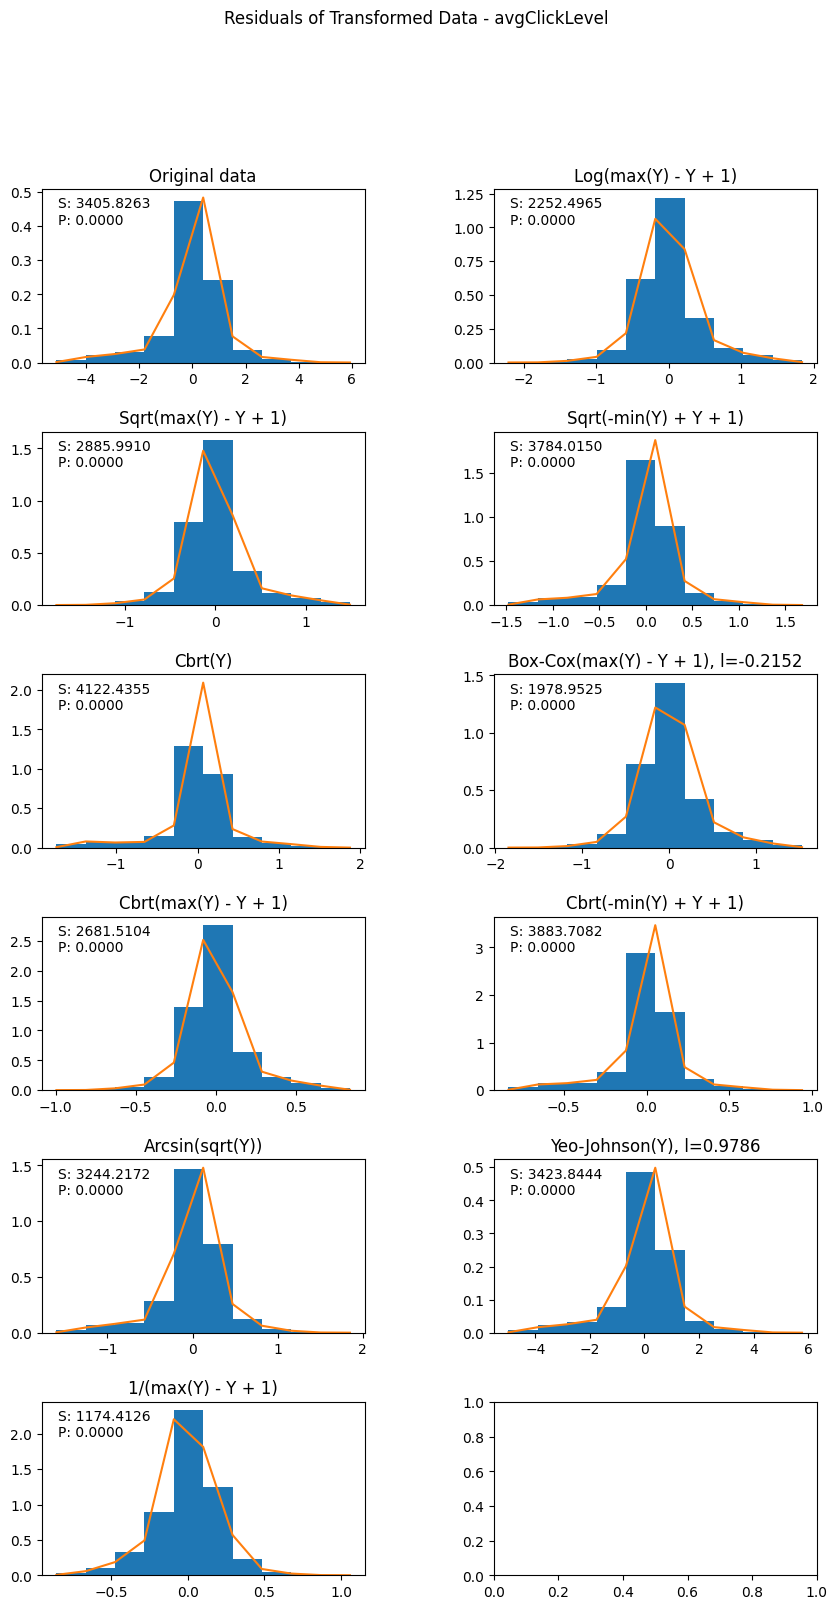

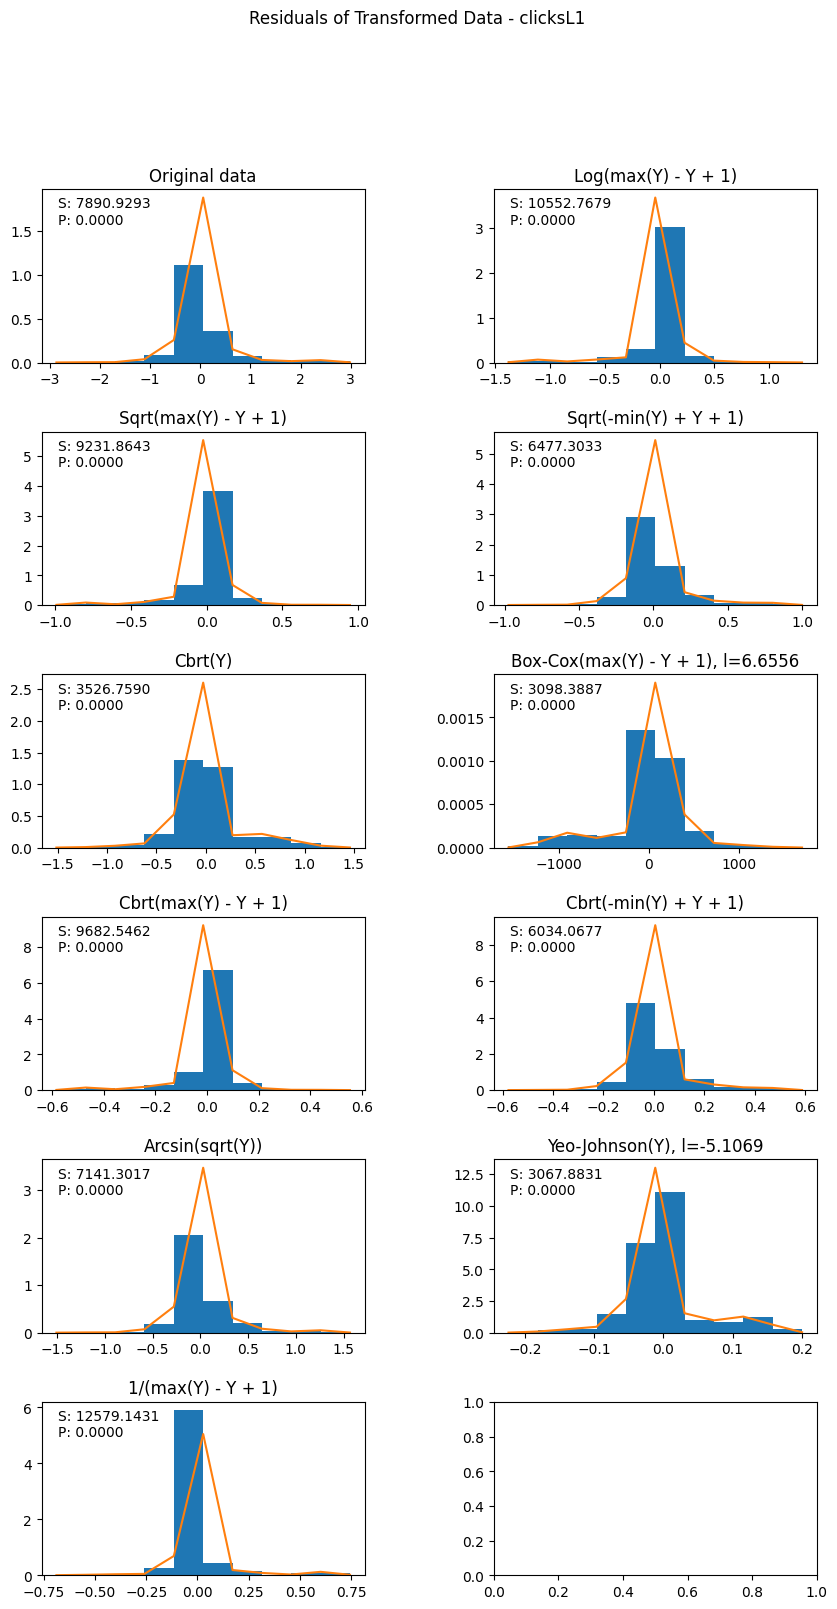

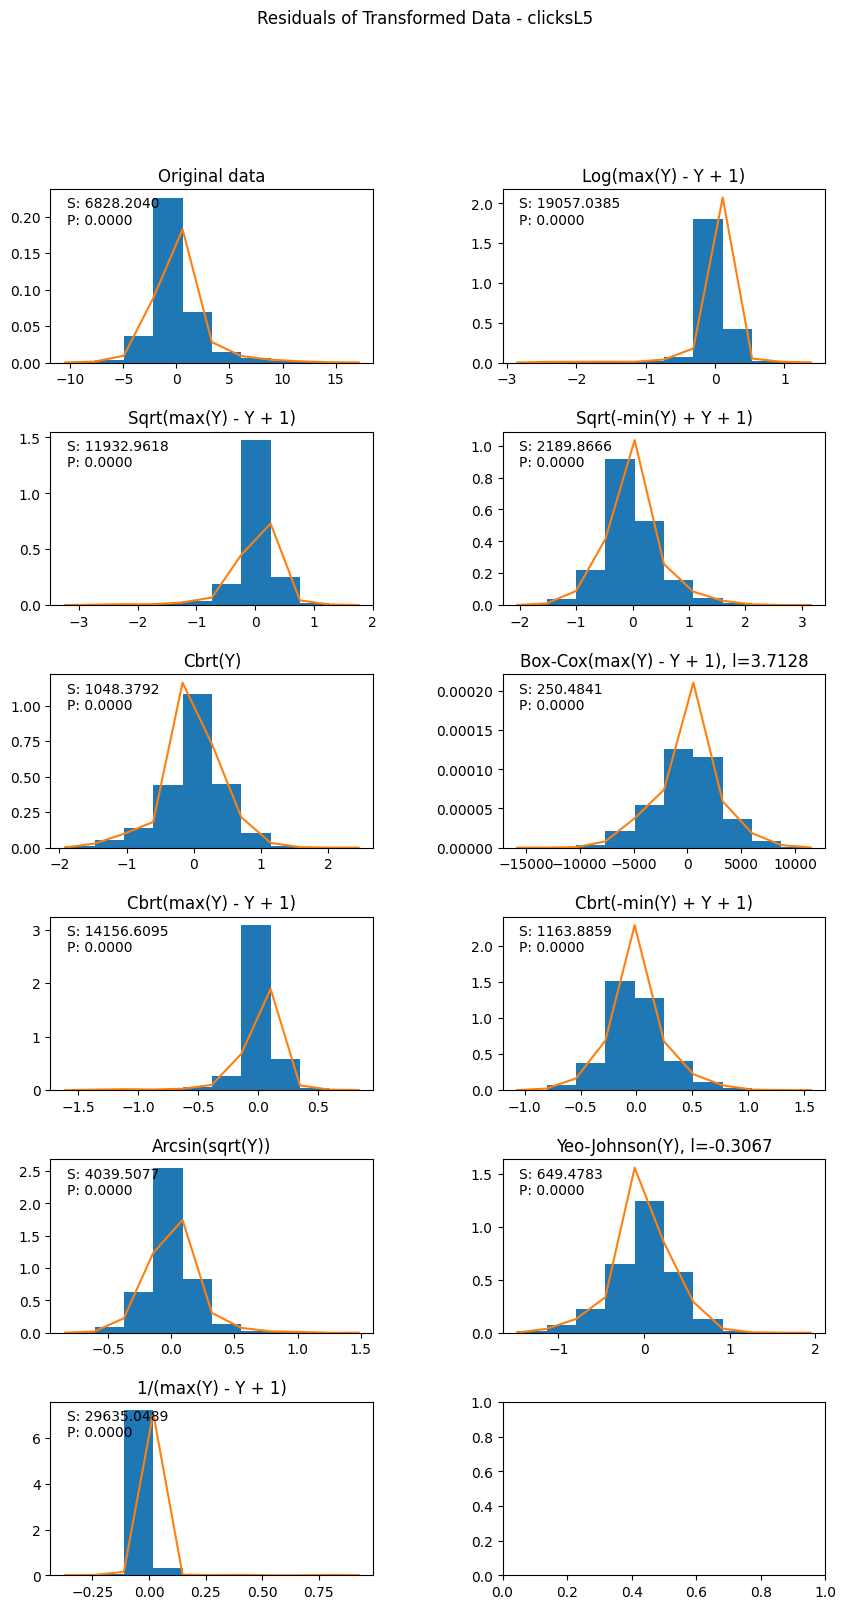

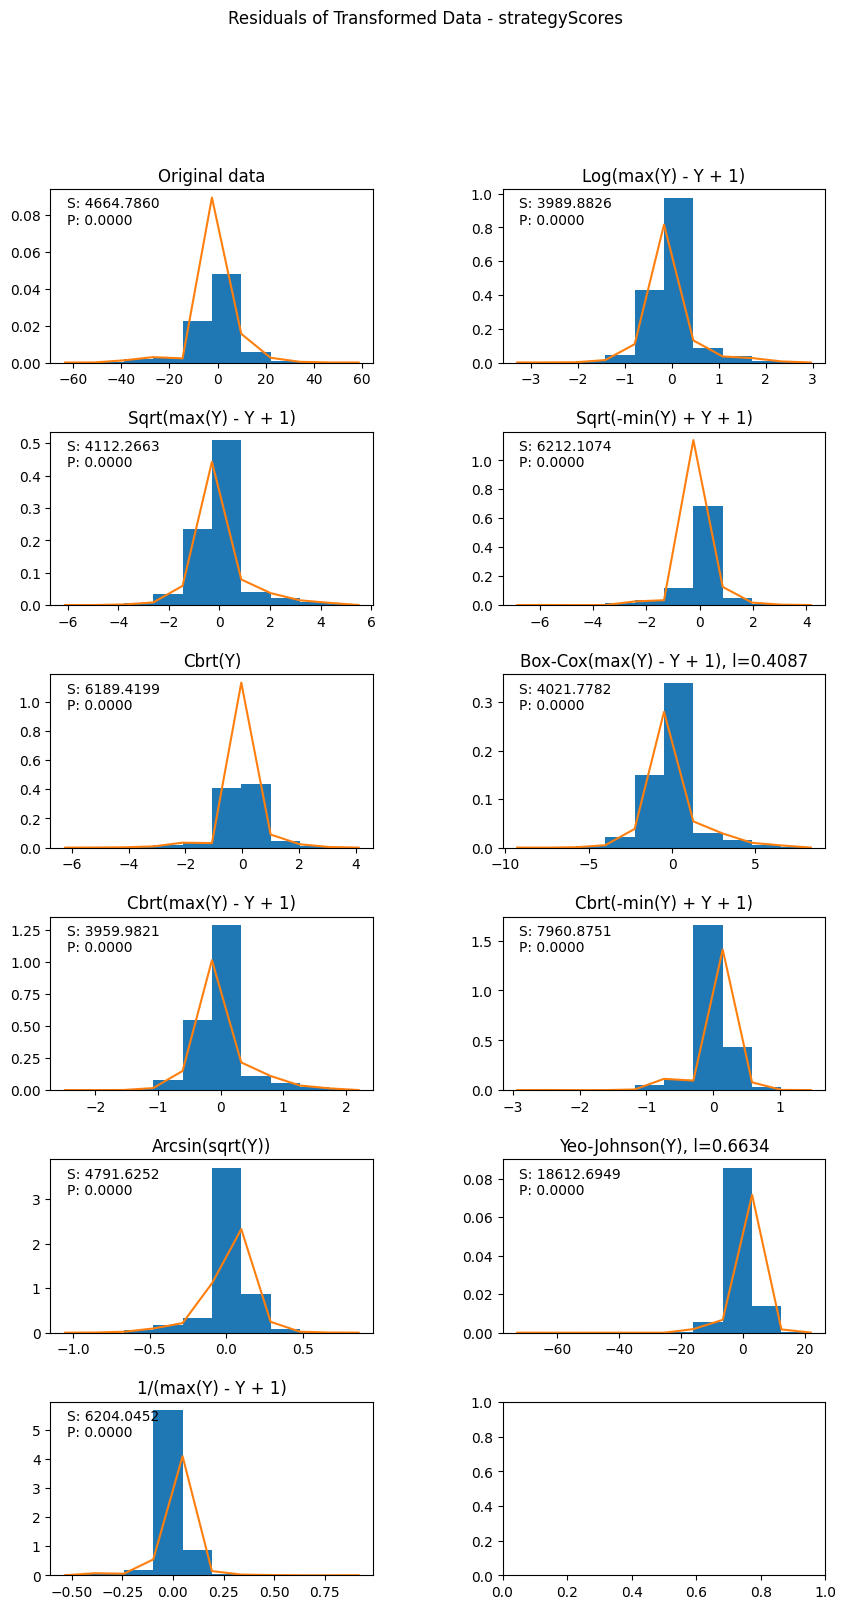

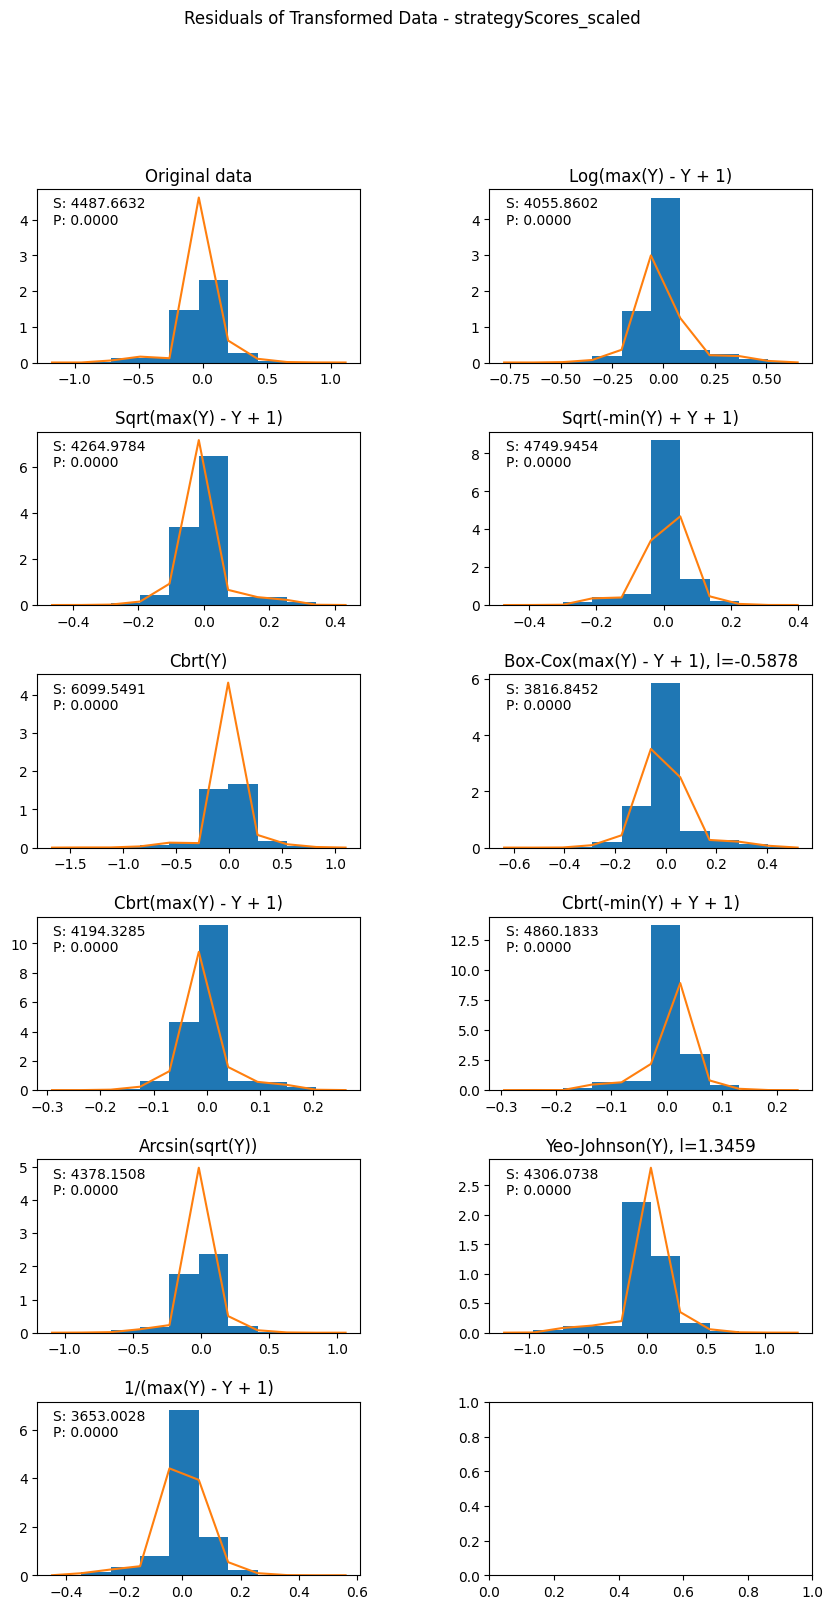

In [40]:
# Plotting residuals for all GLM Models

analysis_cols = {res: [] for res in response_vars}
highest_normality_trans = {res: "" for res in response_vars}

for response_var in response_vars:
    fig, ax = plt.subplots(nrows=math.ceil(len(all_residuals[response_var])/2),ncols=2,figsize=(10, 3 * math.ceil(len(all_residuals[response_var])/2)),squeeze=False)
    plt.suptitle("Residuals of Transformed Data - {}".format(response_var))
    ax = ax.flatten()

    lowest_normality_stat = float("inf")
    for idx, trans in enumerate(all_residuals[response_var]):
        resids = trans[0]
        response_data = trans[1]
        label = trans[2]
        normaltest = trans[3]
        if normaltest.statistic < lowest_normality_stat:
            analysis_cols[response_var] = response_data
            highest_normality_trans[response_var] = label
            lowest_normality_stat = normaltest.statistic
        density = scipy.stats.gaussian_kde(resids)
        n, x, _ = ax[idx].hist(resids, density=True)
        ax[idx].set_title(label)
        ax[idx].plot(x, density(x))
        ax[idx].text(0.05,0.8, "S: {0:0.4f}\nP: {1:0.4f}".format(normaltest.statistic, normaltest.pvalue), transform=ax[idx].transAxes)

    plt.subplots_adjust(
                    wspace=0.4, 
                    hspace=0.4)
plt.show()

In [41]:
# data which is to be used for the remainder of the analysis

# Displaying which of the data has the most normal residuals 
analysis_data = transformed_trials_df.copy()
for response_var in response_vars:
    print("{} - {}".format(response_var, highest_normality_trans[response_var]))
    analysis_data[response_var] = analysis_cols[response_var]
    

expectedScores - Original data
expectedScores_scaled - Box-Cox(max(Y) - Y + 1), l=1.4405
avgClickLevel - 1/(max(Y) - Y + 1)
clicksL1 - Yeo-Johnson(Y), l=-5.1069
clicksL5 - Box-Cox(max(Y) - Y + 1), l=3.7128
strategyScores - Cbrt(max(Y) - Y + 1)
strategyScores_scaled - 1/(max(Y) - Y + 1)


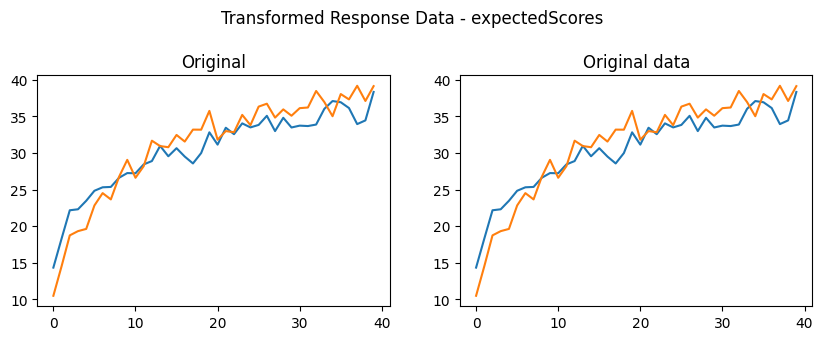

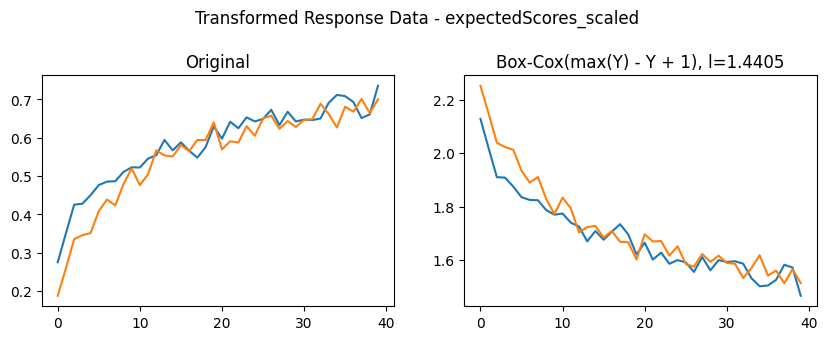

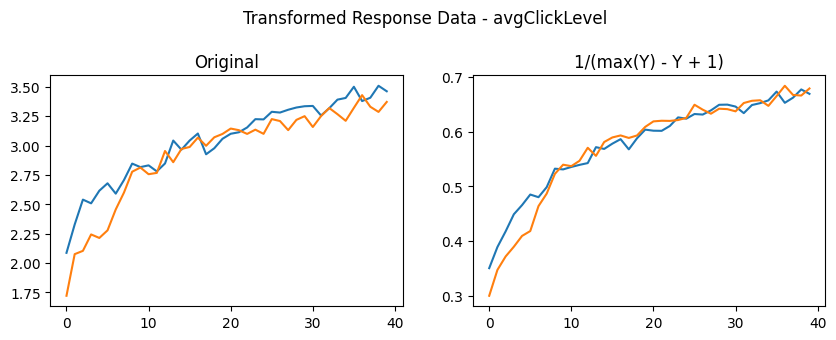

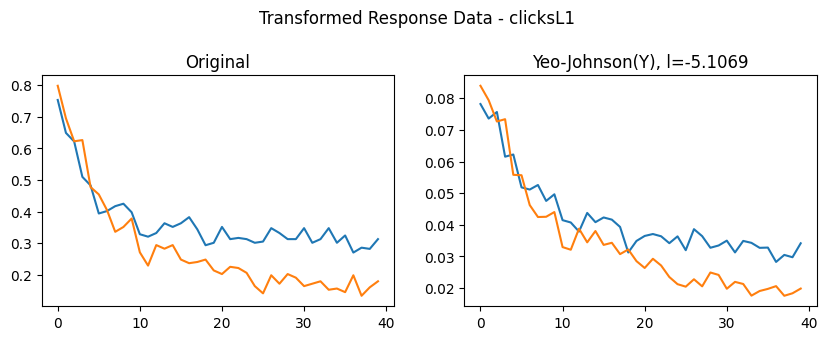

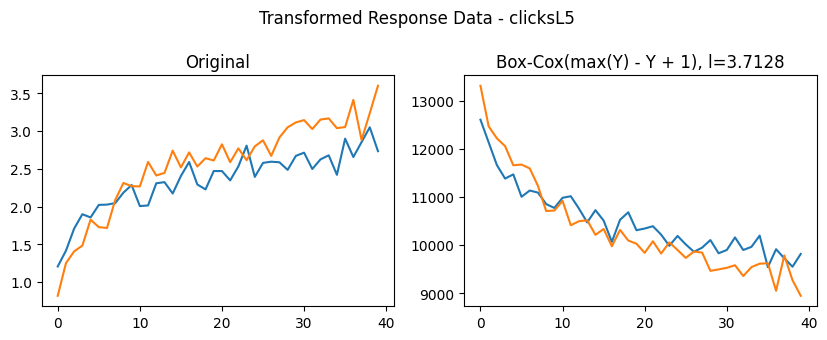

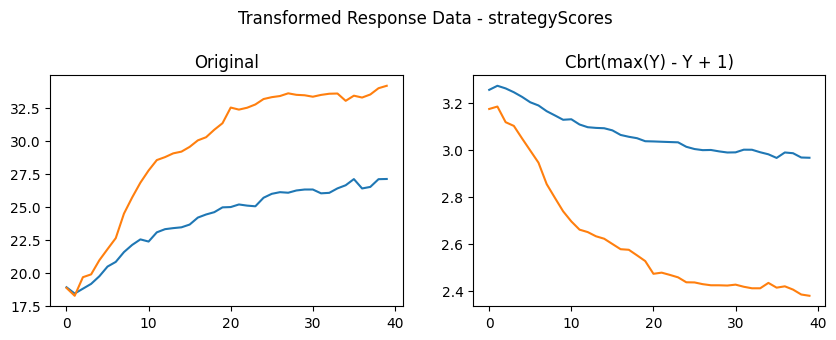

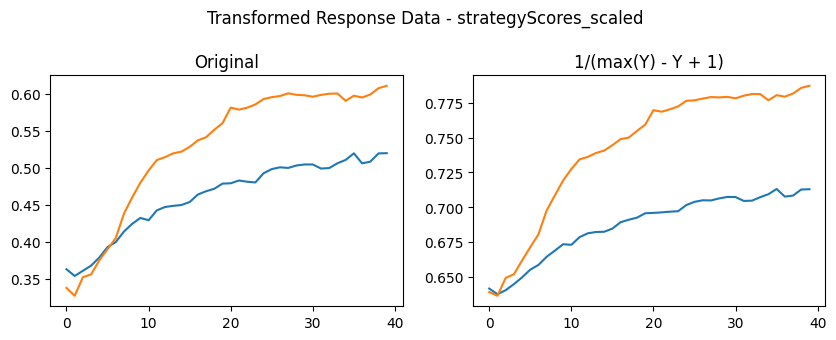

In [42]:
# Visualize transformed data for each response variable

for response_var in response_vars:
    fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(10, 3),squeeze=True)
    plt.suptitle("Transformed Response Data - {}".format(response_var),y=1.1)
    ax = ax.flatten()

    for idx, trans in enumerate([transformed_trials_df, analysis_data]):
        data = trans
        scarce = data.loc[data.condition == 1]
        control = data.loc[data.condition == 0]
        label = "Original" if idx == 0 else highest_normality_trans[response_var]

        scarce_mean = np.array(scarce.groupby('trialNumbers').mean(numeric_only=True)[response_var])
        control_mean = np.array(control.groupby('trialNumbers').mean(numeric_only=True)[response_var])
        ax[idx].plot(list(range(len(scarce_mean))), scarce_mean, label="Scarce")
        ax[idx].plot(list(range(len(control_mean))), control_mean, label="Control")
        ax[idx].set_title(label)

plt.show()

# Analysis 1.0 - Linear Regression: Finding Best Model of Learning vs. Performance

In [43]:
# If master switch is not turned on, select which data to use for this analysis
data_to_use = "all" # "1", "2", or "all"
data_to_use = data_to_use_master

In [44]:
# Manually set the partition
# Set this to false to compute the partitions for the dataset again
manually_set_partition = True
manual_partition = 10 # 10 for exp 1, 10 for exp 2, 9 for exp all

### Finding Best Model for Both Conditions Together

To use the partitions found for both conditions, run only the following subsections:
* Finding Best Model for Both Conditions Together
* Finding Best Model for Control Condition Individually

To use the partitions individually, run only the following subsections:
* Finding Best Model for Misalignment Condition Individually
* Finding Best Model for Control Condition Individually

In [45]:


test_df = analysis_data

mixed = False
    
# For scarce trials
relevant_trials = test_df

control_df = relevant_trials.loc[relevant_trials.condition == 0]
scarce_df = relevant_trials.loc[relevant_trials.condition == 1]

all_trials_mean_control = control_df.groupby("trialNumbers").mean(numeric_only=True)["expectedScores_scaled"]
all_trials_mean_scarce = scarce_df.groupby("trialNumbers").mean(numeric_only=True)["expectedScores_scaled"]
all_trial_nos = list(range(1,len(all_trials_mean_scarce)+1))

sig_bic_scores_scarce = []
scarce_plot_data = []
scarce_glm_results = []

# Check all possible data splits for both conditions
for trialNum in range(2,40,1):
    isPerformanceTrial = [int(trial > trialNum) for trial in relevant_trials.trialNumbers]
    relevant_trials['isPerformanceTrial'] = isPerformanceTrial
    
    partition_1_df = relevant_trials.loc[relevant_trials.isPerformanceTrial == 0]
    partition_2_df = relevant_trials.loc[relevant_trials.isPerformanceTrial == 1]
    partition_1_df_c = partition_1_df.loc[partition_1_df.condition == 0]
    partition_1_df_s = partition_1_df.loc[partition_1_df.condition == 1]
    partition_2_df_c = partition_2_df.loc[partition_2_df.condition == 0]
    partition_2_df_s = partition_2_df.loc[partition_2_df.condition == 1]

    partition_1_c_mean_scores = partition_1_df_c.groupby("trialNumbers").mean(numeric_only=True)["expectedScores_scaled"]
    partition_1_s_mean_scores = partition_1_df_s.groupby("trialNumbers").mean(numeric_only=True)["expectedScores_scaled"]
    partition_2_c_mean_scores = partition_2_df_c.groupby("trialNumbers").mean(numeric_only=True)["expectedScores_scaled"]
    partition_2_s_mean_scores = partition_2_df_s.groupby("trialNumbers").mean(numeric_only=True)["expectedScores_scaled"]
    
    partition_1_mean_scores = partition_1_df.groupby("trialNumbers").mean(numeric_only=True)["expectedScores_scaled"]
    partition_2_mean_scores = partition_2_df.groupby("trialNumbers").mean(numeric_only=True)["expectedScores_scaled"]
    
    use_interaction = True
    
    two_slope_formula = "expectedScores_scaled ~ trialNumbers \
                        + trialNumbers:C(isPerformanceTrial) + C(isPerformanceTrial) \
                        + C(condition)" + (" + trialNumbers:C(condition)" if use_interaction else "")
    one_slope_formula = "expectedScores_scaled ~ trialNumbers \
                        + C(condition)" + (" + trialNumbers:C(condition)" if use_interaction else "")
    
    # Fitting a single-slope model and a two-slope model to see which is better
    if mixed:
        glm_1 = smf.mixedlm(formula=two_slope_formula, data=relevant_trials, groups=relevant_trials['workerId'])
        glm_2 = smf.mixedlm(formula=one_slope_formula, data=relevant_trials, groups=relevant_trials['workerId'])
    else:
        glm_1 = smf.glm(formula=two_slope_formula, data=relevant_trials)
        glm_2 = smf.glm(formula=one_slope_formula, data=relevant_trials)

    try:
        results_1 = glm_1.fit()
        results_2 = glm_2.fit()
    except:
        continue
        
    bic1 = results_1.bic_llf
    bic2 = results_2.bic_llf
        
    # Saving the slopes and the single intercept of both phases from the two-slope model
    # Learning phase for control and scarce
    b1_c = results_1.params['trialNumbers']
    b1_s = results_1.params['trialNumbers'] \
        + (results_1.params['trialNumbers:C(condition)[T.1]'] if use_interaction else 0)
    i1_c = results_1.params['Intercept']
    i1_s = results_1.params['Intercept'] + results_1.params['C(condition)[T.1]']
    # Performance phase for control and scarce
    b2_c = results_1.params['trialNumbers'] \
        + results_1.params['trialNumbers:C(isPerformanceTrial)[T.1]']
    b2_s = results_1.params['trialNumbers'] \
        + results_1.params['trialNumbers:C(isPerformanceTrial)[T.1]'] \
        + (results_1.params['trialNumbers:C(condition)[T.1]'] if use_interaction else 0)
    i2_c = results_1.params['Intercept'] \
        + results_1.params['C(isPerformanceTrial)[T.1]']
    i2_s = results_1.params['Intercept'] \
        + results_1.params['C(isPerformanceTrial)[T.1]'] \
        + results_1.params['C(condition)[T.1]']
    
    b3 = results_2.params['trialNumbers']
    i3 = results_2.params['Intercept']
    
    if(bic1 < bic2):
        # Save data about significant partitions, where the bic of the two-slope model is higher than one-slope
        sig_bic_scores_scarce.append((trialNum, bic1))
        
    x1 = all_trial_nos[0:len(partition_1_mean_scores)]
    x2 = all_trial_nos[len(partition_1_mean_scores):len(partition_1_mean_scores)+len(partition_2_mean_scores)]
    scarce_plot_data.append((
        trialNum,
        x1,
        x2,
        partition_1_mean_scores,
        partition_2_mean_scores,
        partition_1_c_mean_scores,
        partition_1_s_mean_scores,
        partition_2_c_mean_scores,
        partition_2_s_mean_scores,
        b1_c,
        b1_s,
        b2_c,
        b2_s,
        i1_c,
        i1_s,
        i2_c,
        i2_s,
        b3,
        i3,
        partition_1_df,
        partition_2_df
    ))
    scarce_glm_results.append((trialNum, results_1, results_2))

Partition candidates: 
[9.]


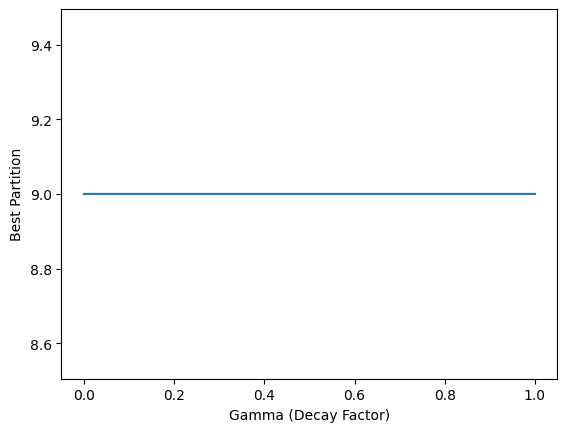

In [46]:
# Finding the best partition of all significant ones 

mis_partition_exists = len(sig_bic_scores_scarce) > 0

if mis_partition_exists:
    sig_bic_scores_scarce = np.array(sig_bic_scores_scarce)

    g_range = np.arange(0, 1, 0.0001)
    best_partitions = []

    for gamma in g_range:
        # Minimum bic
        partition_scores = sig_bic_scores_scarce[:,1]
        best_partition = sig_bic_scores_scarce[np.argmin(partition_scores),0]
        best_partitions.append(best_partition)

    partition_candidates = np.unique(best_partitions)



    print("Partition candidates: ")
    print(partition_candidates)
    plt.plot(g_range, best_partitions)
    plt.xlabel("Gamma (Decay Factor)")
    plt.ylabel("Best Partition")
    plt.show()


In [47]:
# Showing GLM results

if mis_partition_exists:
    candidate_glm_results_scarce = [data for data in scarce_glm_results if float(data[0]) in partition_candidates]

    for trialNum, results_1, results_2 in candidate_glm_results_scarce:
        print("Trial Num: {}".format(trialNum))
        print("\nTwo-Slope Model:\nBIC LLF: {0:0.4f}\n\nBIC Deviance: {1:0.4f}\n\nAIC: {2:0.4f}\n"
              .format(results_1.bic_llf,results_1.bic_deviance, results_1.aic))
        print(results_1.summary())

        print("\nOne-Slope Model:\nBIC LLF: {0:0.4f}\n\nBIC Deviance: {1:0.4f}\n\nAIC: {2:0.4f}\n"
              .format(results_2.bic_llf,results_2.bic_deviance, results_2.aic))
        print(results_2.summary())


Trial Num: 9

Two-Slope Model:
BIC LLF: 49838.1017

BIC Deviance: -193888.6240

AIC: 49790.4339

                   Generalized Linear Model Regression Results                   
Dep. Variable:     expectedScores_scaled   No. Observations:                20840
Model:                               GLM   Df Residuals:                    20834
Model Family:                   Gaussian   Df Model:                            5
Link Function:                  identity   Scale:                         0.63827
Method:                             IRLS   Log-Likelihood:                -24889.
Date:                   Wed, 06 Mar 2024   Deviance:                       13298.
Time:                           14:56:14   Pearson chi2:                 1.33e+04
No. Iterations:                        3   Pseudo R-squ. (CS):            0.03907
Covariance Type:               nonrobust                                         
                                              coef    std err          z      P>|z|

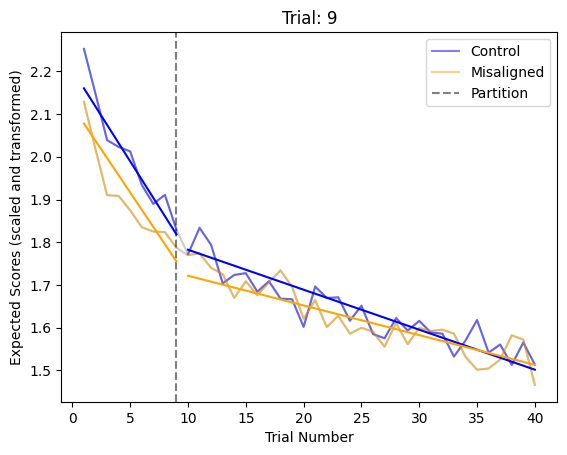

In [48]:
# Plotting candidate partitions
if mis_partition_exists:
    candidate_plot_data_scarce = [data for data in scarce_plot_data if float(data[0]) in partition_candidates]
    #significant_plot_data_scarce = [data for data in scarce_plot_data if float(data[0]) in sig_bic_scores_scarce[:,0]]

    which_plot = "candidates" #all, significant, candidates

    if which_plot == "candidates":
        plot_data = candidate_plot_data_scarce
    elif which_plot == "significant":
        plot_data = significant_plot_data_scarce
    else:
        plot_data = scarce_plot_data

    plot_single_slope = False
    plot_two_slope = True
    scatter = False
    error = False

    for trialNum, x1, x2, y1, y2, y1_c, y1_s, y2_c, y2_s, b1_c, b1_s, b2_c, b2_s, i1_c, i1_s, i2_c, i2_s, b3, i3, df_1, df_2 in plot_data:
        plt.figure()
        # Expected Score curves
        plt.plot(all_trial_nos, all_trials_mean_control, alpha=0.2, color='k')
        plt.plot(all_trial_nos, all_trials_mean_scarce, alpha=0.2, color='k')
        plt.plot(x1, y1_c, alpha=0.5, color='blue', label="Control")
        plt.plot(x1, y1_s, alpha=0.5, color='orange')
        plt.plot(x2, y2_c, alpha=0.5, color='blue')
        plt.plot(x2, y2_s, alpha=0.5, color='orange', label="Misaligned")

        # Scatter points
        if scatter:
            plt.scatter(df_1['trialNumbers'], df_1['expectedScores'], color='b', marker='o', alpha=0.1,s=0.8)
            plt.scatter(df_2['trialNumbers'], df_2['expectedScores'], color='orange', marker='o', alpha=0.1,s=0.8)

        # Partition line
        plt.axvline(trialNum, linestyle="--", color='k',alpha=0.5, label="Partition")

        # Slope lines of one-slope model
        if plot_single_slope:
            x3 = np.concatenate([x1,x2],axis=0)
            plt.plot(x3, np.array(x3) * b3 + i3, color='g', alpha=0.5)

        if plot_two_slope:
            # Slope lines of two-slope model
            plt.plot(x1, np.array(x1) * b1_c + i1_c, color='b')
            plt.plot(x1, np.array(x1) * b1_s + i1_s, color='orange')
            plt.plot(x2, np.array(x2) * b2_c + i2_c, color='b')
            plt.plot(x2, np.array(x2) * b2_s + i2_s, color='orange')
            
        if error:
            plt.fill_between(x1, scarce_data_all + scarce_data_all_sd, scarce_data_all - scarce_data_all_sd, alpha=0.1)

        plt.title("Trial: {}".format(trialNum))
    plt.xlabel("Trial Number")
    plt.ylabel("Expected Scores (scaled and transformed)")
    plt.legend()
    plt.show()

In [49]:
if mis_partition_exists:
    scarce_partition = partition_candidates[0] # Somehow choose based on possible candidates

    # Separating into learning and performance phase
    scarce_learning_data = analysis_data.loc[(analysis_data.condition == 1) & (analysis_data.trialNumbers <= scarce_partition)]
    scarce_performance_data = analysis_data.loc[(analysis_data.condition ==1) & (analysis_data.trialNumbers > scarce_partition)]

    # Without transformation
    scarce_learning_data_orig = filtered_data.loc[(filtered_data.condition == 1) & (filtered_data.trialNumbers <= scarce_partition)]
    scarce_performance_data_orig = filtered_data.loc[(filtered_data.condition ==1) & (filtered_data.trialNumbers > scarce_partition)]

    # Store the slope, intercept, etc. of the best partition
    scarce_partition_plot_data = [data for data in candidate_plot_data_scarce if data[0] == scarce_partition][0]
    
    # Set the partition to be used for the control condition data
    manually_set_partition = True
    manual_partition = scarce_partition

### Finding Best Model for Scarce Condition Individually

Don't run this section if computing partitions together for both conditions (above)

In [ ]:

test_df = analysis_data

mixed = False
    
# For scarce trials
relevant_trials = test_df.loc[test_df.condition == 1].copy()

all_trials_mean_scarce = relevant_trials.groupby("trialNumbers").mean(numeric_only=True)["expectedScores_scaled"]
all_trial_nos_scarce = list(range(1,len(all_trials_mean_scarce)+1))

sig_bic_scores_scarce = []
scarce_plot_data = []
scarce_glm_results = []

# Check all possible data splits for both conditions
for trialNum in range(2,40,1):
    isPerformanceTrial = [int(trial > trialNum) for trial in relevant_trials.trialNumbers]
    relevant_trials['isPerformanceTrial'] = isPerformanceTrial
    
    partition_1_df = relevant_trials.loc[relevant_trials.isPerformanceTrial == 0]
    partition_2_df = relevant_trials.loc[relevant_trials.isPerformanceTrial == 1]
    partition_1_mean_scores = partition_1_df.groupby("trialNumbers").mean(numeric_only=True)["expectedScores_scaled"]
    partition_2_mean_scores = partition_2_df.groupby("trialNumbers").mean(numeric_only=True)["expectedScores_scaled"]
    
    two_slope_formula = "expectedScores_scaled ~ trialNumbers + trialNumbers:C(isPerformanceTrial) + C(isPerformanceTrial)"
    one_slope_formula = "expectedScores_scaled ~ trialNumbers"
    
    # Fitting a single-slope model and a two-slope model to see which is better
    if mixed:
        glm_1 = smf.mixedlm(formula=two_slope_formula, data=relevant_trials, groups=relevant_trials['workerId'])
        glm_2 = smf.mixedlm(formula=one_slope_formula, data=relevant_trials, groups=relevant_trials['workerId'])
    else:
        glm_1 = smf.glm(formula=two_slope_formula, data=relevant_trials)
        glm_2 = smf.glm(formula=one_slope_formula, data=relevant_trials)

    try:
        results_1 = glm_1.fit()
        results_2 = glm_2.fit()
    except:
        continue
        
    bic1 = results_1.bic_llf
    bic2 = results_2.bic_llf
        
    # Saving the slopes and the single intercept of both phases from the two-slope model
    b1 = results_1.params['trialNumbers']
    b2 = results_1.params['trialNumbers'] + results_1.params['trialNumbers:C(isPerformanceTrial)[T.1]']
    i1 = results_1.params['Intercept']
    i2 = results_1.params['Intercept'] + results_1.params['C(isPerformanceTrial)[T.1]']
    
    b3 = results_2.params['trialNumbers']
    i3 = results_2.params['Intercept']
    
    if(bic1 < bic2):
        # Save data about significant partitions, where the bic of the two-slope model is higher than one-slope
        sig_bic_scores_scarce.append((trialNum, bic1))
        
    x1 = all_trial_nos_scarce[0:len(partition_1_mean_scores)]
    x2 = all_trial_nos_scarce[len(partition_1_mean_scores):len(partition_1_mean_scores)+len(partition_2_mean_scores)]
    scarce_plot_data.append((
        trialNum,
        x1,
        x2,
        partition_1_mean_scores,
        partition_2_mean_scores,
        b1,
        b2,
        i1,
        i2,
        b3,
        i3,
        partition_1_df,
        partition_2_df
    ))
    scarce_glm_results.append((trialNum, results_1, results_2))

In [50]:
# Finding the best partition of all significant ones 

mis_partition_exists = len(sig_bic_scores_scarce) > 0

if manually_set_partition: mis_partition_exists = True
if mis_partition_exists:
    if manually_set_partition:
        partition_candidates = [manual_partition]
    else:
        sig_bic_scores_scarce = np.array(sig_bic_scores_scarce)

    
        g_range = np.arange(0, 1, 0.0001)
        best_partitions = []

        for gamma in g_range:
            # Minimum bic
            partition_scores = sig_bic_scores_scarce[:,1]
            best_partition = sig_bic_scores_scarce[np.argmin(partition_scores),0]
            best_partitions.append(best_partition)

        partition_candidates = np.unique(best_partitions)
    


        print("Partition candidates: ")
        print(partition_candidates)
        plt.plot(g_range, best_partitions)
        plt.xlabel("Gamma (Decay Factor)")
        plt.ylabel("Best Partition")
        plt.show()


In [51]:
# Showing GLM results - scarce

if mis_partition_exists:
    candidate_glm_results_scarce = [data for data in scarce_glm_results if float(data[0]) in partition_candidates]

    for trialNum, results_1, results_2 in candidate_glm_results_scarce:
        print("Trial Num: {}".format(trialNum))
        print("\nTwo-Slope Model:\nBIC LLF: {0:0.4f}\n\nBIC Deviance: {1:0.4f}\n\nAIC: {2:0.4f}\n"
              .format(results_1.bic_llf,results_1.bic_deviance, results_1.aic))
        print(results_1.summary())

        print("\nOne-Slope Model:\nBIC LLF: {0:0.4f}\n\nBIC Deviance: {1:0.4f}\n\nAIC: {2:0.4f}\n"
              .format(results_2.bic_llf,results_2.bic_deviance, results_2.aic))
        print(results_2.summary())


Trial Num: 10

Two-Slope Model:
BIC LLF: 25132.4363

BIC Deviance: -88911.0875

AIC: 25103.4535

                   Generalized Linear Model Regression Results                   
Dep. Variable:     expectedScores_scaled   No. Observations:                10360
Model:                               GLM   Df Residuals:                    10356
Model Family:                   Gaussian   Df Model:                            3
Link Function:                  identity   Scale:                         0.66024
Method:                             IRLS   Log-Likelihood:                -12548.
Date:                   Mon, 04 Mar 2024   Deviance:                       6837.5
Time:                           17:53:36   Pearson chi2:                 6.84e+03
No. Iterations:                        3   Pseudo R-squ. (CS):            0.02939
Covariance Type:               nonrobust                                         
                                              coef    std err          z      P>|z|

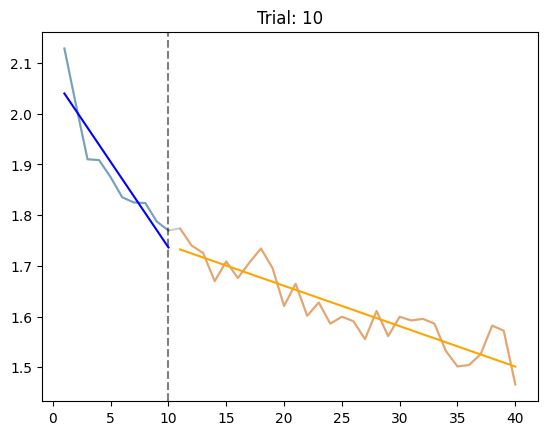

In [52]:
# Plotting candidate partitions - scarce
if mis_partition_exists:
    candidate_plot_data_scarce = [data for data in scarce_plot_data if float(data[0]) in partition_candidates]
    #significant_plot_data_scarce = [data for data in scarce_plot_data if float(data[0]) in sig_bic_scores_scarce[:,0]]

    which_plot = "candidates" #all, significant, candidates

    if which_plot == "candidates":
        plot_data = candidate_plot_data_scarce
    elif which_plot == "significant":
        plot_data = significant_plot_data_scarce
    else:
        plot_data = scarce_plot_data

    plot_single_slope = False
    plot_two_slope = True
    scatter = False
    error = False

    for trialNum, x1, x2, y1, y2, b1, b2, i1, i2,b3, i3, df_1, df_2 in plot_data:
        plt.figure()
        # Expected Score curves
        plt.plot(all_trial_nos_scarce, all_trials_mean_scarce, alpha=0.2, color='k')
        plt.plot(x1, y1, alpha=0.5)
        plt.plot(x2, y2, alpha=0.5)

        # Scatter points
        if scatter:
            plt.scatter(df_1['trialNumbers'], df_1['expectedScores'], color='b', marker='o', alpha=0.1,s=0.8)
            plt.scatter(df_2['trialNumbers'], df_2['expectedScores'], color='orange', marker='o', alpha=0.1,s=0.8)

        # Partition line
        plt.axvline(trialNum, linestyle="--", color='k',alpha=0.5)

        # Slope lines of one-slope model
        if plot_single_slope:
            x3 = np.concatenate([x1,x2],axis=0)
            plt.plot(x3, np.array(x3) * b3 + i3, color='g', alpha=0.5)

        if plot_two_slope:
            # Slope lines of two-slope model
            plt.plot(x1, np.array(x1) * b1 + i1, color='b')
            plt.plot(x2, np.array(x2) * b2 + i2, color='orange')

        if error:
            plt.fill_between(x1, scarce_data_all + scarce_data_all_sd, scarce_data_all - scarce_data_all_sd, alpha=0.1)

        plt.title("Trial: {}".format(trialNum))

    plt.show()

In [53]:
if mis_partition_exists:
    scarce_partition = partition_candidates[0] # Somehow choose based on possible candidates

    # Separating into learning and performance phase
    scarce_learning_data = analysis_data.loc[(analysis_data.condition == 1) & (analysis_data.trialNumbers <= scarce_partition)]
    scarce_performance_data = analysis_data.loc[(analysis_data.condition ==1) & (analysis_data.trialNumbers > scarce_partition)]

    # Without transformation
    scarce_learning_data_orig = filtered_data.loc[(filtered_data.condition == 1) & (filtered_data.trialNumbers <= scarce_partition)]
    scarce_performance_data_orig = filtered_data.loc[(filtered_data.condition ==1) & (filtered_data.trialNumbers > scarce_partition)]

    # Store the slope, intercept, etc. of the best partition
    scarce_partition_plot_data = [data for data in candidate_plot_data_scarce if data[0] == scarce_partition][0]

### Finding Best Model for Control Condition

Run this subsection whether computing partitions individually or collectively for both conditions.

In [50]:
# GLM 3 - finding cut off point of learning phase

test_df = analysis_data

mixed = False
    
# For control trials
relevant_trials = test_df.loc[test_df.condition == 0].copy()

all_trials_mean_control = relevant_trials.groupby("trialNumbers").mean(numeric_only=True)["expectedScores_scaled"]
all_trial_nos_control = list(range(1,len(all_trials_mean_control)+1))

sig_bic_scores_control = []
control_plot_data = []
control_glm_results = []
for trialNum in range(2,40,1):
    isPerformanceTrial = [int(trial > trialNum) for trial in relevant_trials.trialNumbers]
    relevant_trials['isPerformanceTrial'] = isPerformanceTrial
    
    partition_1_df = relevant_trials.loc[relevant_trials.isPerformanceTrial == 0]
    partition_2_df = relevant_trials.loc[relevant_trials.isPerformanceTrial == 1]
    partition_1_mean_scores = partition_1_df.groupby("trialNumbers").mean(numeric_only=True)["expectedScores_scaled"]
    partition_2_mean_scores = partition_2_df.groupby("trialNumbers").mean(numeric_only=True)["expectedScores_scaled"]
    
#     two_slope_formula = "expectedScores ~ trialNumbers + C(condition) + C(isPerformanceTrial) + trialNumbers:C(isPerformanceTrial)"
#     one_slope_formula = "expectedScores ~ trialNumbers + C(condition)"
    two_slope_formula = "expectedScores_scaled ~ trialNumbers + trialNumbers:C(isPerformanceTrial) + C(isPerformanceTrial)"
    one_slope_formula = "expectedScores_scaled ~ trialNumbers"
    
    # Fitting a single-slope model and a two-slope model to see which is better
    if mixed:
        glm_1 = smf.mixedlm(formula=two_slope_formula, data=relevant_trials, groups=relevant_trials['workerId'])
        glm_2 = smf.mixedlm(formula=one_slope_formula, data=relevant_trials, groups=relevant_trials['workerId'])
    else:
        glm_1 = smf.glm(formula=two_slope_formula, data=relevant_trials)
        glm_2 = smf.glm(formula=one_slope_formula, data=relevant_trials)

    try:
        results_1 = glm_1.fit()
        results_2 = glm_2.fit()
    except:
        continue
        
    bic1 = results_1.bic_llf
    bic2 = results_2.bic_llf
    
    # print(results_1.summary())
    
    # Saving the slopes and the single intercept of both phases from the two-slope model
    b1 = results_1.params['trialNumbers']
    b2 = results_1.params['trialNumbers'] + results_1.params['trialNumbers:C(isPerformanceTrial)[T.1]']
    i1 = results_1.params['Intercept']
    i2 = results_1.params['Intercept'] + results_1.params['C(isPerformanceTrial)[T.1]']
    
    b3 = results_2.params['trialNumbers']
    i3 = results_2.params['Intercept']
    if(bic1 < bic2):
        # Save data about significant partitions, where the bic of the two-slope model is higher than one-slope
        sig_bic_scores_control.append((trialNum, bic1))
        
    x1 = all_trial_nos_control[0:len(partition_1_mean_scores)]
    x2 = all_trial_nos_control[len(partition_1_mean_scores):len(partition_1_mean_scores)+len(partition_2_mean_scores)]
    control_plot_data.append((
        trialNum,
        x1,
        x2,
        partition_1_mean_scores,
        partition_2_mean_scores,
        b1,
        b2,
        i1,
        i2,
        b3, 
        i3,
        partition_1_df,
        partition_2_df
    ))
    control_glm_results.append((trialNum, results_1, results_2))

In [51]:
sig_bic_scores_control

[(2, 24737.01672722112),
 (3, 24730.046719407983),
 (4, 24722.988801915104),
 (5, 24714.396049344774),
 (6, 24710.125034564),
 (7, 24707.740537867947),
 (8, 24703.658949307355),
 (9, 24702.35320285691),
 (10, 24702.290111786984),
 (11, 24702.333013583182),
 (12, 24702.119715989313),
 (13, 24702.061361511536),
 (14, 24703.087681828787),
 (15, 24705.060142682873),
 (16, 24706.083055802155),
 (17, 24709.167963445747),
 (18, 24710.829544935266),
 (19, 24713.285592312157),
 (20, 24711.95215650559),
 (21, 24719.20962852129),
 (22, 24724.311388289134),
 (23, 24729.62702375134),
 (24, 24731.672565841298),
 (25, 24736.59260742409),
 (26, 24737.59564362072),
 (27, 24738.363230504132),
 (28, 24743.740801664593),
 (29, 24747.059526211116),
 (30, 24752.710452673975),
 (31, 24756.466188849336),
 (32, 24760.414545456108),
 (33, 24760.476771311805),
 (34, 24764.20805869048)]

Partition candidates: 
[9.0]


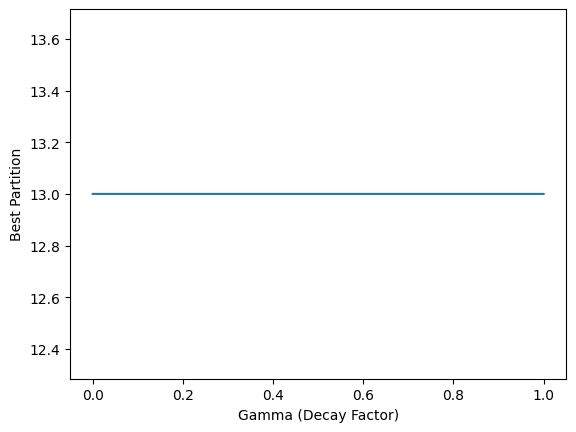

In [52]:
# Finding the best partition of all significant ones 

sig_bic_scores_control = np.array(sig_bic_scores_control)

g_range = np.arange(0, 1, 0.0001)
best_partitions = []

for gamma in g_range:
    # Minimum bic
    partition_scores = sig_bic_scores_control[:,1]
    best_partition = sig_bic_scores_control[np.argmin(partition_scores),0]
    best_partitions.append(best_partition)

partition_candidates = np.unique(best_partitions)
if manually_set_partition:
    partition_candidates = [manual_partition]
print("Partition candidates: ")
print(partition_candidates)
plt.plot(g_range, best_partitions)
plt.xlabel("Gamma (Decay Factor)")
plt.ylabel("Best Partition")
plt.show()


In [53]:
# Showing GLM results - control
candidate_glm_results_control = [data for data in control_glm_results if float(data[0]) in partition_candidates]

for trialNum, results_1, results_2 in candidate_glm_results_control:
    print("Trial Num: {}".format(trialNum))
    print("\nTwo-Slope Model:\nBIC LLF: {0:0.4f}\n\nBIC Deviance: {1:0.4f}\n\nAIC: {2:0.4f}\n"
          .format(results_1.bic_llf,results_1.bic_deviance, results_1.aic))
    print(results_1.summary())
    
    print("\nOne-Slope Model:\nBIC LLF: {0:0.4f}\n\nBIC Deviance: {1:0.4f}\n\nAIC: {2:0.4f}\n"
          .format(results_2.bic_llf,results_2.bic_deviance, results_2.aic))
    print(results_2.summary())


Trial Num: 9

Two-Slope Model:
BIC LLF: 24702.3532

BIC Deviance: -90521.7539

AIC: 24673.3243

                   Generalized Linear Model Regression Results                   
Dep. Variable:     expectedScores_scaled   No. Observations:                10480
Model:                               GLM   Df Residuals:                    10476
Model Family:                   Gaussian   Df Model:                            3
Link Function:                  identity   Scale:                         0.61635
Method:                             IRLS   Log-Likelihood:                -12333.
Date:                   Wed, 06 Mar 2024   Deviance:                       6456.9
Time:                           14:56:17   Pearson chi2:                 6.46e+03
No. Iterations:                        3   Pseudo R-squ. (CS):            0.04876
Covariance Type:               nonrobust                                         
                                              coef    std err          z      P>|z| 

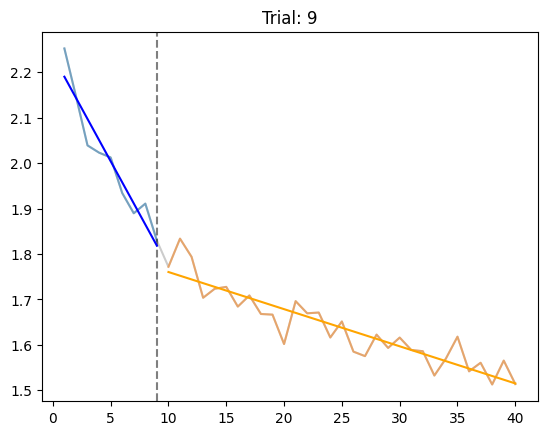

In [54]:
# Plotting candidate partitions - control
candidate_plot_data_control = [data for data in control_plot_data if float(data[0]) in partition_candidates]
#significant_plot_data_control = [data for data in control_plot_data if float(data[0]) in sig_bic_scores_control[:,0]]

which_plot = "candidates" #all, significant, candidates

if which_plot == "candidates":
    plot_data = candidate_plot_data_control
elif which_plot == "significant":
    plot_data = significant_plot_data_control
else:
    plot_data = control_plot_data
    
plot_single_slope = False
plot_two_slope = True
scatter = False

for trialNum, x1, x2, y1, y2, b1, b2, i1, i2,b3, i3, df_1, df_2 in plot_data:
    plt.figure()
    # Expected Score curves
    plt.plot(all_trial_nos_control, all_trials_mean_control, alpha=0.2, color='k')
    plt.plot(x1, y1, alpha=0.5)
    plt.plot(x2, y2, alpha=0.5)

    # Partition line
    plt.axvline(trialNum, linestyle="--", color='k',alpha=0.5)
    
    # Scatter points
    if scatter:
        plt.scatter(df_1['trialNumbers'], df_1['expectedScores'], color='b', marker='o', alpha=0.1,s=0.8)
        plt.scatter(df_2['trialNumbers'], df_2['expectedScores'], color='orange', marker='o', alpha=0.1,s=0.8)

    # Slope lines of one-slope model
    if plot_single_slope:
        x3 = np.concatenate([x1,x2],axis=0)
        plt.plot(x3, np.array(x3) * b3 + i3, color='g', alpha=0.5)
    
    if plot_two_slope:
        # Slope lines of two-slope model
        plt.plot(x1, np.array(x1) * b1 + i1, color='b')
        plt.plot(x2, np.array(x2) * b2 + i2, color='orange')
    
    plt.title("Trial: {}".format(trialNum))
    
plt.show()

In [55]:
control_partition = partition_candidates[0] # Somehow choose based on possible candidates

# Separating into learning and performance phase
control_learning_data = analysis_data.loc[(analysis_data.condition == 0) & (analysis_data.trialNumbers <= control_partition)]
control_performance_data = analysis_data.loc[(analysis_data.condition == 0) & (analysis_data.trialNumbers > control_partition)]

# Without transformation
control_learning_data_orig = filtered_data.loc[(filtered_data.condition == 0) & (filtered_data.trialNumbers <= control_partition)]
control_performance_data_orig = filtered_data.loc[(filtered_data.condition == 0) & (filtered_data.trialNumbers > control_partition)]

# Store the slope, intercept, etc. of the best partition
control_partition_plot_data = [data for data in candidate_plot_data_control if data[0] == control_partition][0]

if not mis_partition_exists:
    scarce_partition = control_partition # Somehow choose based on possible candidates

    # Separating into learning and performance phase
    scarce_learning_data = analysis_data.loc[(analysis_data.condition == 1) & (analysis_data.trialNumbers <= scarce_partition)]
    scarce_performance_data = analysis_data.loc[(analysis_data.condition ==1) & (analysis_data.trialNumbers > scarce_partition)]

    # Without transformation
    scarce_learning_data_orig = filtered_data.loc[(filtered_data.condition == 1) & (filtered_data.trialNumbers <= scarce_partition)]
    scarce_performance_data_orig = filtered_data.loc[(filtered_data.condition ==1) & (filtered_data.trialNumbers > scarce_partition)]

    # Store the slope, intercept, etc. of the best partition
    scarce_partition_plot_data = [data for data in scarce_plot_data if data[0] == scarce_partition][0]

# Analysis Helper Functions

Functions to convert LMM tables to LaTeX tables

In [56]:
table_replace_chars = {
    "_": "\\_",
    "~": "$\sim$",
    "*": "$*$",
    "+": "$+$",
    "|": "$|$",
    "C(condition)": "condition"
}

experiment_name_map = {
    "1": "MisOrig",
    "2": "MisRep",
    "all": "MisCombined"
}
numeral_to_word_map = {
    "0": "Zero",
    "1": "One",
    "2": "Two",
    "3": "Three",
    "4": "Four"
}

In [57]:
table_template_rs = "\\newcommand{{\\table{0}}}{{\n" + \
"\\begin{{table}} \n" + \
"\\centering \n" + \
"\t\\caption{{LMM results for Analysis {1}}} \n" + \
"\t\\begin{{tabular}}{{c|CC|CC}} \n" + \
"\t\t\\hline \n" + \
"\t\t\\multicolumn{{5}}{{c}}{{ }}\\\\[-1em] \n" + \
"\t\t\\multicolumn{{5}}{{c}}{{{2}}}\\\\ \n" + \
"\t\t&&&&\\\\[-1em] \n" + \
"\t\t\\hline \n" + \
"\t\t&&&&\\\\[-1em] \n" + \
"\t\t\\multirow{{2}}{{*}}{{\\textbf{{Regressor}}}} & \\multicolumn{{2}}{{c|}}{{\\textbf{{Rapid Learning Phase}}}} & \\multicolumn{{2}}{{c}}{{\\textbf{{Slow Improvement Phase}}}} \\\\ \n" + \
"\t\t&&&&\\\\[-1em] \n" + \
"\t\t& $\\beta$ & $p$ & $\\beta$ & $p$\\\\ \n" + \
"\t\t&&&&\\\\[-1em] \n" + \
"\t\t\\hline \n" + \
"\t\t&&&&\\\\[-1em] \n" + \
"\t\tIntercept & {3} & {4} & {5} & {6} \\\\ \n" + \
"\t\tcondition & {7} & {8} & {9} & {10} \\\\ \n" + \
"\t\ttrialNumbers & {11} & {12} & {13} & {14} \\\\ \n" + \
"\t\ttrialNumbers:condition & {15} & {16} & {17} & {18} \\\\ \n" + \
"\t\tVar RI & {19} & {20} & {21} & {22} \\\\ \n" + \
"\t\tVar RS & {23} & {24} & {25} & {26} \\\\ \n" + \
"\t\tCov RI$*$RS & {27} & {28} & {29} & {30} \\\\ \n" + \
"\t\t\\hline \n" + \
"\t\\end{{tabular}} \n" + \
"\t\\label{{table:{31}}} \n" + \
"\\end{{table}} \n" + \
"}}"

table_template_ri = "\\newcommand{{\\table{0}}}{{\n" + \
"\\begin{{table}} \n" + \
"\\centering \n" + \
"\t\\caption{{LMM results for Analysis {1}}} \n" + \
"\t\\begin{{tabular}}{{c|CC|CC}} \n" + \
"\t\t\\hline \n" + \
"\t\t\\multicolumn{{5}}{{c}}{{ }}\\\\[-1em] \n" + \
"\t\t\\multicolumn{{5}}{{c}}{{{2}}}\\\\ \n" + \
"\t\t&&&&\\\\[-1em] \n" + \
"\t\t\\hline \n" + \
"\t\t&&&&\\\\[-1em] \n" + \
"\t\t\\multirow{{2}}{{*}}{{\\textbf{{Regressor}}}} & \\multicolumn{{2}}{{c|}}{{\\textbf{{Rapid Learning Phase}}}} & \\multicolumn{{2}}{{c}}{{\\textbf{{Slow Improvement Phase}}}} \\\\ \n" + \
"\t\t&&&&\\\\[-1em] \n" + \
"\t\t& $\\beta$ & $p$ & $\\beta$ & $p$\\\\ \n" + \
"\t\t&&&&\\\\[-1em] \n" + \
"\t\t\\hline \n" + \
"\t\t&&&&\\\\[-1em] \n" + \
"\t\tIntercept & {3} & {4} & {5} & {6} \\\\ \n" + \
"\t\tcondition & {7} & {8} & {9} & {10} \\\\ \n" + \
"\t\ttrialNumbers & {11} & {12} & {13} & {14} \\\\ \n" + \
"\t\ttrialNumbers:condition & {15} & {16} & {17} & {18} \\\\ \n" + \
"\t\tVar RI & {19} & {20} & {21} & {22} \\\\ \n" + \
"\t\t\\hline \n" + \
"\t\\end{{tabular}} \n" + \
"\t\\label{{table:{23}}} \n" + \
"\\end{{table}} \n" + \
"}}"

table_template_map = {
    "1": table_template_ri,
    "2": table_template_rs,
    "all": table_template_rs
}

In [58]:
# Function to convert LMM results into a table

def LMM_to_table(learning_lmm, performance_lmm, anal_num, formula, which_data):
    argument_list = []

    # Argument 0 - command name
    command_name = experiment_name_map[which_data] + "".join([numeral_to_word_map[n] for n in anal_num.split(".")])
    argument_list.append(command_name)
    
    # Argument 1 - Analysis number
    argument_list.append(anal_num)
    
    # Argument 2 - formula
    for k,v in table_replace_chars.items():
        formula = formula.replace(k,v)
    argument_list.append(formula)
    
    # All stats arguments
    param_list = ["Intercept", "C(condition)[T.1]", "trialNumbers", "trialNumbers:C(condition)[T.1]",
                 "Group Var"]
    if which_data != "1":
        param_list += ["trialNumbers Var", "Group x trialNumbers Cov"]
    
    stats_args = []
    for par in param_list:
        for res in [l_results, results]:
            try:
                pval = res.pvalues[par]
            except:
                pval = 2
                
            try:
                beta = res.params[par]
            except:
                beta = float("inf")
                #print(par, res.params.keys())
            if pval < 0.05:
                # Significant in bold
                bprint = "\\textbf{{{0:0.2f}}}".format(beta)
                pprint = "\\textbf{{{0:0.2f}}}".format(pval)
            elif pval > 1:
                # Random effects have no pvalue
                if beta != float("inf"):
                    bprint = "{0:0.2f}".format(beta)
                else:
                    bprint = ""
                pprint = ""
            else:
                # Non-significant effects not bold
                bprint = "{0:0.2f}".format(beta)
                pprint = "{0:0.2f}".format(pval)
            stats_args += [bprint, pprint]
    argument_list += stats_args
    
    # Final argument: label
    label = command_name
    argument_list.append(label)
    
    table_template = table_template_map[which_data] 
    
    return table_template.format(*argument_list)

# Analysis 1.1 - Linear Regression: Expected Score vs. Trial Number x Condition

In [59]:
# Select the response variable for this analysis

response_var = "expectedScores_scaled"
assert (response_var in response_vars), "{} is not a valid response variable".format(response_var)

/Volumes/DataDrive/mcl-misalignment-mouselab/analysis/aenv/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/Volumes/DataDrive/mcl-misalignment-mouselab/analysis/aenv/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


                  Mixed Linear Model Regression Results
Model:              MixedLM   Dependent Variable:   expectedScores_scaled
No. Observations:   4689      Method:               REML                 
No. Groups:         521       Scale:                0.2853               
Min. group size:    9         Log-Likelihood:       -4425.2805           
Max. group size:    9         Converged:            Yes                  
Mean group size:    9.0                                                  
-------------------------------------------------------------------------
                               Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------------
Intercept                       2.004    0.033 60.197 0.000  1.939  2.070
C(condition)[T.1]              -0.103    0.047 -2.183 0.029 -0.196 -0.011
trialNumbers                   -0.046    0.006 -8.205 0.000 -0.058 -0.035
trialNumbers:C(condition)[T.1]  0.010    0.008  1.239 0.

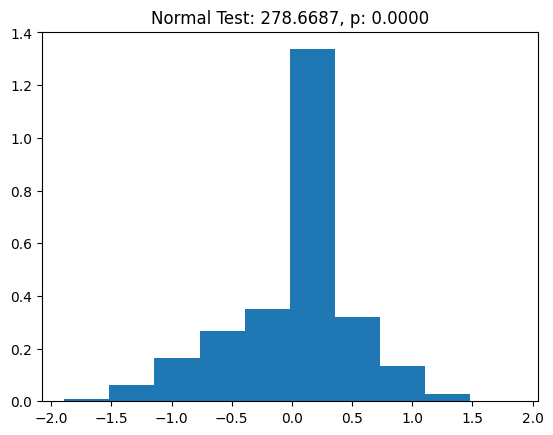

In [60]:
# Learning Phase

# Toggle usage of non-transformed data (use_orig = True)
use_orig = False

if use_orig:
    learning_df = pd.concat([scarce_learning_data_orig, control_learning_data_orig]).reset_index(drop=True)
else: 
    learning_df = pd.concat([scarce_learning_data, control_learning_data]).reset_index(drop=True)

formula = '{} ~ trialNumbers + C(condition) + trialNumbers:C(condition)'.format(response_var)
# Model without the interaction effect (for exploratory analysis)
formula_noint = '{} ~ trialNumbers + C(condition)'.format(response_var)
if data_to_use == "1":
    # Pre-registered only random intercept model and no centering of regressors for first experiment
    standardize_cols = []
    use_random_slope = False
    
else:
    standardize_cols = ["trialNumbers"]
    use_random_slope = True

re_formula = "trialNumbers" if use_random_slope else ""

# Centering the regressors
for col in standardize_cols:
    learning_df[col] = (learning_df[col] - learning_df[col].mean())
    

mixed = True

if mixed:
    glm = smf.mixedlm(formula=formula, data=learning_df, re_formula=re_formula, groups=learning_df['workerId'])
    glm_noint = smf.mixedlm(formula=formula_noint, data=learning_df, re_formula=re_formula, groups=learning_df['workerId'])
else:
    glm = smf.glm(formula=formula, data=learning_df)
    glm_noint = smf.glm(formula=formula_noint, data=learning_df)

l_results = glm.fit()
l_results_noint = glm_noint.fit()

print(l_results.summary())
resids = l_results.resid_response if not mixed else l_results.resid
normaltest = scipy.stats.normaltest(resids)
plt.hist(resids, density=True)
plt.title("Normal Test: {0:0.4f}, p: {1:0.4f}".format(normaltest[0], normaltest[1]))
plt.show()

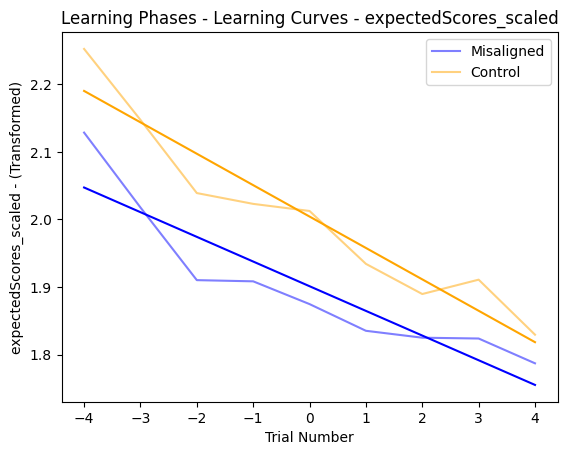

In [61]:
# Plotting the data of both learning phases

x1 = learning_df[learning_df.condition==0].groupby("trialNumbers").mean(numeric_only=True).index
x2 = learning_df[learning_df.condition==1].groupby("trialNumbers").mean(numeric_only=True).index
y1 = learning_df[learning_df.condition==0].groupby("trialNumbers").mean(numeric_only=True)[response_var]
y2 = learning_df[learning_df.condition==1].groupby("trialNumbers").mean(numeric_only=True)[response_var]
b1 = l_results.params['trialNumbers']
b2 = l_results.params['trialNumbers'] + l_results.params['trialNumbers:C(condition)[T.1]']
i1 = l_results.params['Intercept']
i2 = l_results.params['Intercept'] + l_results.params['C(condition)[T.1]']

plt.plot(x2, y2, color='b', alpha=0.5, label="Misaligned")
plt.plot(x1, y1, color='orange', alpha=0.5, label="Control")


# Slope lines
plt.plot(x1, np.array(x1) * b1 + i1, color='orange')
plt.plot(x2, np.array(x2) * b2 + i2, color='b')
plt.title("Learning Phases - Learning Curves - {}".format(response_var))
plt.xlabel("Trial Number")
plt.ylabel("{} - {}".format(response_var, "(Not Transformed)" if use_orig else "(Transformed)"))
plt.legend()


plt.show()



/Volumes/DataDrive/mcl-misalignment-mouselab/analysis/aenv/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Volumes/DataDrive/mcl-misalignment-mouselab/analysis/aenv/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/Volumes/DataDrive/mcl-misalignment-mouselab/analysis/aenv/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


                  Mixed Linear Model Regression Results
Model:              MixedLM   Dependent Variable:   expectedScores_scaled
No. Observations:   16151     Method:               REML                 
No. Groups:         521       Scale:                24.3049              
Min. group size:    31        Log-Likelihood:       -51850.0781          
Max. group size:    31        Converged:            Yes                  
Mean group size:    31.0                                                 
-------------------------------------------------------------------------
                               Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------------
Intercept                      16.378    0.586 27.937 0.000 15.229 17.527
C(condition)[T.1]              -0.159    0.831 -0.192 0.848 -1.789  1.470
trialNumbers                   -0.082    0.250 -0.327 0.743 -0.571  0.408
trialNumbers:C(condition)[T.1]  0.000    0.354  0.001 0.

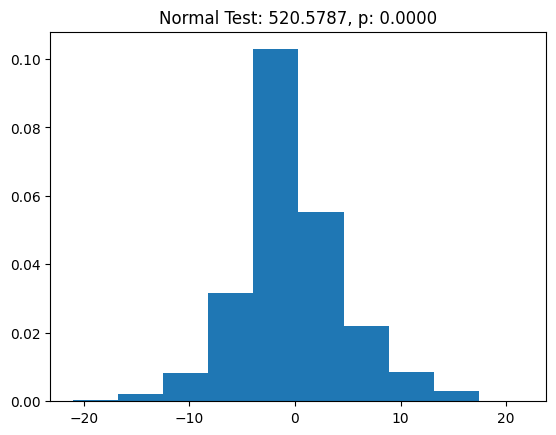

In [62]:
# Performance Phase

use_orig = False

if use_orig:
    performance_df = pd.concat([scarce_performance_data_orig, control_performance_data_orig]).reset_index(drop=True)
else: 
    performance_df = pd.concat([scarce_performance_data, control_performance_data]).reset_index(drop=True)
    
formula = '{} ~ trialNumbers + C(condition) + trialNumbers:C(condition)'.format(response_var)
if data_to_use == "1":
    standardize_cols = []
    use_random_slope = False
else:
    standardize_cols = ["trialNumbers"]
    use_random_slope = True

re_formula = "trialNumbers" if use_random_slope else ""

for col in standardize_cols:
    performance_df[col] = (performance_df[col] - performance_df[col].mean())#}/learning_df[col].std()

performance_df[response_var] = performance_df[response_var] * 10
mixed = True

if mixed:
    glm = smf.mixedlm(formula=formula, data=performance_df, re_formula=re_formula, groups=performance_df['workerId'])
else:
    glm = smf.glm(formula=formula, data=performance_df)

results = glm.fit()

print(results.summary())
resids = results.resid_response if not mixed else results.resid
normaltest = scipy.stats.normaltest(resids)
plt.hist(resids, density=True)
plt.title("Normal Test: {0:0.4f}, p: {1:0.4f}".format(normaltest[0], normaltest[1]))
plt.show()

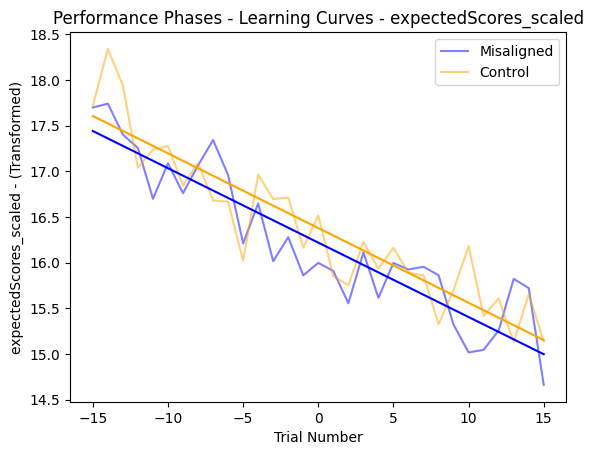

In [63]:
# Plotting the data of both performance phases together

x1 = performance_df[performance_df.condition==0].groupby("trialNumbers").mean(numeric_only=True).index
x2 = performance_df[performance_df.condition==1].groupby("trialNumbers").mean(numeric_only=True).index
y1 = performance_df[performance_df.condition==0].groupby("trialNumbers").mean(numeric_only=True)[response_var]
y2 = performance_df[performance_df.condition==1].groupby("trialNumbers").mean(numeric_only=True)[response_var]
b1 = results.params['trialNumbers']
b2 = results.params['trialNumbers'] + results.params['trialNumbers:C(condition)[T.1]']
i1 = results.params['Intercept']
i2 = results.params['Intercept'] + results.params['C(condition)[T.1]']
        

plt.plot(x2, y2, color='b', alpha=0.5, label="Misaligned")
plt.plot(x1, y1, color='orange', alpha=0.5, label="Control")


# Slope lines
plt.plot(x1, np.array(x1) * b1 + i1, color='orange')
plt.plot(x2, np.array(x2) * b2 + i2, color='b')
plt.title("Performance Phases - Learning Curves - {}".format(response_var))
plt.xlabel("Trial Number")
plt.ylabel("{} - {}".format(response_var, "(Not Transformed)" if use_orig else "(Transformed)"))
plt.legend()

plt.show()

In [64]:
# Output to LaTeX table

display_formula = "{} ~ trialNumbers*C(condition)".format(response_var)
if use_random_slope: 
    display_formula +=  "+ (1 + trialNumbers|participant)"
else:
    display_formula +=  "+ (1 + participant)"
table = LMM_to_table(l_results, results, "1.1", display_formula, data_to_use_master)

In [65]:
print(table)

\newcommand{\tableMisCombinedOneOne}{
\begin{table} 
\centering 
	\caption{LMM results for Analysis 1.1} 
	\begin{tabular}{c|CC|CC} 
		\hline 
		\multicolumn{5}{c}{ }\\[-1em] 
		\multicolumn{5}{c}{expectedScores\_scaled $\sim$ trialNumbers$*$condition$+$ (1 $+$ trialNumbers$|$participant)}\\ 
		&&&&\\[-1em] 
		\hline 
		&&&&\\[-1em] 
		\multirow{2}{*}{\textbf{Regressor}} & \multicolumn{2}{c|}{\textbf{Rapid Learning Phase}} & \multicolumn{2}{c}{\textbf{Slow Improvement Phase}} \\ 
		&&&&\\[-1em] 
		& $\beta$ & $p$ & $\beta$ & $p$\\ 
		&&&&\\[-1em] 
		\hline 
		&&&&\\[-1em] 
		Intercept & \textbf{2.00} & \textbf{0.00} & \textbf{16.38} & \textbf{0.00} \\ 
		condition & \textbf{-0.10} & \textbf{0.03} & -0.16 & 0.85 \\ 
		trialNumbers & \textbf{-0.05} & \textbf{0.00} & -0.08 & 0.74 \\ 
		trialNumbers:condition & 0.01 & 0.22 & 0.00 & 1.00 \\ 
		Var RI & \textbf{0.91} & \textbf{0.00} & 3.67 & nan \\ 
		Var RS & \textbf{0.01} & \textbf{0.00} & 0.67 & nan \\ 
		Cov RI$*$RS & \textbf{0.05} & \te

## Exploratory Analysis - R^2 calculation for interaction coefficient

In [66]:
def calc_bic_lmm(mdf):
    # print(mdf.nobs, mdf.df_modelwc)
    return -2 * mdf.llf + np.log(mdf.nobs) * (mdf.df_modelwc)

In [67]:
# Model selection using BIC

bic = calc_bic_lmm(l_results)
bic_noint = calc_bic_lmm(l_results_noint)

bic_diff = bic - bic_noint
bic_diff

14.727769786120916

In [71]:
# Calculating variance explained by random effects
# https://besjournals.onlinelibrary.wiley.com/doi/10.1111/2041-210X.12225

design_matrix = np.array(learning_df[["trialNumbers"]])
int_col = np.ones((design_matrix.shape[0], 1))

design_matrix = np.c_[int_col, design_matrix]
    
mul = np.matmul(design_matrix, np.array(results.cov_re))
final = np.matmul(mul, design_matrix.T)

In [72]:
# R^2 calculation

# with interaction_effect
var_f = l_results.fittedvalues.var()
var_e = l_results.resid.var()
var_re = np.diag(final).sum() / len(final)

r_2 = (var_f + var_re) / (var_f + var_e + var_re)

# without interaction effect
var_f = l_results_noint.fittedvalues.var()
var_e = l_results_noint.resid.var()
var_re = np.diag(final).sum() / len(final)

r_2_noint = (var_f + var_re) / (var_f + var_e + var_re)

In [73]:
# Calculating effect size f^2

rsquared_2 = r_2
rsquared_1 = r_2_noint

f_squared = (rsquared_2 - rsquared_1)/(1-rsquared_2)
f_squared

6.555358341817925e-05

# Analysis 1.2 - Independent Samples T-test of Performance b/w Conditions

In [76]:
# Select the response variable for this analysis

response_var = "expectedScores_scaled"
assert (response_var in response_vars), "{} is not a valid response variable".format(response_var)

In [77]:
use_transformed = True
exclude_invalid_clicks = False

if use_transformed:
    c_data = control_performance_data
    s_data = scarce_performance_data
else:
    c_data = control_performance_data_orig
    s_data = scarce_performance_data_orig

if exclude_invalid_clicks:
    c_data = c_data.loc[c_data.clickStratsValid]
    s_data = s_data.loc[s_data.clickStratsValid]

    # Using the transformed data divided into phases
    
control_averages = c_data.groupby('workerId').mean(numeric_only=True)
scarce_averages = s_data.groupby('workerId').mean(numeric_only=True)
    

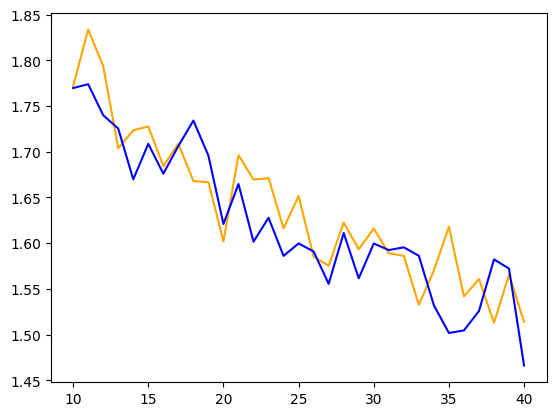

In [78]:
plt.figure()
plt.plot(np.sort(np.unique(control_performance_data.trialNumbers)), control_performance_data.groupby('trialNumbers').mean(numeric_only=True)[response_var], color='orange')
plt.plot(np.sort(np.unique(scarce_performance_data.trialNumbers)), scarce_performance_data.groupby('trialNumbers').mean(numeric_only=True)[response_var], color='b')
plt.show()

1.6377901414874445 0.6453661157200974
1.621861106916838 0.6109487674351693


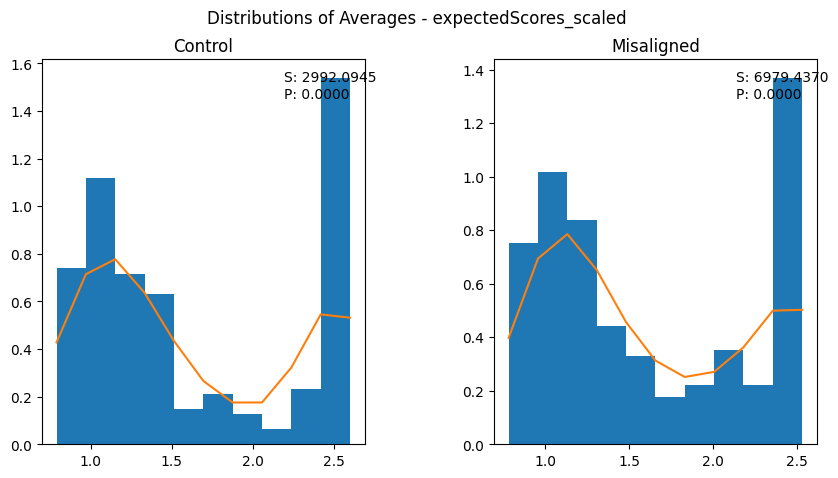

In [79]:

# Plotting normality for both groups

fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(10, 5),squeeze=False)
plt.suptitle("Distributions of Averages - {}".format(response_var))
ax = ax.flatten()

for idx, group in enumerate([(control_averages, "Control"), (scarce_averages, "Misaligned")]):
    data = group[0][response_var]
    label = group[1]
    print(data.mean(), data.std())#/np.sqrt(len(data)))
    normaltest = scipy.stats.normaltest(data)
    density = scipy.stats.gaussian_kde(data)
    n, x, _ = ax[idx].hist(data, density=True)
    ax[idx].set_title(label)
    ax[idx].plot(x, density(x))
    ax[idx].text(0.75,0.9, "S: {0:0.4f}\nP: {1:0.4f}".format(normaltest.statistic, normaltest.pvalue), transform=ax[idx].transAxes)

plt.subplots_adjust(
                wspace=0.4, 
                hspace=0.4)
plt.show()

In [80]:
# Perform independent T-test if data is normal


two = scipy.stats.ttest_ind(scarce_averages[response_var], control_averages[response_var], equal_var=True, alternative='two-sided')
less = scipy.stats.ttest_ind(scarce_averages[response_var], control_averages[response_var], equal_var=True, alternative='less')
greater = scipy.stats.ttest_ind(scarce_averages[response_var], control_averages[response_var], equal_var=True, alternative='greater')

print("Response Variable: {}".format(response_var))
print("Two-Sided:")
print("\tStatistic: {0:0.3f}\n\tP-value: {1}".format(two.statistic, two.pvalue))
print("Misaligned < Control:")
print("\tStatistic: {0:0.3f}\n\tP-value: {1}".format(less.statistic, less.pvalue))
print("Misaligned > Control:")
print("\tStatistic: {0:0.3f}\n\tP-value: {1}".format(greater.statistic, greater.pvalue))

Response Variable: expectedScores_scaled
Two-Sided:
	Statistic: -0.289
	P-value: 0.7725067877219816
Misaligned < Control:
	Statistic: -0.289
	P-value: 0.3862533938609908
Misaligned > Control:
	Statistic: -0.289
	P-value: 0.6137466061390091


In [81]:
# Perform Mann-Whitney U test if data is not normal

two = scipy.stats.mannwhitneyu(scarce_averages[response_var], control_averages[response_var], alternative='two-sided')
less = scipy.stats.mannwhitneyu(scarce_averages[response_var], control_averages[response_var], alternative='less')
greater = scipy.stats.mannwhitneyu(scarce_averages[response_var], control_averages[response_var], alternative='greater')

print("Two-Sided:")
print("\tStatistic: {0:0.3f}\n\tP-value: {1}".format(two.statistic, two.pvalue))
print("Misaligned < Control:")
print("\tStatistic: {0:0.3f}\n\tP-value: {1}".format(less.statistic, less.pvalue))
print("Misaligned > Control:")
print("\tStatistic: {0:0.3f}\n\tP-value: {1}".format(greater.statistic, greater.pvalue))

Two-Sided:
	Statistic: 32618.000
	P-value: 0.4452717644648122
Misaligned < Control:
	Statistic: 32618.000
	P-value: 0.2226358822324061
Misaligned > Control:
	Statistic: 32618.000
	P-value: 0.7775377222713316


# Analysis 2.1 - Linear Regression: AvgClickDepth vs. Trial Number x Condition

In [87]:
# Select the response variable for this analysis

response_var = "avgClickLevel"
assert (response_var in response_vars), "{} is not a valid response variable".format(response_var)

/Volumes/DataDrive/mcl-misalignment-mouselab/analysis/aenv/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


                  Mixed Linear Model Regression Results
Model:                  MixedLM     Dependent Variable:     avgClickLevel
No. Observations:       4527        Method:                 REML         
No. Groups:             503         Scale:                  0.0292       
Min. group size:        9           Log-Likelihood:         581.9283     
Max. group size:        9           Converged:              Yes          
Mean group size:        9.0                                              
-------------------------------------------------------------------------
                               Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------------
Intercept                       0.412    0.015 26.864 0.000  0.382  0.442
C(condition)[T.1]               0.042    0.022  1.893 0.058 -0.001  0.085
trialNumbers                    0.025    0.002 10.229 0.000  0.020  0.030
trialNumbers:C(condition)[T.1] -0.006    0.004 -1.592 0.

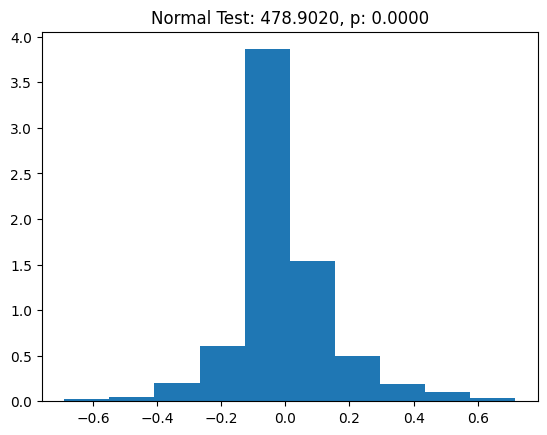

In [88]:
# Learning Phase

use_orig = False

if use_orig:
    learning_df = pd.concat([scarce_learning_data_orig, control_learning_data_orig]).reset_index(drop=True)
else: 
    learning_df = pd.concat([scarce_learning_data, control_learning_data]).reset_index(drop=True)

# Filter out participants whose click strategies are not valid (According to criteria 0.0)
learning_df = learning_df.loc[learning_df.clickStratsValid]

# Select the model based on experiment pre-registration
formula = '{} ~ trialNumbers + C(condition) + trialNumbers:C(condition)'.format(response_var)
if data_to_use == "1":
    use_random_slope = False
    standardize_cols = []

else:
    use_random_slope = True
    standardize_cols = ["trialNumbers"]
re_formula = "trialNumbers" if use_random_slope else ""
    
    
for col in standardize_cols:
    learning_df[col] = (learning_df[col] - learning_df[col].mean()) #/ learning_df[col].std()



mixed = True

if mixed:
    glm = smf.mixedlm(formula=formula, data=learning_df, re_formula=re_formula, groups=learning_df['workerId'])
else:
    glm = smf.glm(formula=formula, data=learning_df)

l_results = glm.fit()

print(l_results.summary())
resids = l_results.resid_response if not mixed else l_results.resid
normaltest = scipy.stats.normaltest(resids)
plt.hist(resids, density=True)
plt.title("Normal Test: {0:0.4f}, p: {1:0.4f}".format(normaltest[0], normaltest[1]))
plt.show()

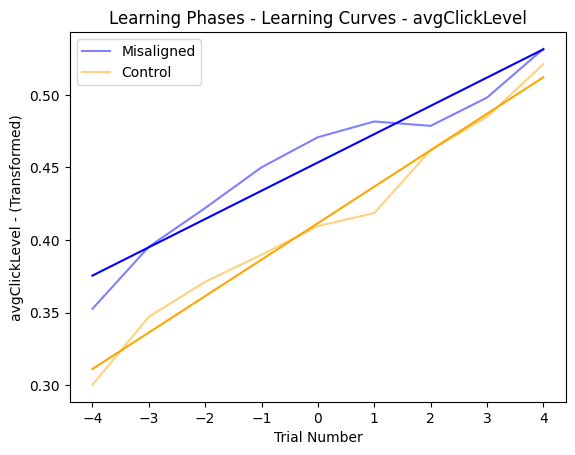

In [89]:
# Plotting the data of both learning phases

x1 = learning_df[learning_df.condition==0].groupby("trialNumbers").mean(numeric_only=True).index
x2 = learning_df[learning_df.condition==1].groupby("trialNumbers").mean(numeric_only=True).index
y1 = learning_df[learning_df.condition==0].groupby("trialNumbers").mean(numeric_only=True)[response_var]
y2 = learning_df[learning_df.condition==1].groupby("trialNumbers").mean(numeric_only=True)[response_var]
b1 = l_results.params['trialNumbers']
b2 = l_results.params['trialNumbers'] + l_results.params['trialNumbers:C(condition)[T.1]']
i1 = l_results.params['Intercept']
i2 = l_results.params['Intercept'] + l_results.params['C(condition)[T.1]']

plt.plot(x2, y2, color='b', alpha=0.5, label="Misaligned")
plt.plot(x1, y1, color='orange', alpha=0.5, label="Control")


# Slope lines
plt.plot(x1, np.array(x1) * b1 + i1, color='orange')
plt.plot(x2, np.array(x2) * b2 + i2, color='b')
plt.title("Learning Phases - Learning Curves - {}".format(response_var))
plt.xlabel("Trial Number")
plt.ylabel("{} - {}".format(response_var, "(Not Transformed)" if use_orig else "(Transformed)"))
plt.legend()


plt.show()



/Volumes/DataDrive/mcl-misalignment-mouselab/analysis/aenv/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


                  Mixed Linear Model Regression Results
Model:                  MixedLM     Dependent Variable:     avgClickLevel
No. Observations:       15593       Method:                 REML         
No. Groups:             503         Scale:                  2.8793       
Min. group size:        31          Log-Likelihood:         -32088.9348  
Max. group size:        31          Converged:              Yes          
Mean group size:        31.0                                             
-------------------------------------------------------------------------
                               Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------------
Intercept                       6.214    0.200 31.027 0.000  5.821  6.606
C(condition)[T.1]              -0.037    0.289 -0.127 0.899 -0.603  0.529
trialNumbers                    0.044    0.006  7.356 0.000  0.032  0.056
trialNumbers:C(condition)[T.1]  0.005    0.009  0.536 0.

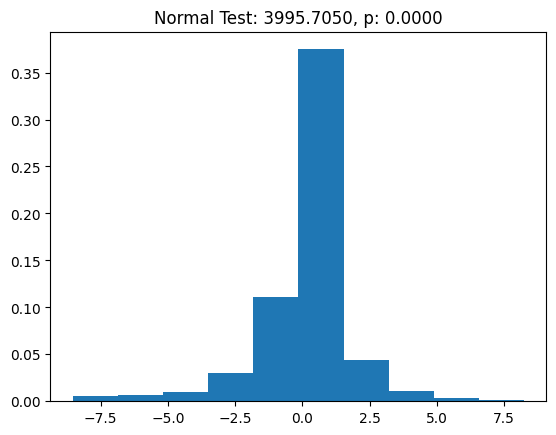

In [90]:
# Performance Phase

use_orig = False

if use_orig:
    performance_df = pd.concat([scarce_performance_data_orig, control_performance_data_orig]).reset_index(drop=True)
else: 
    performance_df = pd.concat([scarce_performance_data, control_performance_data]).reset_index(drop=True)

# Select the model based on experiment pre-registration
formula = '{} ~ trialNumbers + C(condition) + trialNumbers:C(condition)'.format(response_var)
if data_to_use == "1":
    use_random_slope = False
    standardize_cols = []
else:
    use_random_slope = True
    standardize_cols = ["trialNumbers"]
re_formula = "trialNumbers" if use_random_slope else ""
    
for col in standardize_cols:
    performance_df[col] = (performance_df[col] - performance_df[col].mean())#}/learning_df[col].std()

# Filter out participants whose click strategies are not valid
performance_df = performance_df.loc[performance_df.clickStratsValid]
performance_df[response_var] = performance_df[response_var] * 10

mixed = True

if mixed:
    glm = smf.mixedlm(formula=formula, data=performance_df, re_formula=re_formula, groups=performance_df['workerId'])
else:
    glm = smf.glm(formula=formula, data=performance_df)

results = glm.fit()

print(results.summary())
resids = results.resid_response if not mixed else results.resid
normaltest = scipy.stats.normaltest(resids)
plt.hist(resids, density=True)
plt.title("Normal Test: {0:0.4f}, p: {1:0.4f}".format(normaltest[0], normaltest[1]))
plt.show()

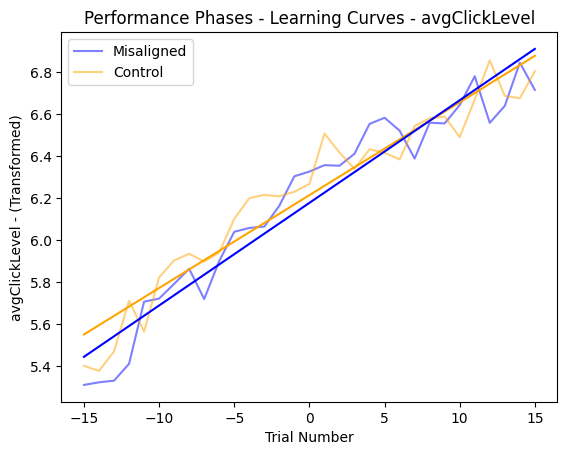

In [91]:
# Plotting the data of both performance phases together

x1 = performance_df[performance_df.condition==0].groupby("trialNumbers").mean(numeric_only=True).index
x2 = performance_df[performance_df.condition==1].groupby("trialNumbers").mean(numeric_only=True).index
y1 = performance_df[performance_df.condition==0].groupby("trialNumbers").mean(numeric_only=True)[response_var]
y2 = performance_df[performance_df.condition==1].groupby("trialNumbers").mean(numeric_only=True)[response_var]
b1 = results.params['trialNumbers']
b2 = results.params['trialNumbers'] + results.params['trialNumbers:C(condition)[T.1]']
i1 = results.params['Intercept']
i2 = results.params['Intercept'] + results.params['C(condition)[T.1]']
        

plt.plot(x2, y2, color='b', alpha=0.5, label="Misaligned")
plt.plot(x1, y1, color='orange', alpha=0.5, label="Control")


# Slope lines
plt.plot(x1, np.array(x1) * b1 + i1, color='orange')
plt.plot(x2, np.array(x2) * b2 + i2, color='b')
plt.title("Performance Phases - Learning Curves - {}".format(response_var))
plt.xlabel("Trial Number")
plt.ylabel("{} - {}".format(response_var, "(Not Transformed)" if use_orig else "(Transformed)"))
plt.legend()

plt.show()

In [92]:
# Output to LaTeX table

display_formula = "{} ~ trialNumbers*C(condition)".format(response_var)
if use_random_slope: 
    display_formula +=  "+ (1 + trialNumbers|participant)"
else:
    display_formula +=  "+ (1 + participant)"
table = LMM_to_table(l_results, results, "2.1", display_formula, data_to_use_master)

In [93]:
print(table)

\newcommand{\tableMisCombinedTwoOne}{
\begin{table} 
\centering 
	\caption{LMM results for Analysis 2.1} 
	\begin{tabular}{c|CC|CC} 
		\hline 
		\multicolumn{5}{c}{ }\\[-1em] 
		\multicolumn{5}{c}{avgClickLevel $\sim$ trialNumbers$*$condition$+$ (1 $+$ trialNumbers$|$participant)}\\ 
		&&&&\\[-1em] 
		\hline 
		&&&&\\[-1em] 
		\multirow{2}{*}{\textbf{Regressor}} & \multicolumn{2}{c|}{\textbf{Rapid Learning Phase}} & \multicolumn{2}{c}{\textbf{Slow Improvement Phase}} \\ 
		&&&&\\[-1em] 
		& $\beta$ & $p$ & $\beta$ & $p$\\ 
		&&&&\\[-1em] 
		\hline 
		&&&&\\[-1em] 
		Intercept & \textbf{0.41} & \textbf{0.00} & \textbf{6.21} & \textbf{0.00} \\ 
		condition & 0.04 & 0.06 & -0.04 & 0.90 \\ 
		trialNumbers & \textbf{0.03} & \textbf{0.00} & \textbf{0.04} & \textbf{0.00} \\ 
		trialNumbers:condition & -0.01 & 0.11 & 0.00 & 0.59 \\ 
		Var RI & \textbf{1.99} & \textbf{0.00} & \textbf{3.60} & \textbf{0.00} \\ 
		Var RS & \textbf{0.04} & \textbf{0.00} & \textbf{0.00} & \textbf{0.00} \\ 
		Cov RI$

# Analysis 2.2 - Linear Regression: ClicksL5 vs. Trial Number x Condition

In [94]:
# Select the response variable for this analysis

response_var = "clicksL5"
assert (response_var in response_vars), "{} is not a valid response variable".format(response_var)

                        Mixed Linear Model Regression Results
Model:                     MixedLM          Dependent Variable:          clicksL5    
No. Observations:          4527             Method:                      REML        
No. Groups:                503              Scale:                       6701124.5614
Min. group size:           9                Log-Likelihood:              -42824.3990 
Max. group size:           9                Converged:                   Yes         
Mean group size:           9.0                                                       
-------------------------------------------------------------------------------------
                                  Coef.     Std.Err.   z    P>|z|   [0.025    0.975] 
-------------------------------------------------------------------------------------
Intercept                         11884.029  205.873 57.725 0.000 11480.525 12287.533
C(condition)[T.1]                  -339.745  296.808 -1.145 0.252  -921.479   

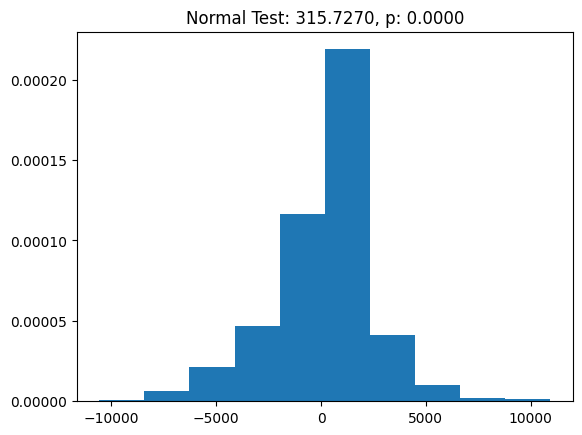

In [95]:
# Learning Phase

use_orig = False

if use_orig:
    learning_df = pd.concat([scarce_learning_data_orig, control_learning_data_orig]).reset_index(drop=True)
else: 
    learning_df = pd.concat([scarce_learning_data, control_learning_data]).reset_index(drop=True)

# Select the model based on experiment pre-registration
formula = '{} ~ trialNumbers + C(condition) + trialNumbers:C(condition)'.format(response_var)
if data_to_use == "1":
    use_random_slope = False
    standardize_cols = []
#     standardize_cols = ["trialNumbers"]
#     use_random_slope = True
else:
    use_random_slope = True
    standardize_cols = ["trialNumbers"]
re_formula = "trialNumbers" if use_random_slope else ""

# Filter out participants whose click strategies are not valid
learning_df = learning_df.loc[learning_df.clickStratsValid]

for col in standardize_cols:
    learning_df[col] = (learning_df[col] - learning_df[col].mean())# / learning_df[col].std()

mixed = True

if mixed:
    glm = smf.mixedlm(formula=formula, data=learning_df, re_formula=re_formula,groups=learning_df['workerId'])
else:
    glm = smf.glm(formula=formula, data=learning_df)

l_results = glm.fit()

print(l_results.summary())
resids = l_results.resid_response if not mixed else l_results.resid
normaltest = scipy.stats.normaltest(resids)
plt.hist(resids, density=True)
plt.title("Normal Test: {0:0.4f}, p: {1:0.4f}".format(normaltest[0], normaltest[1]))
plt.show()

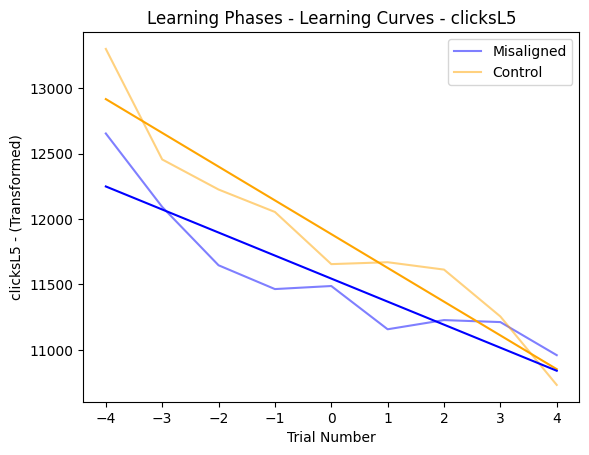

In [96]:
# Plotting the data of both learning phases

x1 = learning_df[learning_df.condition==0].groupby("trialNumbers").mean(numeric_only=True).index
x2 = learning_df[learning_df.condition==1].groupby("trialNumbers").mean(numeric_only=True).index
y1 = learning_df[learning_df.condition==0].groupby("trialNumbers").mean(numeric_only=True)[response_var]
y2 = learning_df[learning_df.condition==1].groupby("trialNumbers").mean(numeric_only=True)[response_var]
b1 = l_results.params['trialNumbers']
b2 = l_results.params['trialNumbers'] + l_results.params['trialNumbers:C(condition)[T.1]']
i1 = l_results.params['Intercept']
i2 = l_results.params['Intercept'] + l_results.params['C(condition)[T.1]']

plt.plot(x2, y2, color='b', alpha=0.5, label="Misaligned")
plt.plot(x1, y1, color='orange', alpha=0.5, label="Control")


# Slope lines
plt.plot(x1, np.array(x1) * b1 + i1, color='orange')
plt.plot(x2, np.array(x2) * b2 + i2, color='b')
plt.title("Learning Phases - Learning Curves - {}".format(response_var))
plt.xlabel("Trial Number")
plt.ylabel("{} - {}".format(response_var, "(Not Transformed)" if use_orig else "(Transformed)"))
plt.legend()


plt.show()



/Volumes/DataDrive/mcl-misalignment-mouselab/analysis/aenv/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Volumes/DataDrive/mcl-misalignment-mouselab/analysis/aenv/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(


                       Mixed Linear Model Regression Results
Model:                      MixedLM         Dependent Variable:         clicksL5    
No. Observations:           15593           Method:                     REML        
No. Groups:                 503             Scale:                      7997129.1163
Min. group size:            31              Log-Likelihood:             -147342.0548
Max. group size:            31              Converged:                  Yes         
Mean group size:            31.0                                                    
------------------------------------------------------------------------------------
                                  Coef.     Std.Err.   z    P>|z|  [0.025    0.975] 
------------------------------------------------------------------------------------
Intercept                          9895.222  232.775 42.510 0.000 9438.992 10351.452
C(condition)[T.1]                   377.652  335.592  1.125 0.260 -280.097  1035.401
tria

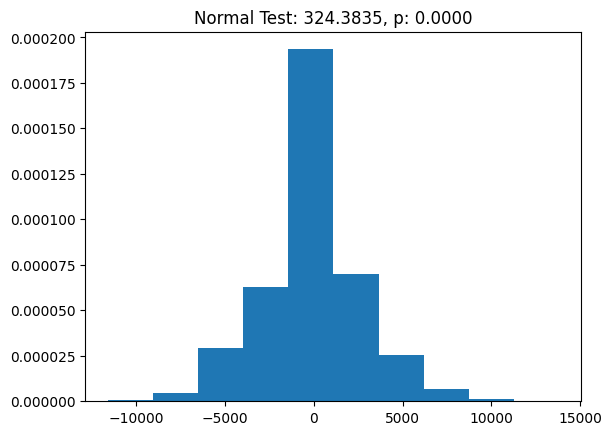

In [97]:
# Performance Phase

use_orig = False

if use_orig:
    performance_df = pd.concat([scarce_performance_data_orig, control_performance_data_orig]).reset_index(drop=True)
else: 
    performance_df = pd.concat([scarce_performance_data, control_performance_data]).reset_index(drop=True)

# Select the model based on experiment pre-registration
formula = '{} ~ trialNumbers + C(condition) + trialNumbers:C(condition)'.format(response_var)
if data_to_use == "1":
    use_random_slope = False
    standardize_cols = []
else:
    use_random_slope = True
    standardize_cols = ["trialNumbers"]
re_formula = "trialNumbers" if use_random_slope else ""

for col in standardize_cols:
    performance_df[col] = (performance_df[col] - performance_df[col].mean())#}/learning_df[col].std()


# Filter out participants whose click strategies are not valid
performance_df = performance_df.loc[performance_df.clickStratsValid]

mixed = True

if mixed:
    glm = smf.mixedlm(formula=formula, data=performance_df, re_formula=re_formula, groups=performance_df['workerId'])
else:
    glm = smf.glm(formula=formula, data=performance_df)

results = glm.fit()

print(results.summary())
resids = results.resid_response if not mixed else results.resid
normaltest = scipy.stats.normaltest(resids)
plt.hist(resids, density=True)
plt.title("Normal Test: {0:0.4f}, p: {1:0.4f}".format(normaltest[0], normaltest[1]))
plt.show()

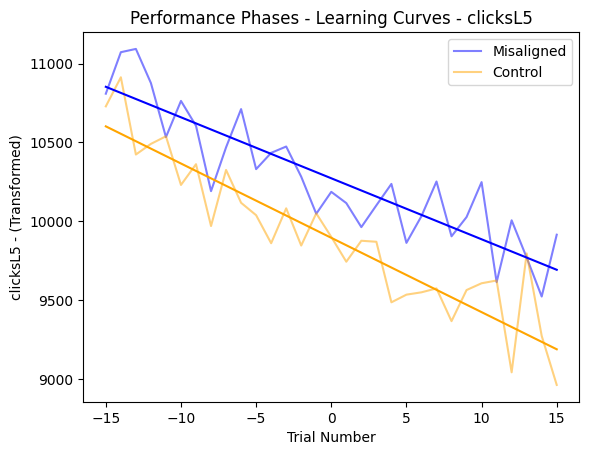

In [98]:
# Plotting the data of both performance phases together

x1 = performance_df[performance_df.condition==0].groupby("trialNumbers").mean(numeric_only=True).index
x2 = performance_df[performance_df.condition==1].groupby("trialNumbers").mean(numeric_only=True).index
y1 = performance_df[performance_df.condition==0].groupby("trialNumbers").mean(numeric_only=True)[response_var]
y2 = performance_df[performance_df.condition==1].groupby("trialNumbers").mean(numeric_only=True)[response_var]
b1 = results.params['trialNumbers']
b2 = results.params['trialNumbers'] + results.params['trialNumbers:C(condition)[T.1]']
i1 = results.params['Intercept']
i2 = results.params['Intercept'] + results.params['C(condition)[T.1]']
        

plt.plot(x2, y2, color='b', alpha=0.5, label="Misaligned")
plt.plot(x1, y1, color='orange', alpha=0.5, label="Control")


# Slope lines
plt.plot(x1, np.array(x1) * b1 + i1, color='orange')
plt.plot(x2, np.array(x2) * b2 + i2, color='b')
plt.title("Performance Phases - Learning Curves - {}".format(response_var))
plt.xlabel("Trial Number")
plt.ylabel("{} - {}".format(response_var, "(Not Transformed)" if use_orig else "(Transformed)"))
plt.legend()

plt.show()

In [99]:
# Output to LaTeX table

display_formula = "{} ~ trialNumbers*C(condition)".format(response_var)
if use_random_slope: 
    display_formula +=  "+ (1 + trialNumbers|participant)"
else:
    display_formula +=  "+ (1 + participant)"
table = LMM_to_table(l_results, results, "2.2", display_formula, data_to_use_master)

In [100]:
print(table)

\newcommand{\tableMisCombinedTwoTwo}{
\begin{table} 
\centering 
	\caption{LMM results for Analysis 2.2} 
	\begin{tabular}{c|CC|CC} 
		\hline 
		\multicolumn{5}{c}{ }\\[-1em] 
		\multicolumn{5}{c}{clicksL5 $\sim$ trialNumbers$*$condition$+$ (1 $+$ trialNumbers$|$participant)}\\ 
		&&&&\\[-1em] 
		\hline 
		&&&&\\[-1em] 
		\multirow{2}{*}{\textbf{Regressor}} & \multicolumn{2}{c|}{\textbf{Rapid Learning Phase}} & \multicolumn{2}{c}{\textbf{Slow Improvement Phase}} \\ 
		&&&&\\[-1em] 
		& $\beta$ & $p$ & $\beta$ & $p$\\ 
		&&&&\\[-1em] 
		\hline 
		&&&&\\[-1em] 
		Intercept & \textbf{11884.03} & \textbf{0.00} & \textbf{9895.22} & \textbf{0.00} \\ 
		condition & -339.75 & 0.25 & 377.65 & 0.26 \\ 
		trialNumbers & \textbf{-257.94} & \textbf{0.00} & \textbf{-47.14} & \textbf{0.00} \\ 
		trialNumbers:condition & 81.94 & 0.06 & 8.45 & 0.37 \\ 
		Var RI & \textbf{1.54} & \textbf{0.00} & \textbf{1.74} & \textbf{0.00} \\ 
		Var RS & \textbf{0.02} & \textbf{0.00} & \textbf{0.00} & \textbf{0.00} \\

# Analysis 2.3 - Linear Regression: ClicksL1 vs. Trial Number x Condition

In [101]:
# Select the response variable for this analysis

response_var = "clicksL1"
assert (response_var in response_vars), "{} is not a valid response variable".format(response_var)

                  Mixed Linear Model Regression Results
Model:                  MixedLM      Dependent Variable:      clicksL1   
No. Observations:       4527         Method:                  REML       
No. Groups:             503          Scale:                   35.1583    
Min. group size:        9            Log-Likelihood:          -15272.2709
Max. group size:        9            Converged:               Yes        
Mean group size:        9.0                                              
-------------------------------------------------------------------------
                               Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------------
Intercept                       6.124    0.402 15.235 0.000  5.336  6.912
C(condition)[T.1]              -0.256    0.580 -0.441 0.659 -1.392  0.880
trialNumbers                   -0.577    0.070 -8.268 0.000 -0.713 -0.440
trialNumbers:C(condition)[T.1]  0.209    0.101  2.074 0.

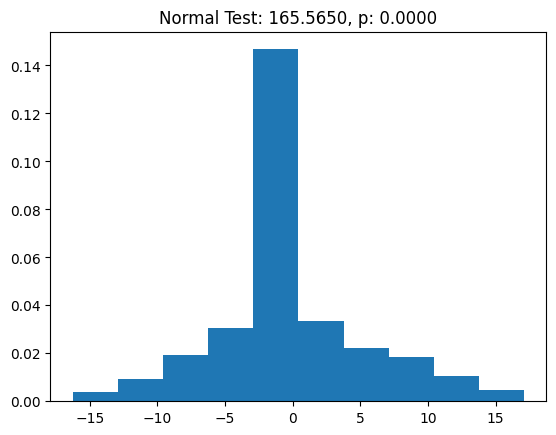

In [102]:
# Learning Phase

use_orig = False

if use_orig:
    learning_df = pd.concat([scarce_learning_data_orig, control_learning_data_orig]).reset_index(drop=True)
else: 
    learning_df = pd.concat([scarce_learning_data, control_learning_data]).reset_index(drop=True)

# Select the model based on experiment pre-registration
formula = '{} ~ trialNumbers + C(condition) + trialNumbers:C(condition)'.format(response_var)
if data_to_use == "1":
    use_random_slope = False
    standardize_cols = []
else:
    use_random_slope = True
    standardize_cols = ["trialNumbers"]
re_formula = "trialNumbers" if use_random_slope else ""

# Filter out participants whose click strategies are not valid
learning_df = learning_df.loc[learning_df.clickStratsValid]

for col in standardize_cols:
    learning_df[col] = (learning_df[col] - learning_df[col].mean())# / learning_df[col].std()

learning_df["clicksL1"] = learning_df["clicksL1"] * 100

mixed = True

if mixed:
    glm = smf.mixedlm(formula=formula, data=learning_df, re_formula=re_formula, groups=learning_df['workerId'])
else:
    glm = smf.glm(formula=formula, data=learning_df)

l_results = glm.fit()

print(l_results.summary())
resids = l_results.resid_response if not mixed else l_results.resid
normaltest = scipy.stats.normaltest(resids)
plt.hist(resids, density=True)
plt.title("Normal Test: {0:0.4f}, p: {1:0.4f}".format(normaltest[0], normaltest[1]))
plt.show()

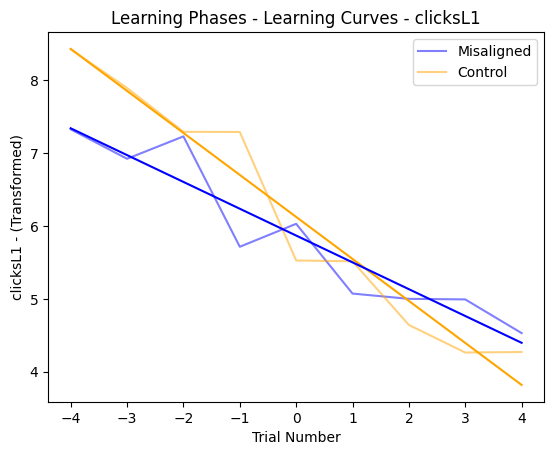

In [103]:
# Plotting the data of both learning phases

x1 = learning_df[learning_df.condition==0].groupby("trialNumbers").mean(numeric_only=True).index
x2 = learning_df[learning_df.condition==1].groupby("trialNumbers").mean(numeric_only=True).index
y1 = learning_df[learning_df.condition==0].groupby("trialNumbers").mean(numeric_only=True)[response_var]
y2 = learning_df[learning_df.condition==1].groupby("trialNumbers").mean(numeric_only=True)[response_var]
b1 = l_results.params['trialNumbers']
b2 = l_results.params['trialNumbers'] + l_results.params['trialNumbers:C(condition)[T.1]']
i1 = l_results.params['Intercept']
i2 = l_results.params['Intercept'] + l_results.params['C(condition)[T.1]']

plt.plot(x2, y2, color='b', alpha=0.5, label="Misaligned")
plt.plot(x1, y1, color='orange', alpha=0.5, label="Control")


# Slope lines
plt.plot(x1, np.array(x1) * b1 + i1, color='orange')
plt.plot(x2, np.array(x2) * b2 + i2, color='b')
plt.title("Learning Phases - Learning Curves - {}".format(response_var))
plt.xlabel("Trial Number")
plt.ylabel("{} - {}".format(response_var, "(Not Transformed)" if use_orig else "(Transformed)"))
plt.legend()


plt.show()



                  Mixed Linear Model Regression Results
Model:                  MixedLM      Dependent Variable:      clicksL1   
No. Observations:       15593        Method:                  REML       
No. Groups:             503          Scale:                   15.3975    
Min. group size:        31           Log-Likelihood:          -44984.5229
Max. group size:        31           Converged:               Yes        
Mean group size:        31.0                                             
-------------------------------------------------------------------------
                               Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------------
Intercept                       2.576    0.338  7.632 0.000  1.915  3.238
C(condition)[T.1]               0.830    0.487  1.706 0.088 -0.124  1.784
trialNumbers                   -0.073    0.013 -5.442 0.000 -0.100 -0.047
trialNumbers:C(condition)[T.1]  0.027    0.019  1.366 0.

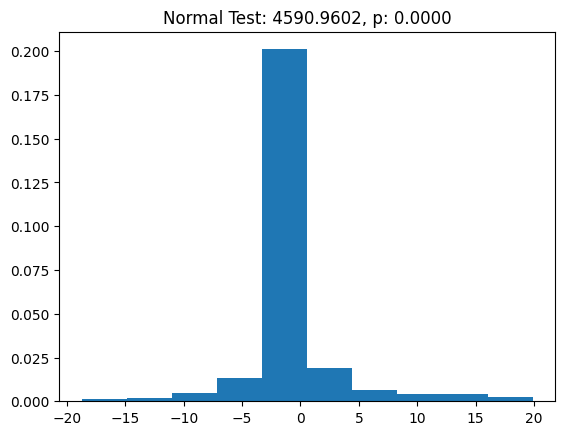

In [104]:
# Performance Phase

use_orig = False

if use_orig:
    performance_df = pd.concat([scarce_performance_data_orig, control_performance_data_orig]).reset_index(drop=True)
else: 
    performance_df = pd.concat([scarce_performance_data, control_performance_data]).reset_index(drop=True)
    
# Select the model based on experiment pre-registration
formula = '{} ~ trialNumbers + C(condition) + trialNumbers:C(condition)'.format(response_var)
if data_to_use == "1":
    use_random_slope = False
    standardize_cols = []
else:
    use_random_slope = True
    standardize_cols = ["trialNumbers"]
re_formula = "trialNumbers" if use_random_slope else ""

for col in standardize_cols:
    performance_df[col] = (performance_df[col] - performance_df[col].mean())#}/learning_df[col].std()

    
# Filter out participants whose click strategies are not valid
performance_df = performance_df.loc[performance_df.clickStratsValid]

performance_df["clicksL1"] = performance_df["clicksL1"] * 100

mixed = True

if mixed:
    glm = smf.mixedlm(formula=formula, data=performance_df, re_formula=re_formula, groups=performance_df['workerId'])
else:
    glm = smf.glm(formula=formula, data=performance_df)

results = glm.fit()

print(results.summary())
resids = results.resid_response if not mixed else results.resid
normaltest = scipy.stats.normaltest(resids)
plt.hist(resids, density=True)
plt.title("Normal Test: {0:0.4f}, p: {1:0.4f}".format(normaltest[0], normaltest[1]))
plt.show()

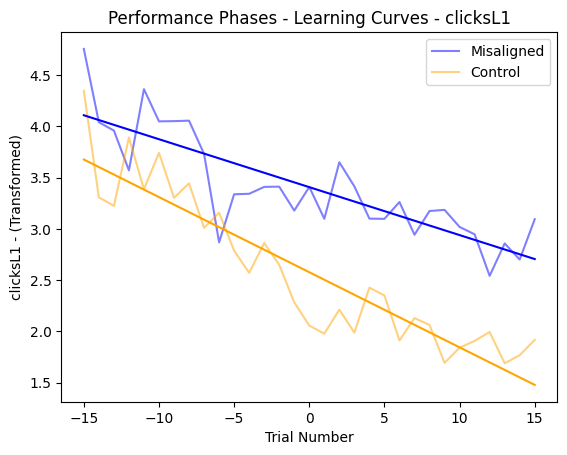

In [105]:
# Plotting the data of both performance phases together

x1 = performance_df[performance_df.condition==0].groupby("trialNumbers").mean(numeric_only=True).index
x2 = performance_df[performance_df.condition==1].groupby("trialNumbers").mean(numeric_only=True).index
y1 = performance_df[performance_df.condition==0].groupby("trialNumbers").mean(numeric_only=True)[response_var]
y2 = performance_df[performance_df.condition==1].groupby("trialNumbers").mean(numeric_only=True)[response_var]
b1 = results.params['trialNumbers']
b2 = results.params['trialNumbers'] + results.params['trialNumbers:C(condition)[T.1]']
i1 = results.params['Intercept']
i2 = results.params['Intercept'] + results.params['C(condition)[T.1]']
        

plt.plot(x2, y2, color='b', alpha=0.5, label="Misaligned")
plt.plot(x1, y1, color='orange', alpha=0.5, label="Control")


# Slope lines
plt.plot(x1, np.array(x1) * b1 + i1, color='orange')
plt.plot(x2, np.array(x2) * b2 + i2, color='b')
plt.title("Performance Phases - Learning Curves - {}".format(response_var))
plt.xlabel("Trial Number")
plt.ylabel("{} - {}".format(response_var, "(Not Transformed)" if use_orig else "(Transformed)"))
plt.legend()

plt.show()

In [106]:
display_formula = "{} ~ trialNumbers*C(condition)".format(response_var)
if use_random_slope: 
    display_formula +=  "+ (1 + trialNumbers|participant)"
else:
    display_formula +=  "+ (1 + participant)"
table = LMM_to_table(l_results, results, "2.3", display_formula, data_to_use_master)

In [107]:
print(table)

\newcommand{\tableMisCombinedTwoThree}{
\begin{table} 
\centering 
	\caption{LMM results for Analysis 2.3} 
	\begin{tabular}{c|CC|CC} 
		\hline 
		\multicolumn{5}{c}{ }\\[-1em] 
		\multicolumn{5}{c}{clicksL1 $\sim$ trialNumbers$*$condition$+$ (1 $+$ trialNumbers$|$participant)}\\ 
		&&&&\\[-1em] 
		\hline 
		&&&&\\[-1em] 
		\multirow{2}{*}{\textbf{Regressor}} & \multicolumn{2}{c|}{\textbf{Rapid Learning Phase}} & \multicolumn{2}{c}{\textbf{Slow Improvement Phase}} \\ 
		&&&&\\[-1em] 
		& $\beta$ & $p$ & $\beta$ & $p$\\ 
		&&&&\\[-1em] 
		\hline 
		&&&&\\[-1em] 
		Intercept & \textbf{6.12} & \textbf{0.00} & \textbf{2.58} & \textbf{0.00} \\ 
		condition & -0.26 & 0.66 & 0.83 & 0.09 \\ 
		trialNumbers & \textbf{-0.58} & \textbf{0.00} & \textbf{-0.07} & \textbf{0.00} \\ 
		trialNumbers:condition & \textbf{0.21} & \textbf{0.04} & 0.03 & 0.17 \\ 
		Var RI & \textbf{1.09} & \textbf{0.00} & \textbf{1.90} & \textbf{0.00} \\ 
		Var RS & \textbf{0.02} & \textbf{0.00} & \textbf{0.00} & \textbf{0.0

# Analysis 2.4 - Linear Regression: Strategy Score vs. Trial Number x Condition

In [115]:
# Select the response variable for this analysis

response_var = "strategyScores_scaled"
assert (response_var in response_vars), "{} is not a valid response variable".format(response_var)

/Volumes/DataDrive/mcl-misalignment-mouselab/analysis/aenv/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


                  Mixed Linear Model Regression Results
Model:              MixedLM   Dependent Variable:   strategyScores_scaled
No. Observations:   4527      Method:               REML                 
No. Groups:         503       Scale:                0.0025               
Min. group size:    9         Log-Likelihood:       5455.6234            
Max. group size:    9         Converged:            Yes                  
Mean group size:    9.0                                                  
-------------------------------------------------------------------------
                               Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------------
Intercept                       0.666    0.010 68.854 0.000  0.647  0.685
C(condition)[T.1]              -0.017    0.014 -1.200 0.230 -0.044  0.011
trialNumbers                    0.009    0.001  7.970 0.000  0.007  0.011
trialNumbers:C(condition)[T.1] -0.006    0.002 -3.416 0.

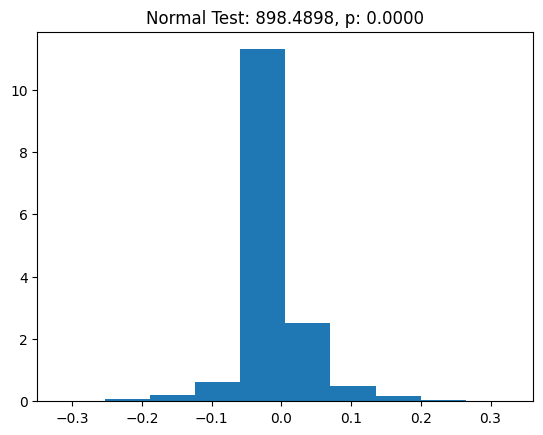

In [116]:
# Learning Phase

use_orig = False

if use_orig:
    learning_df = pd.concat([scarce_learning_data_orig, control_learning_data_orig]).reset_index(drop=True)
else: 
    learning_df = pd.concat([scarce_learning_data, control_learning_data]).reset_index(drop=True)

# Select the model based on experiment pre-registration
formula = '{} ~ trialNumbers + C(condition) + trialNumbers:C(condition)'.format(response_var)
if data_to_use == "1":
    use_random_slope = False
    standardize_cols = []
else:
    use_random_slope = True
    standardize_cols = ["trialNumbers"]
re_formula = "trialNumbers" if use_random_slope else ""

# Filter out participants whose click strategies are not valid
learning_df = learning_df.loc[learning_df.clickStratsValid]

for col in standardize_cols:
    learning_df[col] = (learning_df[col] - learning_df[col].mean())# / learning_df[col].std()

    
mixed = True

if mixed:
    glm = smf.mixedlm(formula=formula, data=learning_df, re_formula=re_formula, groups=learning_df['workerId'])
else:
    glm = smf.glm(formula=formula, data=learning_df)

l_results = glm.fit()

print(l_results.summary())
resids = l_results.resid_response if not mixed else l_results.resid
normaltest = scipy.stats.normaltest(resids)
plt.hist(resids, density=True)
plt.title("Normal Test: {0:0.4f}, p: {1:0.4f}".format(normaltest[0], normaltest[1]))
plt.show()

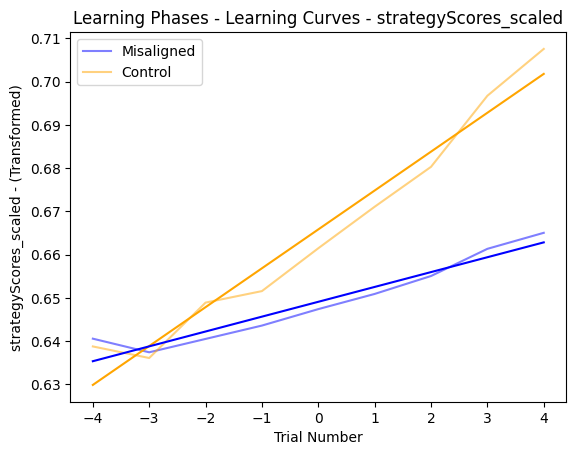

In [117]:
# Plotting the data of both learning phases

x1 = learning_df[learning_df.condition==0].groupby("trialNumbers").mean(numeric_only=True).index
x2 = learning_df[learning_df.condition==1].groupby("trialNumbers").mean(numeric_only=True).index
y1 = learning_df[learning_df.condition==0].groupby("trialNumbers").mean(numeric_only=True)[response_var]
y2 = learning_df[learning_df.condition==1].groupby("trialNumbers").mean(numeric_only=True)[response_var]
b1 = l_results.params['trialNumbers']
b2 = l_results.params['trialNumbers'] + l_results.params['trialNumbers:C(condition)[T.1]']
i1 = l_results.params['Intercept']
i2 = l_results.params['Intercept'] + l_results.params['C(condition)[T.1]']

plt.plot(x2, y2, color='b', alpha=0.5, label="Misaligned")
plt.plot(x1, y1, color='orange', alpha=0.5, label="Control")


# Slope lines
plt.plot(x1, np.array(x1) * b1 + i1, color='orange')
plt.plot(x2, np.array(x2) * b2 + i2, color='b')
plt.title("Learning Phases - Learning Curves - {}".format(response_var))
plt.xlabel("Trial Number")
plt.ylabel("{} - {}".format(response_var, "(Not Transformed)" if use_orig else "(Transformed)"))
plt.legend()


plt.show()



/Volumes/DataDrive/mcl-misalignment-mouselab/analysis/aenv/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


                  Mixed Linear Model Regression Results
Model:              MixedLM   Dependent Variable:   strategyScores_scaled
No. Observations:   15593     Method:               REML                 
No. Groups:         503       Scale:                0.2493               
Min. group size:    31        Log-Likelihood:       -13571.2040          
Max. group size:    31        Converged:            Yes                  
Mean group size:    31.0                                                 
-------------------------------------------------------------------------
                               Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------------
Intercept                       7.648    0.109 70.085 0.000  7.434  7.862
C(condition)[T.1]              -0.685    0.157 -4.356 0.000 -0.994 -0.377
trialNumbers                    0.020    0.003  7.016 0.000  0.014  0.026
trialNumbers:C(condition)[T.1] -0.007    0.004 -1.736 0.

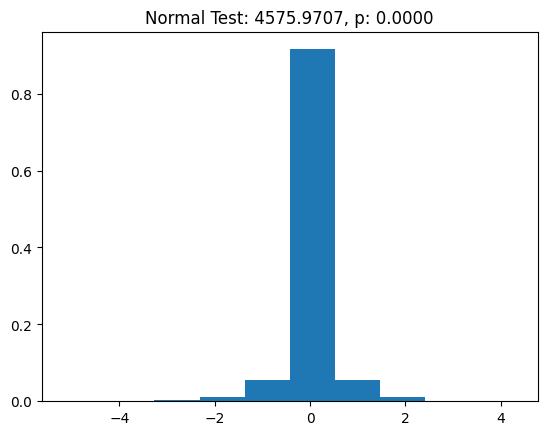

In [118]:
# Performance Phase

use_orig = False

if use_orig:
    performance_df = pd.concat([scarce_performance_data_orig, control_performance_data_orig]).reset_index(drop=True)
else: 
    performance_df = pd.concat([scarce_performance_data, control_performance_data]).reset_index(drop=True)

# Select the model based on experiment pre-registration
formula = '{} ~ trialNumbers + C(condition) + trialNumbers:C(condition)'.format(response_var)
if data_to_use == "1":
    use_random_slope = False
    standardize_cols = []
else:
    use_random_slope = True
    standardize_cols = ["trialNumbers"]
    
re_formula = "trialNumbers" if use_random_slope else ""

for col in standardize_cols:
    performance_df[col] = (performance_df[col] - performance_df[col].mean())#}/learning_df[col].std()
    
# Filter out participants whose click strategies are not valid
performance_df = performance_df.loc[performance_df.clickStratsValid]

performance_df[response_var] = performance_df[response_var] * 10

formula = '{} ~ trialNumbers + C(condition) + trialNumbers:C(condition)'.format(response_var)

mixed = True

if mixed:
    glm = smf.mixedlm(formula=formula, re_formula=re_formula, data=performance_df, groups=performance_df['workerId'])
else:
    glm = smf.glm(formula=formula, data=performance_df)

results = glm.fit()

print(results.summary())
resids = results.resid_response if not mixed else results.resid
normaltest = scipy.stats.normaltest(resids)
plt.hist(resids, density=True)
plt.title("Normal Test: {0:0.4f}, p: {1:0.4f}".format(normaltest[0], normaltest[1]))
plt.show()

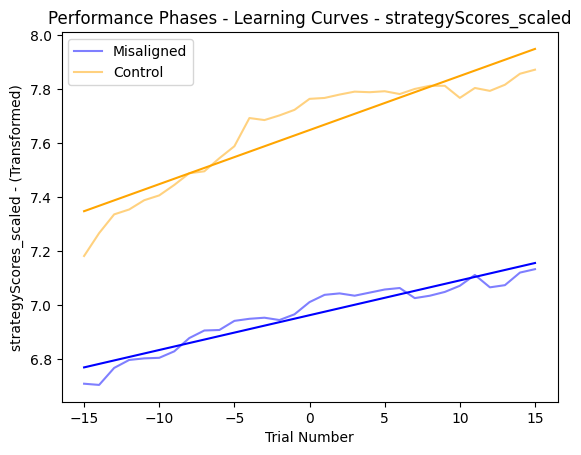

In [119]:
# Plotting the data of both performance phases together

x1 = performance_df[performance_df.condition==0].groupby("trialNumbers").mean(numeric_only=True).index
x2 = performance_df[performance_df.condition==1].groupby("trialNumbers").mean(numeric_only=True).index
y1 = performance_df[performance_df.condition==0].groupby("trialNumbers").mean(numeric_only=True)[response_var]
y2 = performance_df[performance_df.condition==1].groupby("trialNumbers").mean(numeric_only=True)[response_var]
b1 = results.params['trialNumbers']
b2 = results.params['trialNumbers'] + results.params['trialNumbers:C(condition)[T.1]']
i1 = results.params['Intercept']
i2 = results.params['Intercept'] + results.params['C(condition)[T.1]']
        

plt.plot(x2, y2, color='b', alpha=0.5, label="Misaligned")
plt.plot(x1, y1, color='orange', alpha=0.5, label="Control")


# Slope lines
plt.plot(x1, np.array(x1) * b1 + i1, color='orange')
plt.plot(x2, np.array(x2) * b2 + i2, color='b')
plt.title("Performance Phases - Learning Curves - {}".format(response_var))
plt.xlabel("Trial Number")
plt.ylabel("{} - {}".format(response_var, "(Not Transformed)" if use_orig else "(Transformed)"))
plt.legend()

plt.show()

In [120]:
display_formula = "{} ~ trialNumbers*C(condition)".format(response_var)
if use_random_slope: 
    display_formula +=  "+ (1 + trialNumbers|participant)"
else:
    display_formula +=  "+ (1 + participant)"
table = LMM_to_table(l_results, results, "2.4", display_formula, data_to_use_master)

In [121]:
print(table)

\newcommand{\tableMisCombinedTwoFour}{
\begin{table} 
\centering 
	\caption{LMM results for Analysis 2.4} 
	\begin{tabular}{c|CC|CC} 
		\hline 
		\multicolumn{5}{c}{ }\\[-1em] 
		\multicolumn{5}{c}{strategyScores\_scaled $\sim$ trialNumbers$*$condition$+$ (1 $+$ trialNumbers$|$participant)}\\ 
		&&&&\\[-1em] 
		\hline 
		&&&&\\[-1em] 
		\multirow{2}{*}{\textbf{Regressor}} & \multicolumn{2}{c|}{\textbf{Rapid Learning Phase}} & \multicolumn{2}{c}{\textbf{Slow Improvement Phase}} \\ 
		&&&&\\[-1em] 
		& $\beta$ & $p$ & $\beta$ & $p$\\ 
		&&&&\\[-1em] 
		\hline 
		&&&&\\[-1em] 
		Intercept & \textbf{0.67} & \textbf{0.00} & \textbf{7.65} & \textbf{0.00} \\ 
		condition & -0.02 & 0.23 & \textbf{-0.69} & \textbf{0.00} \\ 
		trialNumbers & \textbf{0.01} & \textbf{0.00} & \textbf{0.02} & \textbf{0.00} \\ 
		trialNumbers:condition & \textbf{-0.01} & \textbf{0.00} & -0.01 & 0.08 \\ 
		Var RI & \textbf{9.50} & \textbf{0.00} & \textbf{12.43} & \textbf{0.00} \\ 
		Var RS & \textbf{0.11} & \textbf{0.

# Exploratory Analyses

# Independent Samples T-test of First Trial Scores

In [82]:
# Select the response variable for this analysis
# expectedScores_scaled, avgClickLevel, clicksL1, clicksL2, clicksL3, clicksL4, clicksL5

response_var = "expectedScores_scaled"

In [83]:
use_transformed = False

if use_transformed:
    # Using the transformed data divided into phases
    control_averages = control_learning_data.loc[control_learning_data.trialNumbers == 1]
    scarce_averages = scarce_learning_data.loc[scarce_learning_data.trialNumbers == 1]
else:
    # Using the original data divided into phases
    control_averages = control_learning_data_orig.loc[control_learning_data_orig.trialNumbers == 1]
    scarce_averages = scarce_learning_data_orig.loc[scarce_learning_data_orig.trialNumbers == 1]
    

0.18757879094568258 0.40440449521234123
0.2748910343847053 0.4886265458372605


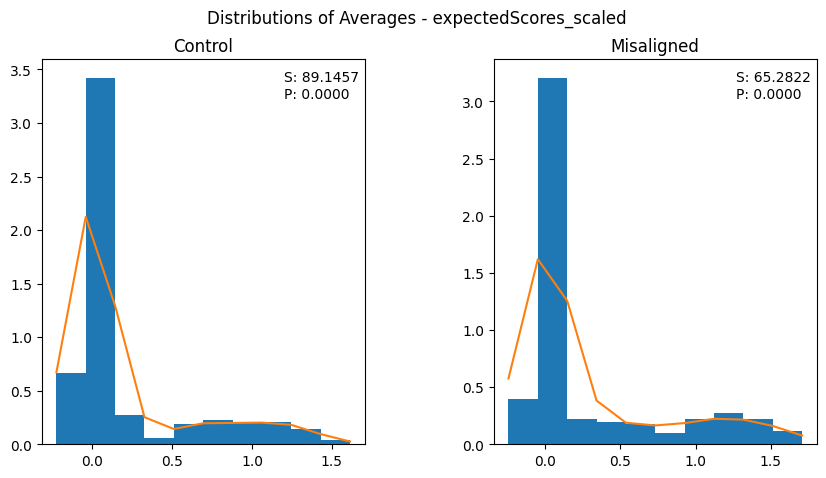

In [84]:

# Plotting normality for both groups

fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(10, 5),squeeze=False)
plt.suptitle("Distributions of Averages - {}".format(response_var))
ax = ax.flatten()

for idx, group in enumerate([(control_averages, "Control"), (scarce_averages, "Misaligned")]):
    data = group[0][response_var]
    label = group[1]
    print(data.mean(), data.std())#np.sqrt(len(data)))
    normaltest = scipy.stats.normaltest(data)
    density = scipy.stats.gaussian_kde(data)
    n, x, _ = ax[idx].hist(data, density=True)
    ax[idx].set_title(label)
    ax[idx].plot(x, density(x))
    ax[idx].text(0.75,0.9, "S: {0:0.4f}\nP: {1:0.4f}".format(normaltest.statistic, normaltest.pvalue), transform=ax[idx].transAxes)

plt.subplots_adjust(
                wspace=0.4, 
                hspace=0.4)
plt.show()

In [85]:
# Perform independent T-test if data is normal


two = scipy.stats.ttest_ind(scarce_averages[response_var], control_averages[response_var], equal_var=True, alternative='two-sided')
less = scipy.stats.ttest_ind(scarce_averages[response_var], control_averages[response_var], equal_var=True, alternative='less')
greater = scipy.stats.ttest_ind(scarce_averages[response_var], control_averages[response_var], equal_var=True, alternative='greater')

print("Response Variable: {}".format(response_var))
print("Two-Sided:")
print("\tStatistic:| {0:0.3f}\n\tP-value: {1}".format(two.statistic, two.pvalue))
print("Misaligned < Control:")
print("\tStatistic: {0:0.3f}\n\tP-value: {1}".format(less.statistic, less.pvalue))
print("Misaligned > Control:")
print("\tStatistic: {0:0.3f}\n\tP-value: {1}".format(greater.statistic, greater.pvalue))

Response Variable: expectedScores_scaled
Two-Sided:
	Statistic:| 2.223
	P-value: 0.02664829534022856
Scarce < Control:
	Statistic: 2.223
	P-value: 0.9866758523298857
Scarce > Control:
	Statistic: 2.223
	P-value: 0.01332414767011428


In [86]:
# Perform Mann-Whitney U test if data is not normal

two = scipy.stats.mannwhitneyu(scarce_averages[response_var], control_averages[response_var], alternative='two-sided')
less = scipy.stats.mannwhitneyu(scarce_averages[response_var], control_averages[response_var], alternative='less')
greater = scipy.stats.mannwhitneyu(scarce_averages[response_var], control_averages[response_var], alternative='greater')

print("Two-Sided:")
print("\tStatistic: {0:0.3f}\n\tP-value: {1}".format(two.statistic, two.pvalue))
print("Misaligned < Control:")
print("\tStatistic: {0:0.3f}\n\tP-value: {1}".format(less.statistic, less.pvalue))
print("Misaligned > Control:")
print("\tStatistic: {0:0.3f}\n\tP-value: {1}".format(greater.statistic, greater.pvalue))


print("Mann–Whitney $U = {0:0.1f}$, $P = {1:0.3f}$, one-tailed".format(greater.statistic, greater.pvalue))

Two-Sided:
	Statistic: 40795.000
	P-value: 4.4234302186177215e-05
Misaligned < Control:
	Statistic: 40795.000
	P-value: 0.9999779394335697
Misaligned > Control:
	Statistic: 40795.000
	P-value: 2.2117151093088607e-05
Mann–Whitney $U = 40795.0$, $P = 0.000$, one-tailed


# Comparing BIC scores of LMMs with and without random slopes

In [122]:
# Select the response variable for this analysis
# expectedScores_scaled, avgClickLevel, clicksL1, clicksL5

response_var = "clicksL1"
assert (response_var in response_vars), "{} is not a valid response variable".format(response_var)

/Volumes/DataDrive/mcl-misalignment-mouselab/analysis/aenv/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/Volumes/DataDrive/mcl-misalignment-mouselab/analysis/aenv/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


                  Mixed Linear Model Regression Results
Model:                  MixedLM       Dependent Variable:       clicksL1 
No. Observations:       4527          Method:                   REML     
No. Groups:             503           Scale:                    0.0035   
Min. group size:        9             Log-Likelihood:           5556.9138
Max. group size:        9             Converged:                Yes      
Mean group size:        9.0                                              
-------------------------------------------------------------------------
                               Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------------
Intercept                       0.061    0.004 15.235 0.000  0.053  0.069
C(condition)[T.1]              -0.003    0.006 -0.441 0.659 -0.014  0.009
trialNumbers                   -0.006    0.001 -8.268 0.000 -0.007 -0.004
trialNumbers:C(condition)[T.1]  0.002    0.001  2.074 0.

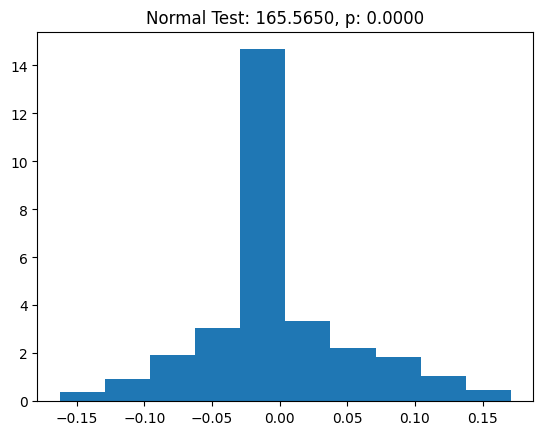

In [123]:
# Learning Phase

use_orig = False
# False for response variable expectedScores_scaled
filter_click_parts = True

if use_orig:
    learning_df = pd.concat([scarce_learning_data_orig, control_learning_data_orig]).reset_index(drop=True)
else: 
    learning_df = pd.concat([scarce_learning_data, control_learning_data]).reset_index(drop=True)

learning_df[response_var] = learning_df[response_var]
# Filter out participants whose click strategies are not valid
if filter_click_parts:
    learning_df = learning_df.loc[learning_df.clickStratsValid]
formula = '{} ~ trialNumbers + C(condition) + trialNumbers:C(condition)'.format(response_var)

re_formula = 'trialNumbers'

standardize_cols = ["trialNumbers"]
for col in standardize_cols:
    learning_df[col] = (learning_df[col] - learning_df[col].mean())
    
    
mixed = True

if mixed:
    glm = smf.mixedlm(formula=formula, re_formula=re_formula, data=learning_df, groups=learning_df['workerId'])
    glm_2 = smf.mixedlm(formula=formula, data=learning_df, groups=learning_df['workerId'])
else:
    glm = smf.glm(formula=formula, data=learning_df)

results = glm.fit()
results_2 = glm_2.fit()

print(results.summary())
resids = results.resid_response if not mixed else results.resid
normaltest = scipy.stats.normaltest(resids)
plt.hist(resids, density=True)
plt.title("Normal Test: {0:0.4f}, p: {1:0.4f}".format(normaltest[0], normaltest[1]))
plt.show()

In [124]:
def calc_bic_lmm(mdf):
    # print(mdf.nobs, mdf.df_modelwc)
    return -2 * mdf.llf + np.log(mdf.nobs) * (mdf.df_modelwc)

In [125]:
# Random Slope BIC
bic_rs = calc_bic_lmm(results)
print(bic_rs)

# Random Intercept BIC
bic_ri = calc_bic_lmm(results_2)
print(bic_ri)

# Difference
print(bic_ri - bic_rs)

-11054.90293396035
-10906.452907647987
148.45002631236275


# Appendix

# 1.5 - GLM Strategy Proportions

Observing how the strategies of the participants (as inferred by the Computational Microscope) change over time in each condition

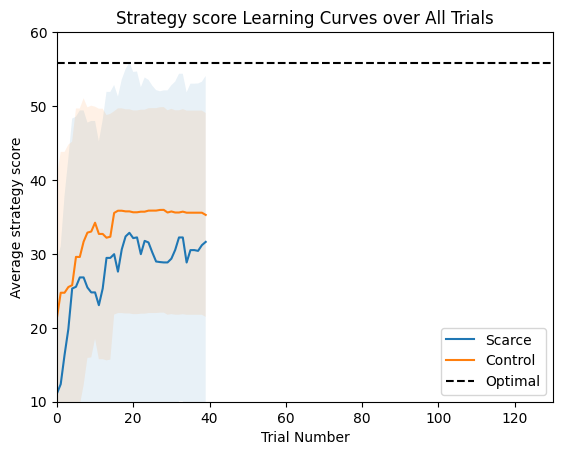

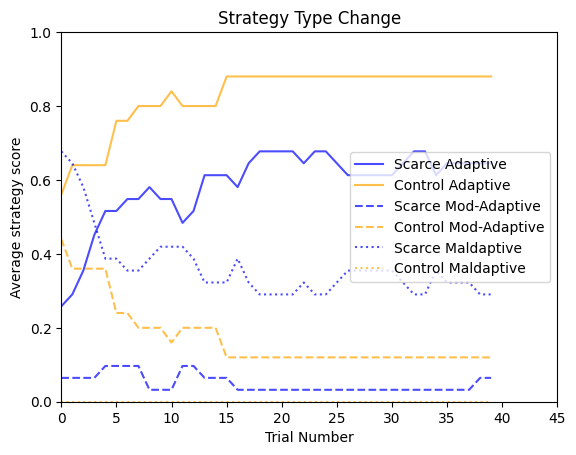

In [151]:
# Plotting mean expected score vs. trial number for each condition

data_to_copy = filtered_data.copy() # all_trials_df, outliers_excluded, or outliers_excluded_part

scarce_trial_group = data_to_copy.loc[data_to_copy.condition == 1].groupby('trialNumbers')
control_trial_group = data_to_copy.loc[data_to_copy.condition == 0].groupby('trialNumbers')

# Taking the mean expected score over all trials 
scarce_data_all = np.array(scarce_trial_group.mean(numeric_only=True)["strategyScores"])
scarce_data_all_sd = np.array(scarce_trial_group.std(numeric_only=True)["strategyScores"])
control_data = np.array(control_trial_group.mean(numeric_only=True)["strategyScores"])
control_data_sd = np.array(control_trial_group.std(numeric_only=True)["strategyScores"])

# Getting the proportions of clusters
scarce_data_adaptive = np.array(scarce_trial_group["cluster"].apply(lambda x: (x==0).sum()) / scarce_trial_group["cluster"].count())
control_data_adaptive = np.array(control_trial_group["cluster"].apply(lambda x: (x==0).sum()) / control_trial_group["cluster"].count())
scarce_data_modadaptive = np.array(scarce_trial_group["cluster"].apply(lambda x: (x==1).sum()) / scarce_trial_group["cluster"].count())
control_data_modadaptive = np.array(control_trial_group["cluster"].apply(lambda x: (x==1).sum()) / control_trial_group["cluster"].count())
scarce_data_maladaptive = np.array(scarce_trial_group["cluster"].apply(lambda x: (x==2).sum()) / scarce_trial_group["cluster"].count())
control_data_maladaptive = np.array(control_trial_group["cluster"].apply(lambda x: (x==2).sum()) / control_trial_group["cluster"].count())


plt.figure()
plt.title("Strategy score Learning Curves over All Trials")
plt.plot(list(range(len(scarce_data_all))), scarce_data_all, label="Scarce")
plt.fill_between(list(range(len(scarce_data_all))), scarce_data_all + scarce_data_all_sd, scarce_data_all - scarce_data_all_sd, alpha=0.1)
plt.plot(list(range(len(control_data))), control_data, label="Control")
plt.fill_between(list(range(len(control_data))), control_data + control_data_sd, control_data - control_data_sd, alpha=0.1)
plt.axhline(np.max(np.array(strategy_scores_control_list)[:,1], axis=0), color='k', label='Optimal', linestyle="--")
plt.legend()
plt.ylim([10,60])
plt.xlim([0, 130])
plt.xlabel("Trial Number")
plt.ylabel("Average strategy score")
plt.show()

plt.figure()
plt.title("Strategy Type Change")
alpha = 0.7
plt.plot(list(range(len(scarce_data_all))), scarce_data_adaptive, label="Scarce Adaptive", color='b',alpha=alpha)
plt.plot(list(range(len(control_data))), control_data_adaptive, label="Control Adaptive",color='orange',alpha=alpha)
plt.plot(list(range(len(scarce_data_all))), scarce_data_modadaptive, label="Scarce Mod-Adaptive", color='b',alpha=alpha, linestyle="--")
plt.plot(list(range(len(control_data))), control_data_modadaptive, label="Control Mod-Adaptive",color='orange',alpha=alpha, linestyle="--")
plt.plot(list(range(len(scarce_data_all))), scarce_data_maladaptive, label="Scarce Maldaptive", color='b',alpha=alpha, linestyle=":")
plt.plot(list(range(len(control_data))), control_data_maladaptive, label="Control Maldaptive",color='orange',alpha=alpha, linestyle=":")
plt.legend()
plt.ylim([0,1])
plt.xlim([0, 45])
plt.xlabel("Trial Number")
plt.ylabel("Average strategy score")
plt.show()


In [294]:
# Setting up logistic regression

data_to_copy = analysis_data.copy()
data_to_copy["cluster"] = data_to_copy["cluster"].astype("int64")

formula = "cluster ~ trialNumbers + C(scarce) + trialNumbers:C(scarce)"

model_1 = statsmodels.discrete.discrete_model.MNLogit.from_formula(formula, data_to_copy)
model_1_fit = model.fit()

endog = analysis_data["cluster"].astype("int64").map(lambda c: ["cat","dog","bear"][c])
exog = analysis_data[["trialNumbers", "scarce"]]
exog["trialNumbers:scarce"] = exog["trialNumbers"] * exog["scarce"]
exog["const"] = [1] * len(exog)

model_2 = statsmodels.discrete.discrete_model.MNLogit(endog, exog)
model_2_fit = model.fit()

print(model_1_fit.summary())
print(model_2_fit.summary())

Optimization terminated successfully.
         Current function value: 0.608218
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.608218
         Iterations 6
                          MNLogit Regression Results                          
Dep. Variable:                cluster   No. Observations:                15210
Model:                        MNLogit   Df Residuals:                    15202
Method:                           MLE   Df Model:                            6
Date:                Tue, 25 Oct 2022   Pseudo R-squ.:                 0.04896
Time:                        11:32:54   Log-Likelihood:                -9251.0
converged:                       True   LL-Null:                       -9727.3
Covariance Type:            nonrobust   LLR p-value:                1.652e-202
                  cluster=1       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------

/var/folders/8k/zq6x09px4838xflgn88yhgdw0002cw/T/ipykernel_51899/3125500743.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exog["trialNumbers:scarce"] = exog["trialNumbers"] * exog["scarce"]
/var/folders/8k/zq6x09px4838xflgn88yhgdw0002cw/T/ipykernel_51899/3125500743.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exog["const"] = [1] * len(exog)


                          MNLogit Regression Results                          
Dep. Variable:                cluster   No. Observations:                15210
Model:                        MNLogit   Df Residuals:                    15202
Method:                           MLE   Df Model:                            6
Date:                Tue, 25 Oct 2022   Pseudo R-squ.:                 0.04896
Time:                        11:32:54   Log-Likelihood:                -9251.0
converged:                       True   LL-Null:                       -9727.3
Covariance Type:            nonrobust   LLR p-value:                1.652e-202
                  cluster=1       coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                      -1.8616      0.145    -12.815      0.000      -2.146      -1.577
C(scarce)[T.1]                 -0.4777      0.167     -2.858      0.004      -0.

In [295]:
sum(model_2.endog == model_1.endog) / len(model_2.endog)

0.0